In [1]:
#Import Custom Library
# import random
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import csv
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import precision_score,f1_score,recall_score,accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

from joblib import dump, load
from datetime import datetime
import numpy as np

#Import Classifier Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from IPython.display import clear_output


class Preprocessor():
    def __init__(self,text,order=""):
        """
        Preprocessing Text: Digunakan untuk membersihkan teks sebelum dilakukan analisis.
        mencakup proses casefolding, filtering
        """
        self.text=text
        self._transform_emoticon()
        self._casefolding()
        self._filtering()
        self._tokenize()
        self._standarize()
        self._stemming()
        self._remove_stop_words()

    def get_text(self):
        return " ".join(self.text)
    
    def _casefolding(self):
        #Mengubah menjadi huruf kecil        
        self.text=self.text.lower()
        
    def _transform_emoticon(self):
        positive_emoji=["😊","🙂","😀","😃","😄","😁","😆","🤣","😂","😊","🥳","🥰","😍","🤩","😘","😚","😙","😋","🤗","🤭",]
        neutral_emoji=["😅","🙃","😉","😇","😎","😗","☺","😛","😜","😝","🤑","🤫","🤔","😐","🤐","🤨","😶","😏","😬","🤥","😌","🤤","😷","🥴","😳","🥺","😮","😯","😲","😦","😧","👻","👽","👾","🤖"]
        negative_emoji=["🤓","🧐","🥲","🤪","😑","😒","🙄","😪","😴","😔","🤒","🤕","🤢","🤮","🤧","🥵","🥶","😵","🤯","😕","😟","🙁","☹","😨","😰","😥","😢","😭","😱","😖","😣","😞","😓","😩","😫","🥱","😤","😡","😠","🤬","😈","👿","💀","☠","💩","🤡","👹","👺",]
        
        for i in positive_emoji:
            self.text=self.text.replace(i," positivemoji ")
        
        for i in neutral_emoji:
            self.text=self.text.replace(i," neutralmoji ")
        
        for i in negative_emoji:
            self.text=self.text.replace(i," negativemoji ")
                
    def _filtering(self):        
        #Url
        self.text=re.sub("https\S+","",self.text)
        self.text=re.sub("http\S+","",self.text)
        self.text=re.sub("\S+\.com\S+","",self.text)
        self.text=re.sub("\S+\.com","",self.text)
        
        #Remove Hashtag
        self.text=re.sub("#\S+","",self.text)
        
        #Remove Mention
        self.text=re.sub("@\S+","",self.text)
        
        #Remove Symbol and Number
        self.text=re.sub("[^A-Za-z\s]"," ",self.text)
        
        #Remove Spacing
        self.text=re.sub("\s+"," ",self.text)
        self.text=re.sub("^\s","",self.text)
        self.text=self.text

        
    def _tokenize(self):
        #Membagi kata
        self.text=self.text.split(" ")
    
   
    def _standarize(self):        
        #Mengubah menjadi kata baku
        j={}
        with open("standard_word.csv","r") as file:
            data=csv.reader(file,delimiter=",")
            for k,i in enumerate(data):
                if k==0: continue
                j[i[0]]=i[1]
                
        for k,t in enumerate(self.text):
            if t in j:
                self.text[k]=j[t]
        
    
    def _stemming(self):
        #Mengubah menjadi kata dasar
        factory=StemmerFactory()
        stemmer=factory.create_stemmer()
        
        self.text=stemmer.stem(" ".join(self.text))
        self._tokenize()

    def _remove_stop_words(self):
        stop_words = set(stopwords.words('indonesian'))
        add_stopwords=[]
        for i in add_stopwords:
            stop_words.append(i)
        w=[]
        for i in self.text:
            if i in stop_words:
                w.append("")
            else:
                w.append(i)
                
        self.text=w

        
    
class Analyzer():  
    def __init__(self):
        """
        Membuat model dan melakukan prediksi
        """
        self.t_size=0.2 #test size
    
    def predict(self,training_data:pd.DataFrame,data_to_predict:pd.DataFrame):
        #Train and Predict Directly
        model=self.create_model(training_data)
        return self.predict_by_model(model,data_to_predict)
    
    def predict_by_model(self,model,data:pd.DataFrame):

        #Output Data
        target_column:int=len(data.columns)-1
        X=data.iloc[:,data.columns!=data.columns[target_column]]
        y=data[data.columns[target_column]]
        prediction=model.predict(X)
        return prediction
    
        
    def create_model(self,data:pd.DataFrame,is_save:bool=False):
        target_column:int=len(data.columns)-1
        X=data.iloc[:,data.columns!=data.columns[target_column]]
        y=data[data.columns[target_column]]
        
        models_used=[
            KNeighborsClassifier(),
            SVC(),
            GaussianNB(),
            MultinomialNB(),
            DecisionTreeClassifier(),
            RandomForestClassifier(),
            GradientBoostingClassifier(),
            AdaBoostClassifier()
        ]
        
        
        max_accuracy=0
        accuracy_df=pd.DataFrame(columns=["Model","Accuracy","F1 Score","Precission","Recall"])
        for i in models_used:
            accuracies=[]
            print("Model: ",i,"Accuracy, F1 Score, Precission, Recall")
            for j in range(10):
                X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=self.t_size)
                i.fit(X_train,y_train)
                prediction=i.predict(X_test)
                accuracies.append(accuracy_score(y_test,prediction))
                accuracy_df=accuracy_df.append({
                    "Model":i,
                    "Accuracy":accuracy_score(y_test,prediction),
                    "F1 Score":f1_score(y_test,prediction,average='weighted'),
                    "Precission":precision_score(prediction,y_test,average='weighted'),
                    "Recall":recall_score(y_test,prediction,average='weighted')
                },ignore_index=True)
                print(i,",",accuracy_score(prediction,y_test),",",f1_score(y_test,prediction,average='weighted'),",",precision_score(y_test,prediction,average='weighted'),",",recall_score(y_test,prediction,average='weighted'))
                cm=confusion_matrix(y_test,prediction) 
                ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2]).plot()
                plt.show()
            accuracy=np.average(accuracies)
            if accuracy>max_accuracy:
                max_accuracy=accuracy
                i.fit(X,y)
                model=i
            print("Average Accuracy Score:",accuracy,"\n")
        accuracy_df.to_csv("accuracy_data.csv")
        print("Training Data Size: ",data.shape[0])
        print("Training Test Size: ",self.t_size*100,"%")
        print("Model used: "+model.__class__.__name__+" model. Accuracy: "+str(max_accuracy))
        if is_save:
            dump(model,"models/"+model.__class__.__name__+" "+str(datetime.now()).replace(":","")+".joblib")
        return model
    

# from Idlysis import Analyzer,Preprocessor
import time
from datetime import datetime
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import random
import re

from IPython.display import clear_output

def check_tweet(order):
    data=pd.read_csv("data/clean.csv")
    tweet=data["Tweet"][order]
    return "Tweet order: "+str(order)+" Tweet: "+tweet

def check_random_tweet():
    data=pd.read_csv("data/clean.csv")
    order=random.randint(0,len(data["Tweet"])-1)
    tweet=data["Tweet"][order]
    return "Tweet order: "+str(order)+" Tweet: "+tweet


def clean_data():
    #Data Cleaner
    data=pd.read_csv('data/2023-02-28 19.36.57.730834 PPN Naik.csv')
    data=data.drop_duplicates(subset=["Tweet"])
    
    #Set Data Type
    data=data.astype({
        'Id':'int64',
        'Datetime':'datetime64',
        'View Count':'int32',
        'Reply Count':'int32',
        'Retweet Count':'int32',
        'Like Count':'int32',
        'Quote Count':'int32',
        'Mentioned Users Count':'int32',
        'User Verified':'bool',
        'User Followers Count':'int32',
        'User Statuses Count':'int32',
        'User Verified':'bool'
    })
    
    #Separate Date
    data["Year"]=data["Datetime"].dt.year
    data["Month"]=data["Datetime"].dt.month
    data["Day"]=data["Datetime"].dt.day
    
    #Add New Column : Kota
    data["Kota"]=[str(i).split(",")[0] for i in data["Place"]]
    
    #Date Cutoff
    data=data[(data["Datetime"]<datetime(2022,12,31)) & (data["Datetime"]>datetime(2020,5,1))]
    
    #Remove Sentiment Label Column
    data=data.drop(columns=["Sentiment Label"])
    
    #Indonesian Only
    data=data[data["Language"]=="in"]
    
    #Preprocess Tweet
    c=[]
    p_counter=0
    p_size=len(data["Tweet"])
    for i in data["Tweet"]:
        c.append(Preprocessor(i).get_text())
        p_counter+=1
        print(p_counter,"/",p_size," Preprocess Complete")
        
    data["Clean"]=c
    
    #Save Data
    data.to_csv('data/clean.csv',index=False)
    return data

Model:  KNeighborsClassifier() Accuracy, F1 Score, Precission, Recall


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier() , 0.7972027972027972 , 0.7892312184112669 , 0.7827012730858884 , 0.7972027972027972


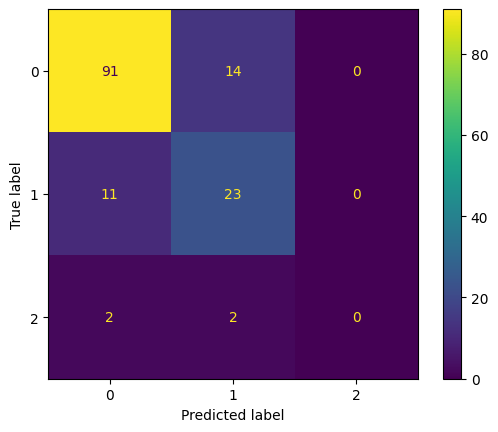

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7272727272727273 , 0.7161039677168709 , 0.7112469412120981 , 0.7272727272727273


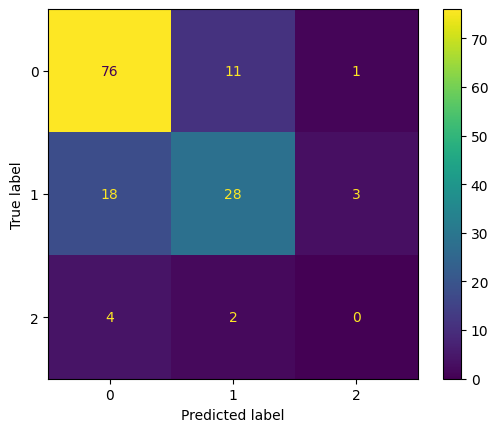

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7482517482517482 , 0.7248640659534367 , 0.7039468683490422 , 0.7482517482517482


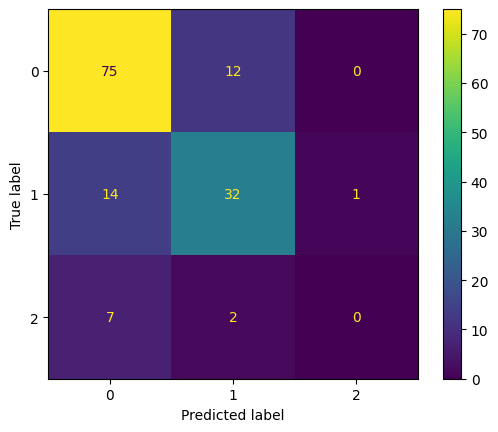

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier() , 0.7342657342657343 , 0.6919486061165223 , 0.6553295189658825 , 0.7342657342657343


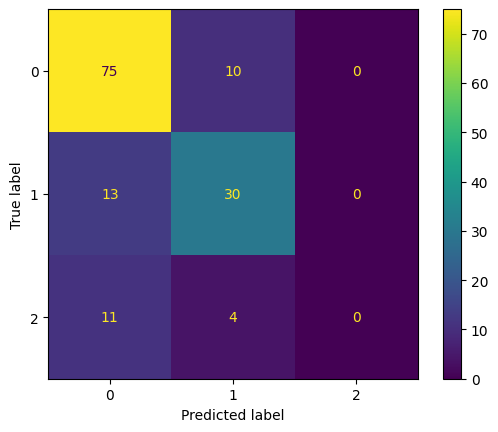

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7762237762237763 , 0.7738425957604039 , 0.7722898460762538 , 0.7762237762237763


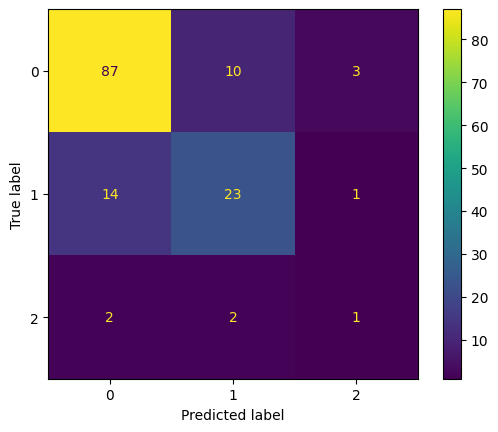

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7902097902097902 , 0.7727334394001062 , 0.7805647183005674 , 0.7902097902097902


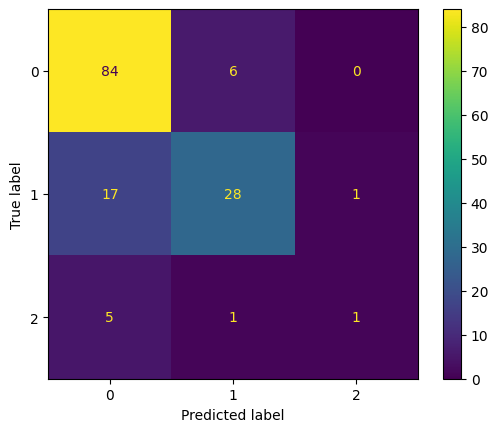

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7062937062937062 , 0.6655953725721167 , 0.6449244075762294 , 0.7062937062937062


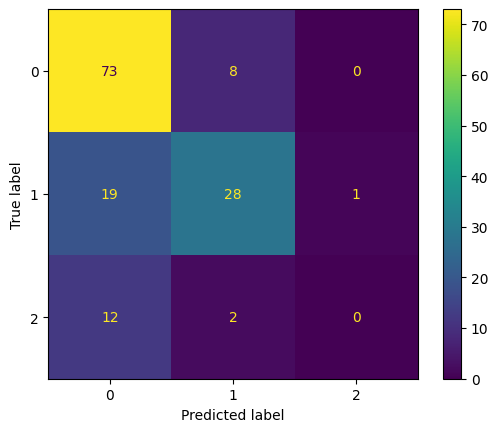

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier() , 0.7832167832167832 , 0.7657327288096518 , 0.7512028201683374 , 0.7832167832167832


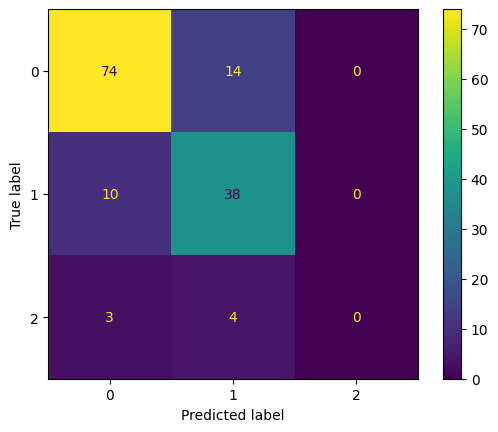

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7412587412587412 , 0.7289335664335664 , 0.7315804151095447 , 0.7412587412587412


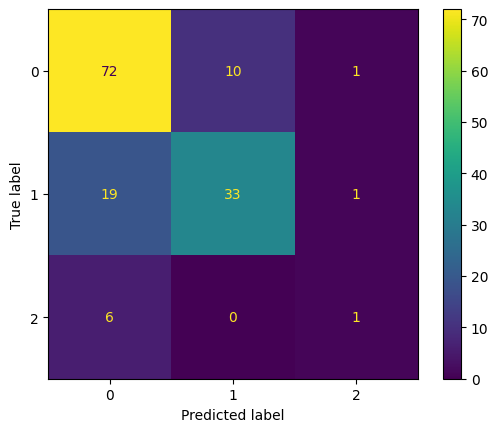

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


KNeighborsClassifier() , 0.7622377622377622 , 0.734721780490347 , 0.7733855213612298 , 0.7622377622377622


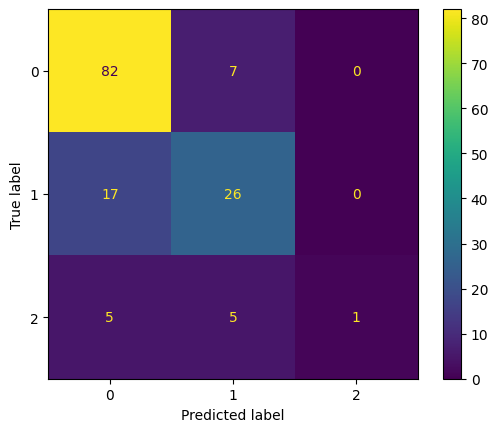

Average Accuracy Score: 0.7566433566433568 

Model:  SVC() Accuracy, F1 Score, Precission, Recall


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.8251748251748252 , 0.7964008167053852 , 0.8011443102352194 , 0.8251748251748252


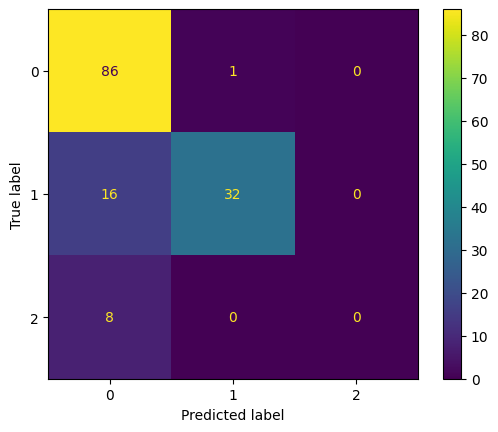

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7832167832167832 , 0.7520245625152563 , 0.7449118609399236 , 0.7832167832167832


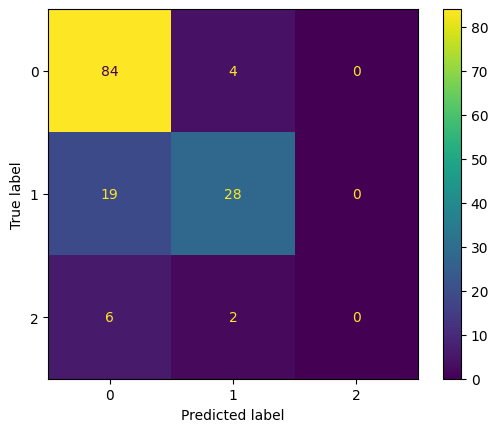

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7972027972027972 , 0.7715939462726707 , 0.7608481262327416 , 0.7972027972027972


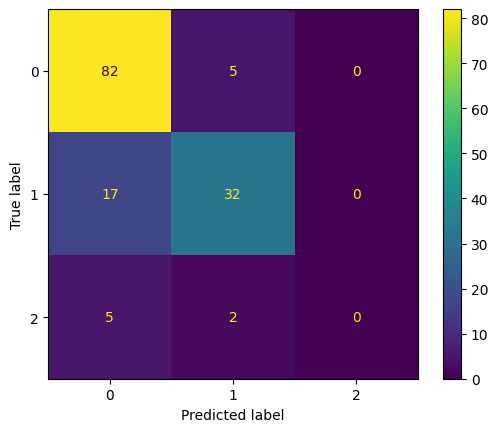

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7692307692307693 , 0.7444772422147988 , 0.7260644007155634 , 0.7692307692307693


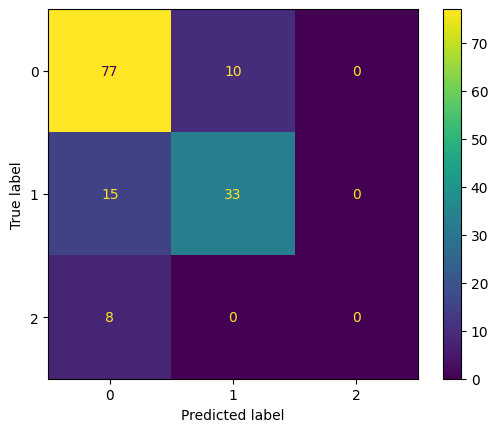

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7692307692307693 , 0.7312913331012879 , 0.717439082656474 , 0.7692307692307693


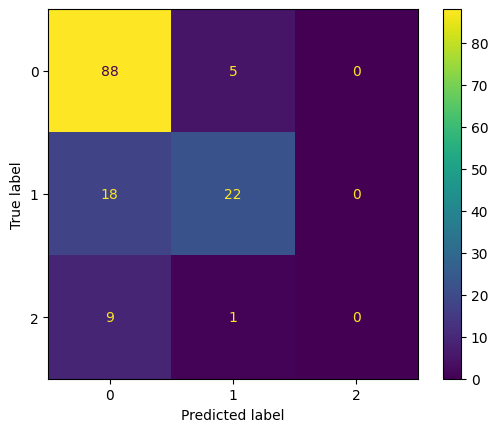

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.8041958041958042 , 0.7764737442156797 , 0.7624800941632625 , 0.8041958041958042


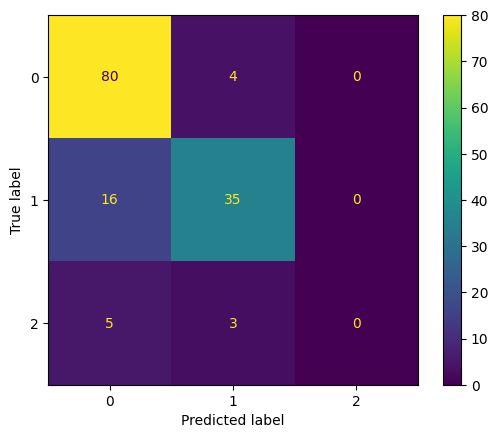

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7622377622377622 , 0.7385896031679164 , 0.7610292932873579 , 0.7622377622377622


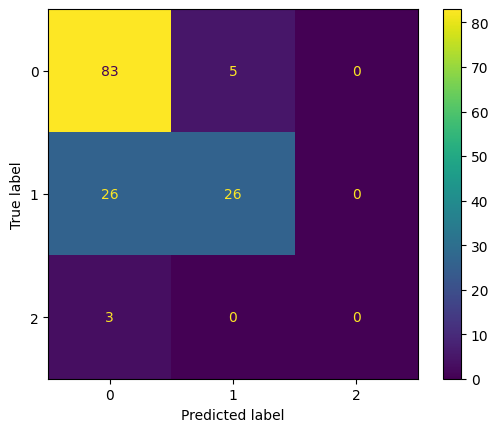

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC() , 0.7972027972027972 , 0.7799085278017861 , 0.7670679155827671 , 0.7972027972027972


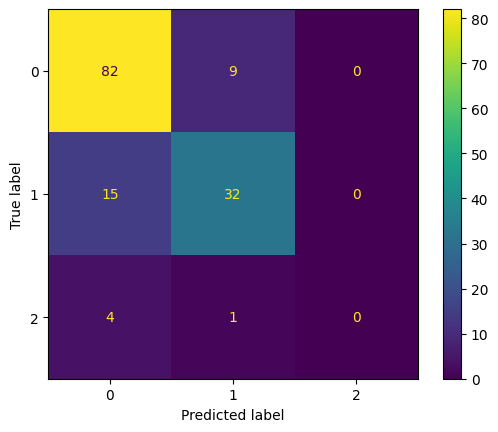

SVC() , 0.8391608391608392 , 0.8198854956408865 , 0.8231388080945603 , 0.8391608391608392


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


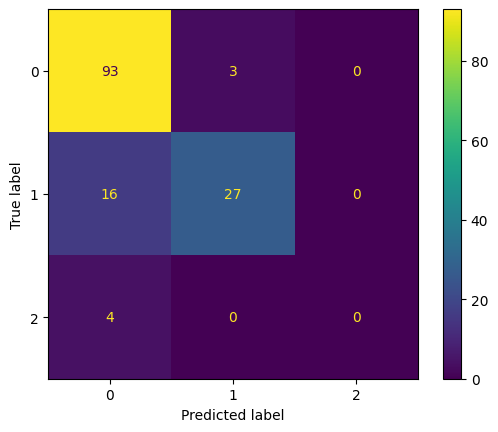

SVC() , 0.8181818181818182 , 0.7969846238182084 , 0.7971512263547663 , 0.8181818181818182


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


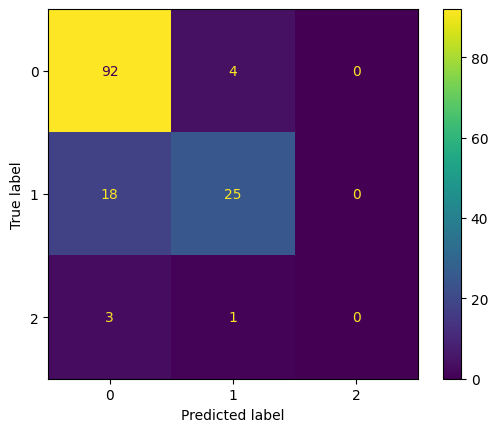

Average Accuracy Score: 0.7965034965034965 

Model:  GaussianNB() Accuracy, F1 Score, Precission, Recall
GaussianNB() , 0.7202797202797203 , 0.7543682096879627 , 0.792372157756773 , 0.7202797202797203


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


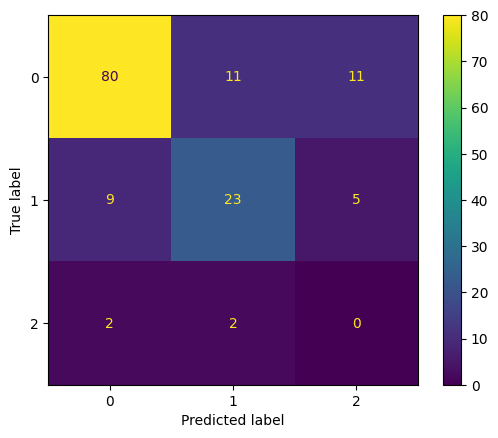

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.7342657342657343 , 0.7383214088416401 , 0.746525456087107 , 0.7342657342657343


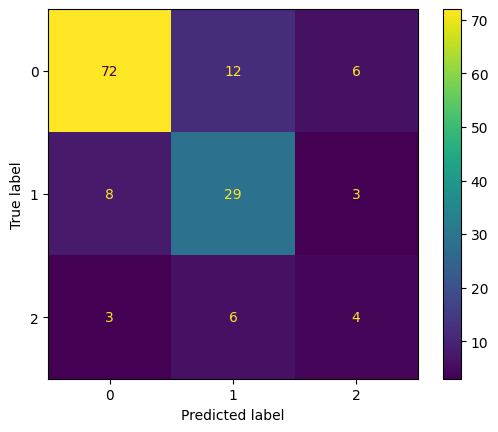

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6993006993006993 , 0.7207334391670516 , 0.7512993665959693 , 0.6993006993006993


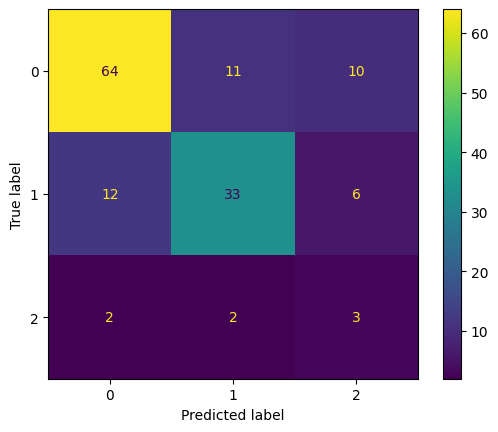

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6573426573426573 , 0.6736689116277765 , 0.7029117683142451 , 0.6573426573426573


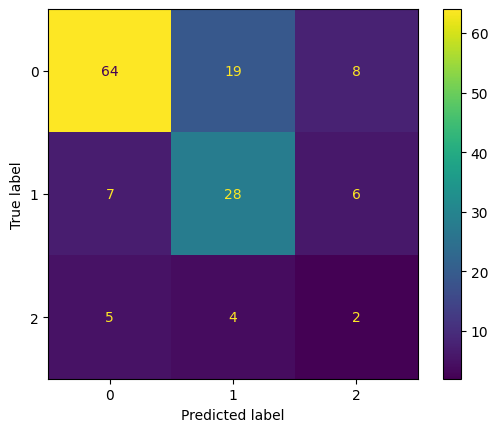

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6923076923076923 , 0.7230292926887354 , 0.7610192005796401 , 0.6923076923076923


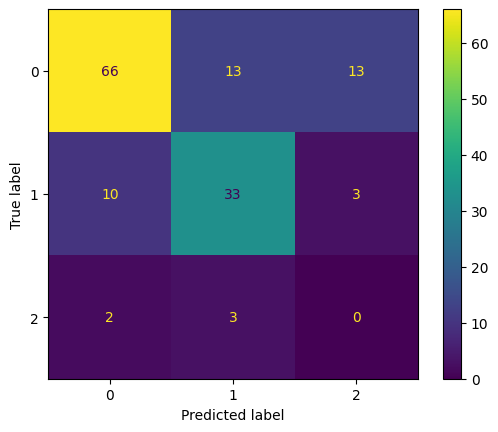

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6923076923076923 , 0.7015108245048365 , 0.7117479470420647 , 0.6923076923076923


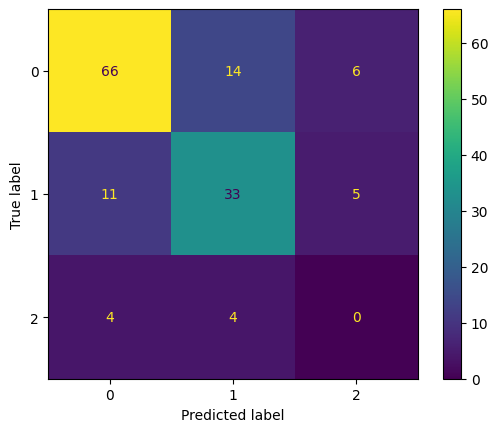

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6993006993006993 , 0.7058095700314336 , 0.7143574374343604 , 0.6993006993006993


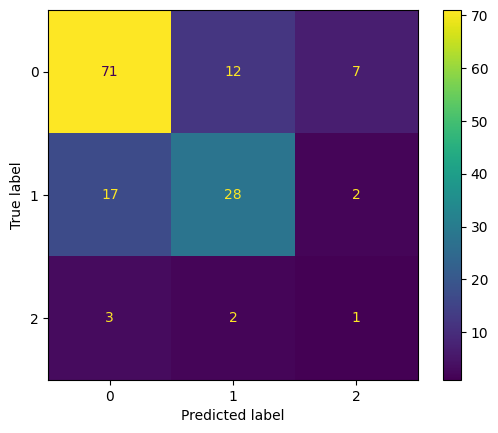

GaussianNB() , 0.6643356643356644 , 0.6695793484219265 , 0.6762846663649688 , 0.6643356643356644


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


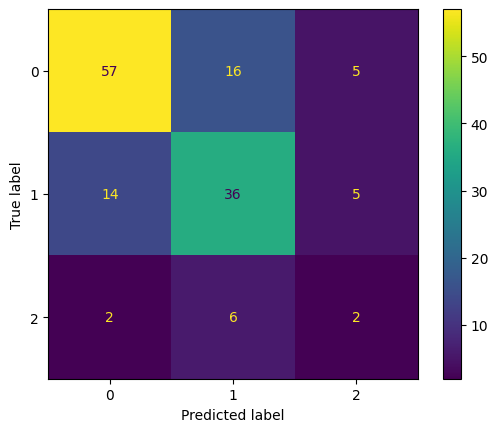

GaussianNB() , 0.6643356643356644 , 0.6766452438116607 , 0.7053942431626605 , 0.6643356643356644


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


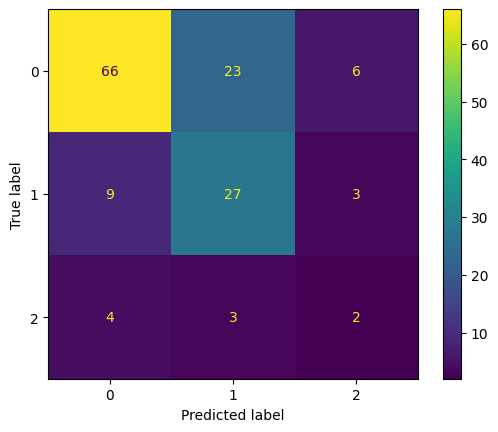

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GaussianNB() , 0.6643356643356644 , 0.6992053039798398 , 0.7389795389795389 , 0.6643356643356644


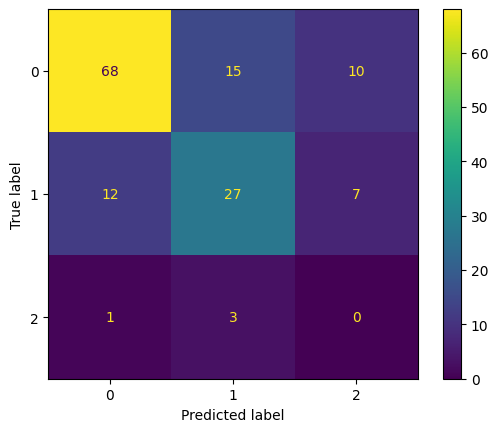

Average Accuracy Score: 0.6888111888111889 

Model:  MultinomialNB() Accuracy, F1 Score, Precission, Recall
MultinomialNB() , 0.8181818181818182 , 0.7906976744186046 , 0.7751479289940828 , 0.8181818181818182


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


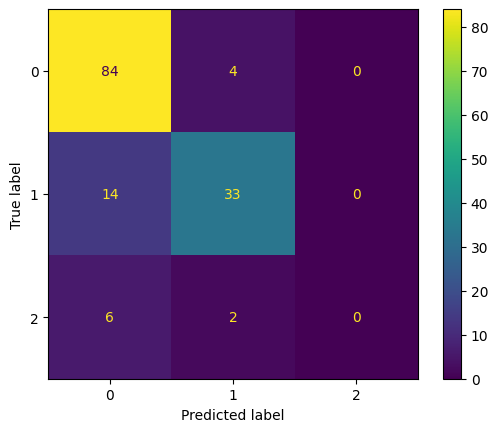

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.7692307692307693 , 0.7481700991316376 , 0.7290343927172571 , 0.7692307692307693


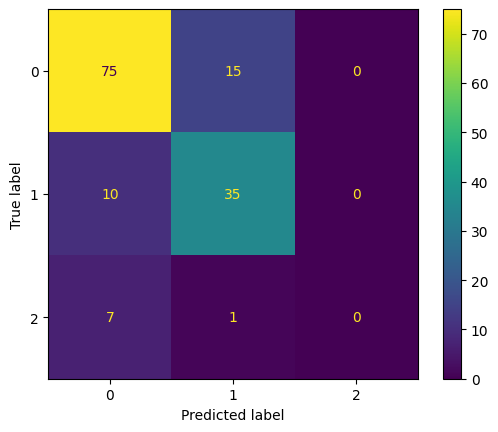

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.8391608391608392 , 0.8030884124916675 , 0.7765126255692294 , 0.8391608391608392


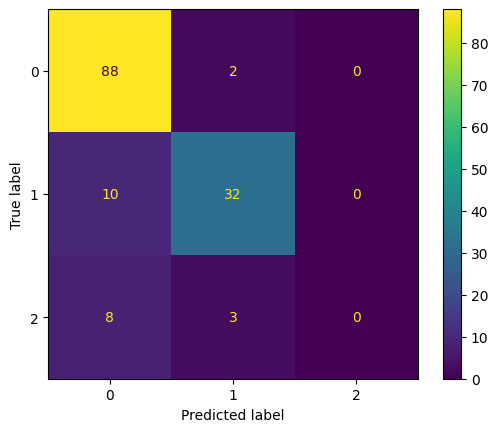

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.8391608391608392 , 0.8118448561747531 , 0.7862531017369727 , 0.8391608391608392


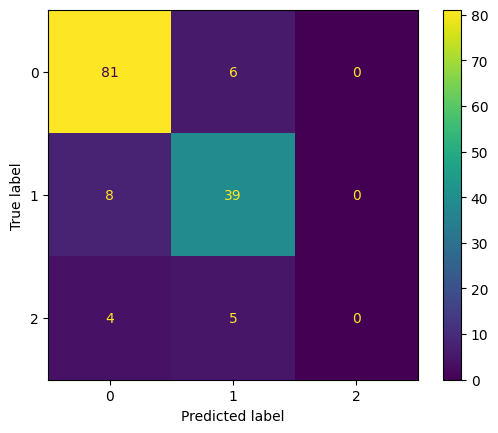

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.7832167832167832 , 0.7562034070555201 , 0.7312990040262768 , 0.7832167832167832


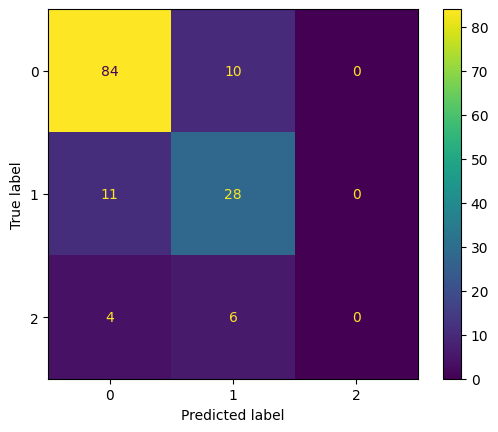

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.7692307692307693 , 0.7369946503028203 , 0.726438273608085 , 0.7692307692307693


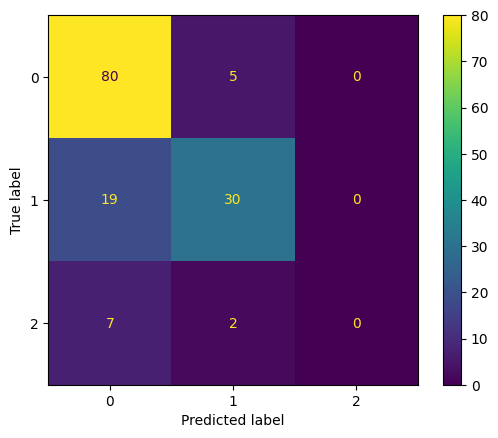

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.8181818181818182 , 0.7991014535880401 , 0.7822494965352108 , 0.8181818181818182


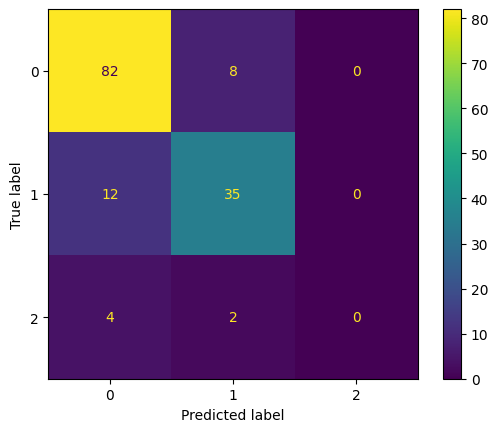

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.7622377622377622 , 0.7307393869360412 , 0.7024365234083904 , 0.7622377622377622


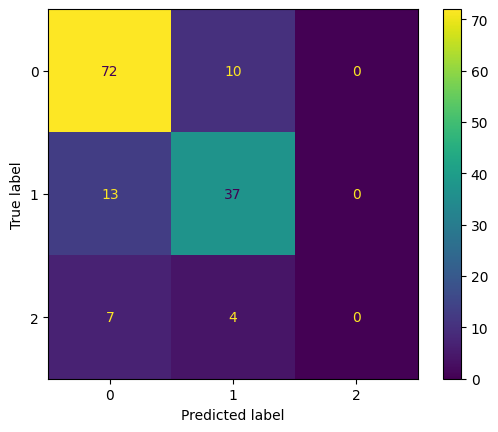

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.7692307692307693 , 0.7307507307507308 , 0.6972235685106972 , 0.7692307692307693


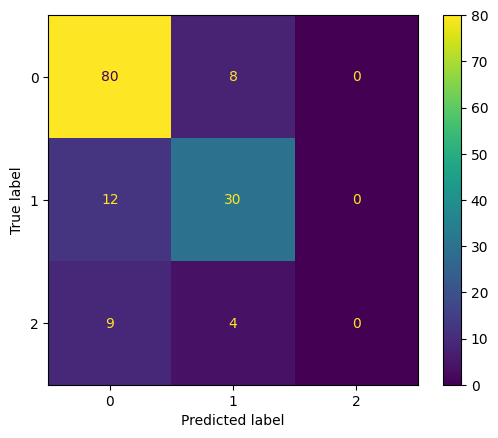

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MultinomialNB() , 0.8111888111888111 , 0.7841737608843585 , 0.7670463032113517 , 0.8111888111888111


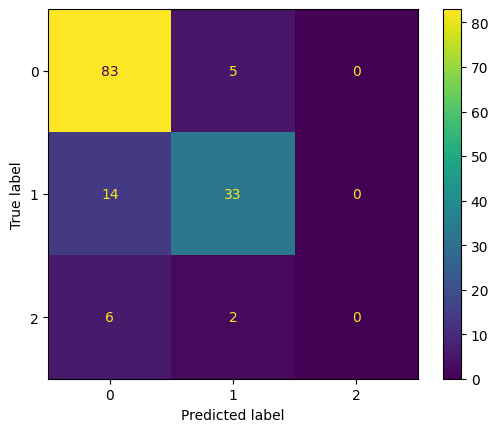

Average Accuracy Score: 0.7979020979020979 

Model:  DecisionTreeClassifier() Accuracy, F1 Score, Precission, Recall
DecisionTreeClassifier() , 0.7832167832167832 , 0.7712675524089917 , 0.7778833485355225 , 0.7832167832167832


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


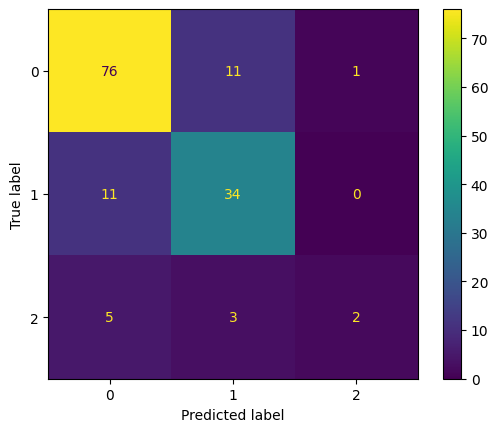

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7342657342657343 , 0.726535926766985 , 0.7331490731490731 , 0.7342657342657343


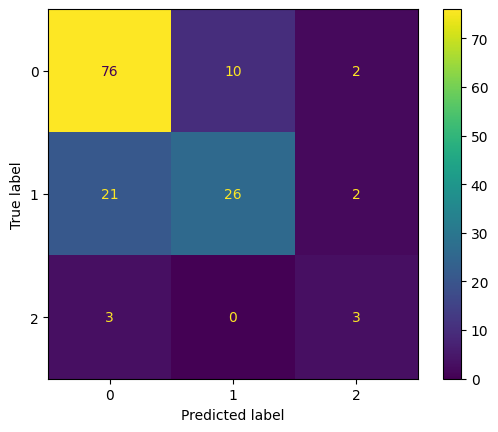

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.8041958041958042 , 0.7962649180040483 , 0.7931566539521084 , 0.8041958041958042


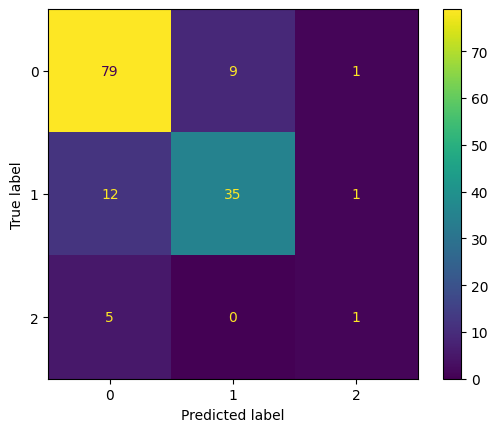

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7622377622377622 , 0.7584686239250495 , 0.7588682962059585 , 0.7622377622377622


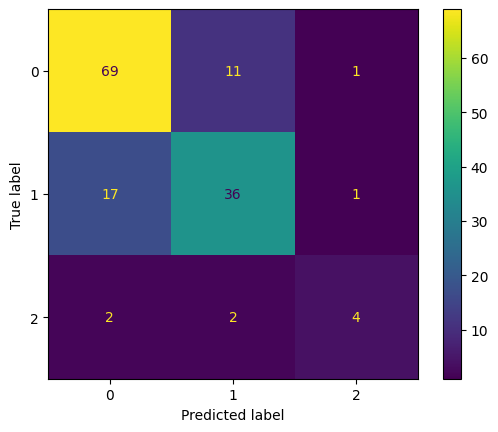

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7552447552447552 , 0.747614840200987 , 0.7487476160203432 , 0.7552447552447552


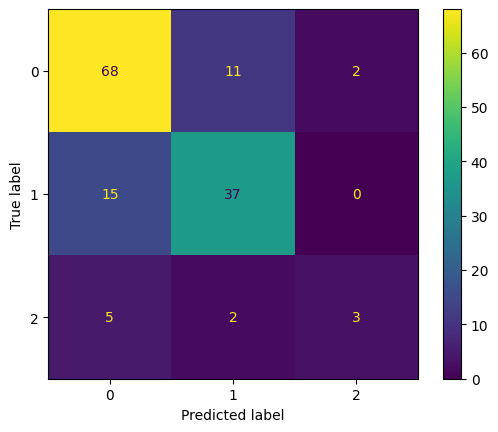

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7342657342657343 , 0.7395398252541111 , 0.7457140449911535 , 0.7342657342657343


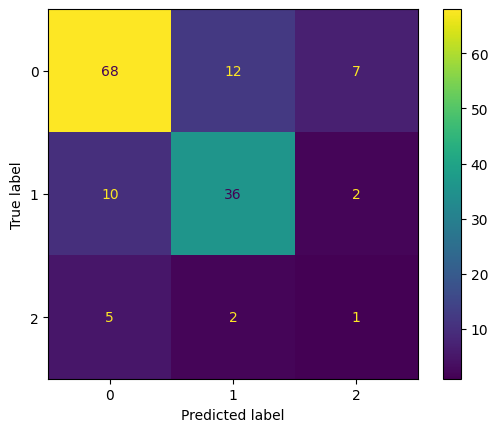

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7552447552447552 , 0.7505090501041918 , 0.7483798707202962 , 0.7552447552447552


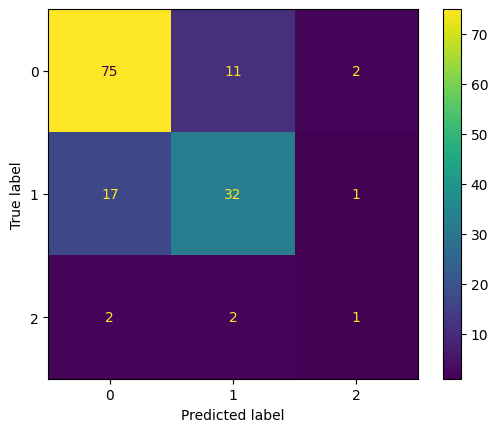

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.8321678321678322 , 0.8280854483862004 , 0.8257871857871858 , 0.8321678321678322


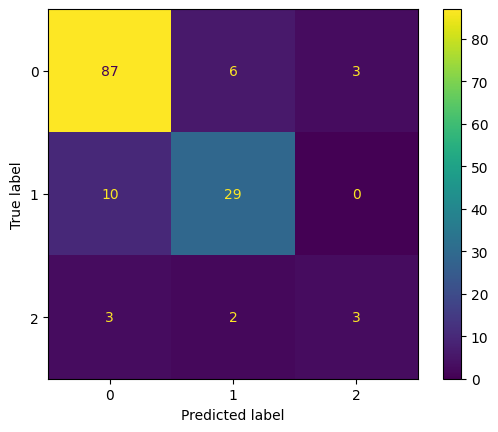

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7202797202797203 , 0.7084165834165834 , 0.7506267317588072 , 0.7202797202797203


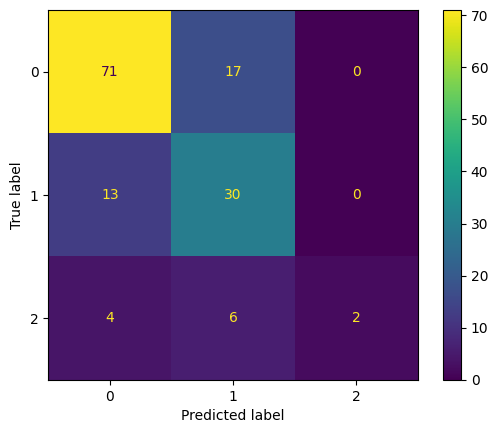

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


DecisionTreeClassifier() , 0.7272727272727273 , 0.7176934036959256 , 0.7112466729488006 , 0.7272727272727273


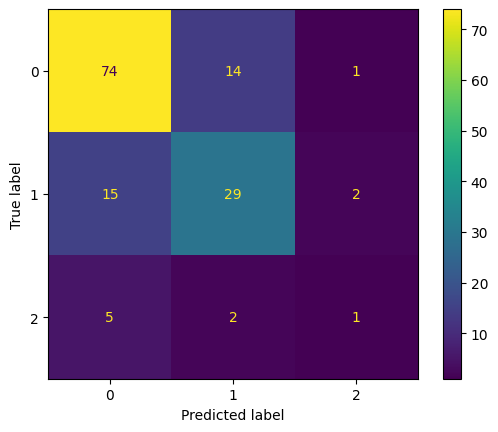

Average Accuracy Score: 0.7608391608391608 

Model:  RandomForestClassifier() Accuracy, F1 Score, Precission, Recall


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


RandomForestClassifier() , 0.8181818181818182 , 0.8007548861395015 , 0.8296540061245944 , 0.8181818181818182


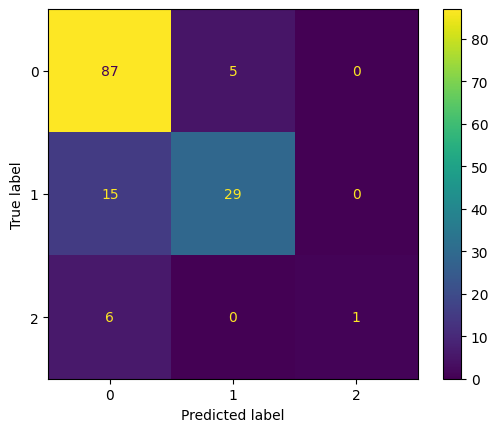

RandomForestClassifier() , 0.8531468531468531 , 0.8260658382775072 , 0.8059404250993036 , 0.8531468531468531


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


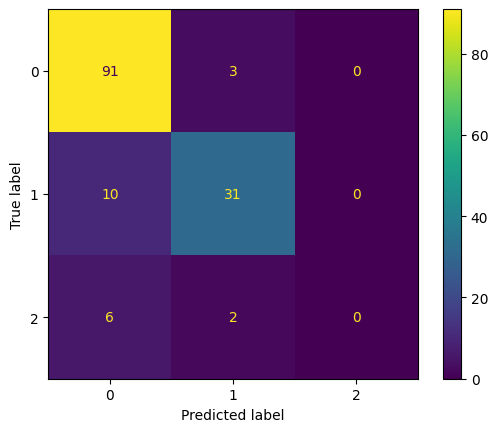

RandomForestClassifier() , 0.9090909090909091 , 0.8979868616232253 , 0.89567519858782 , 0.9090909090909091


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


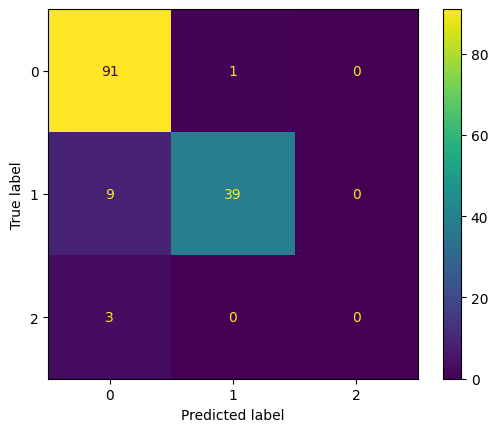

RandomForestClassifier() , 0.8111888111888111 , 0.7937705143535219 , 0.7808891252219804 , 0.8111888111888111


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


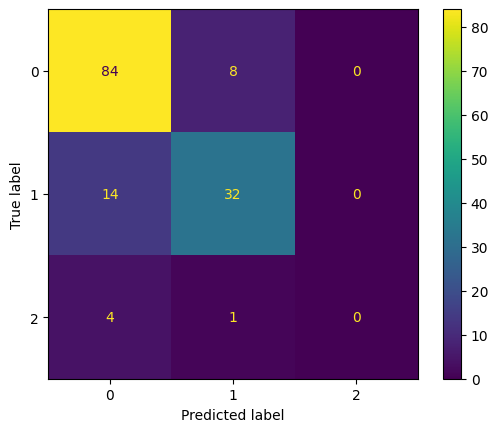

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier() , 0.8391608391608392 , 0.821260902019329 , 0.8110182500426403 , 0.8391608391608392


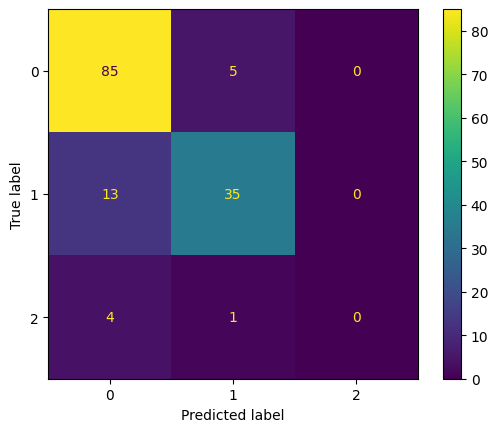

RandomForestClassifier() , 0.8041958041958042 , 0.7807802829354553 , 0.763200931063198 , 0.8041958041958042


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


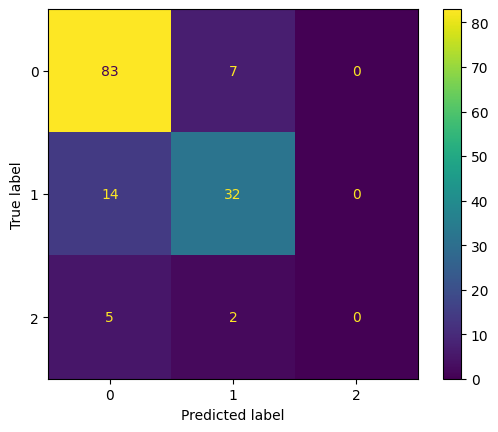

RandomForestClassifier() , 0.8811188811188811 , 0.8716212677737927 , 0.8822750693126545 , 0.8811188811188811


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


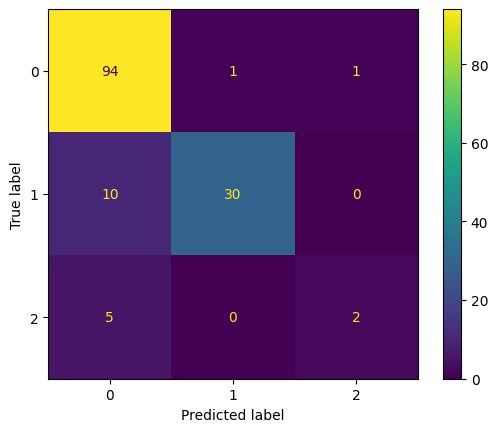

RandomForestClassifier() , 0.7972027972027972 , 0.7656314739082716 , 0.7751057202384636 , 0.7972027972027972


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({
C:\Users\Kelvin Cipta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


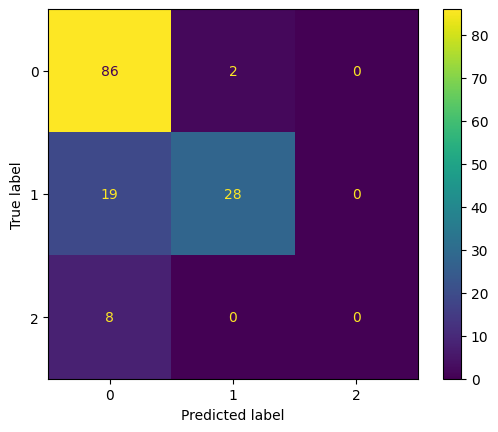

RandomForestClassifier() , 0.8391608391608392 , 0.8245614082558826 , 0.8429513668150032 , 0.8391608391608392


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


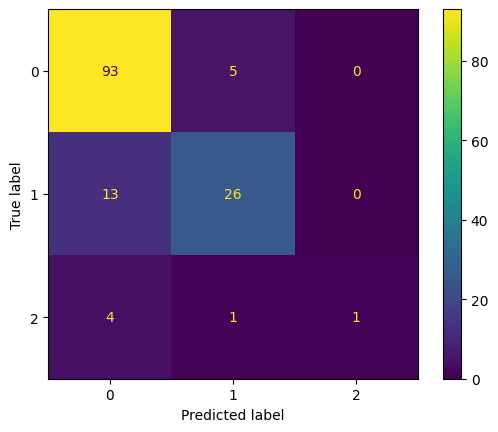

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


RandomForestClassifier() , 0.8041958041958042 , 0.7877628531890539 , 0.8159350083878386 , 0.8041958041958042


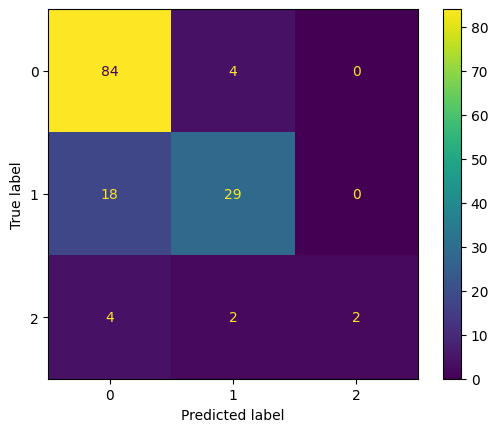

Average Accuracy Score: 0.8356643356643356 

Model:  GradientBoostingClassifier() Accuracy, F1 Score, Precission, Recall


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.7762237762237763 , 0.7583234781861549 , 0.7896176324383631 , 0.7762237762237763


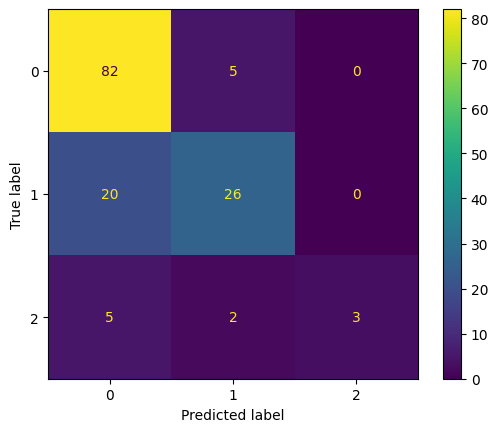

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.7832167832167832 , 0.7703448877057877 , 0.8089564281871974 , 0.7832167832167832


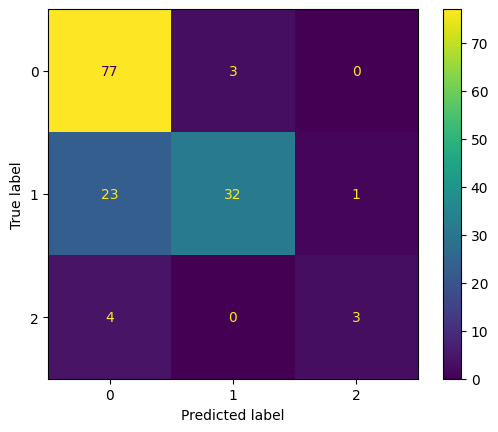

GradientBoostingClassifier() , 0.7902097902097902 , 0.7693958744986925 , 0.7793006180102954 , 0.7902097902097902


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


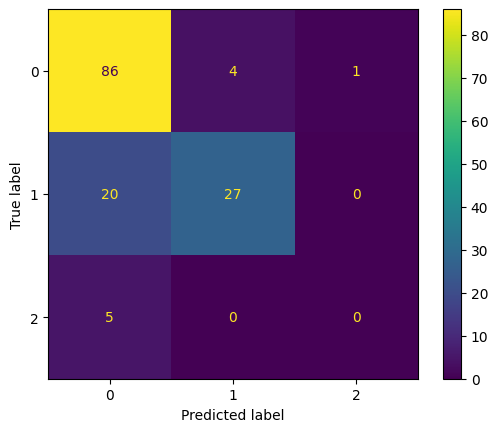

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.8041958041958042 , 0.7932067932067932 , 0.7995767673187029 , 0.8041958041958042


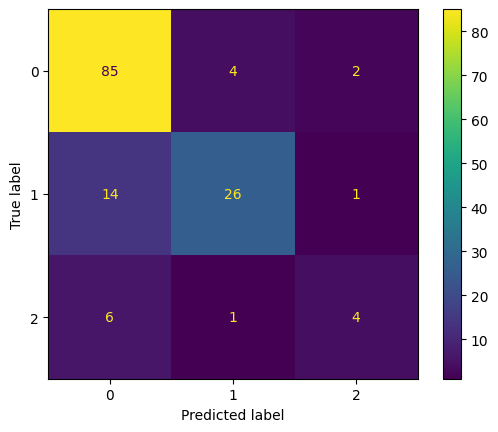

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.7762237762237763 , 0.7619989022605301 , 0.7665865049615689 , 0.7762237762237763


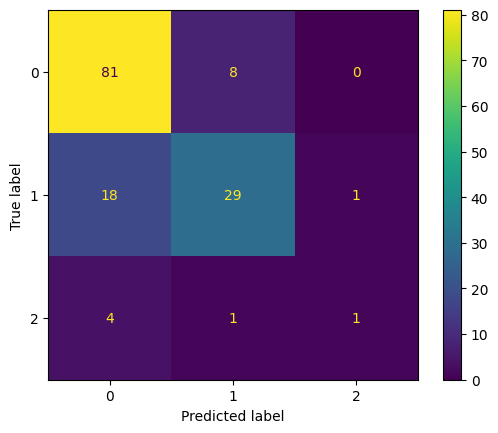

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.8041958041958042 , 0.7946473757174682 , 0.8123876123876125 , 0.8041958041958042


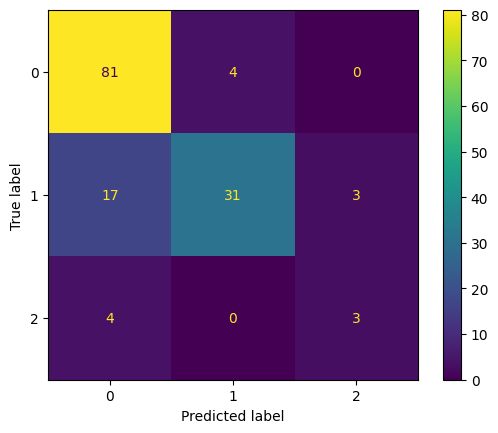

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.8391608391608392 , 0.8300161377084454 , 0.8427754064117701 , 0.8391608391608392


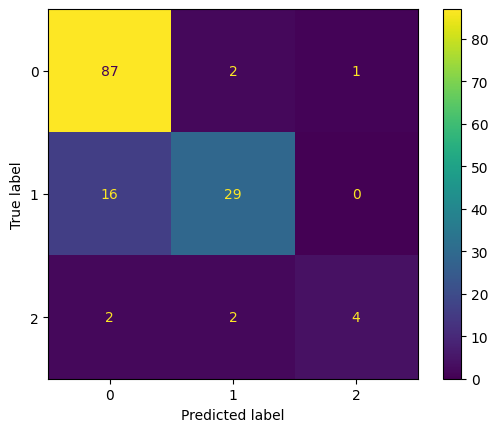

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


GradientBoostingClassifier() , 0.8461538461538461 , 0.843794078830018 , 0.8439951675245793 , 0.8461538461538461


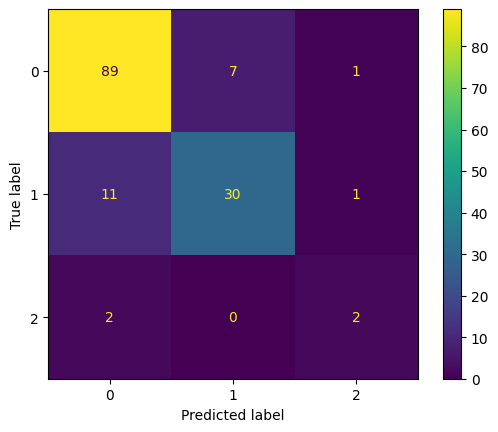

GradientBoostingClassifier() , 0.8601398601398601 , 0.8528536008420706 , 0.8619290619290619 , 0.8601398601398601


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


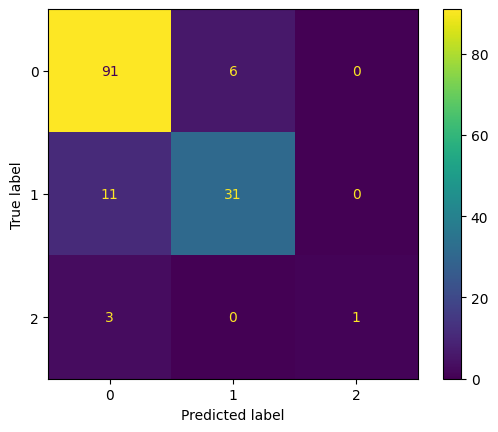

GradientBoostingClassifier() , 0.7342657342657343 , 0.7191666971771685 , 0.7360123747220522 , 0.7342657342657343


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


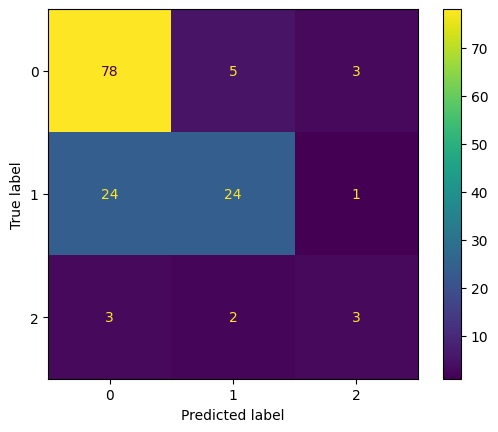

Average Accuracy Score: 0.8013986013986015 

Model:  AdaBoostClassifier() Accuracy, F1 Score, Precission, Recall


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.6713286713286714 , 0.6438810262339674 , 0.6518325987352536 , 0.6713286713286714


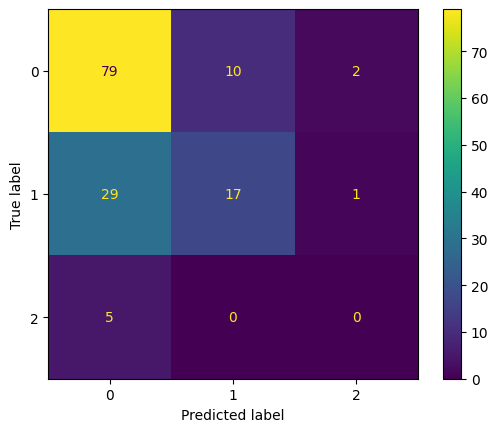

AdaBoostClassifier() , 0.6573426573426573 , 0.6487888922671532 , 0.6473139263836938 , 0.6573426573426573


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


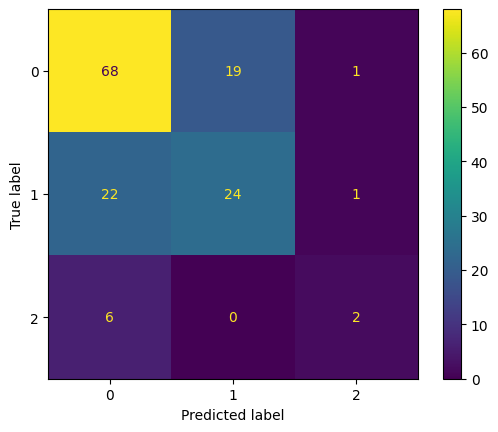

AdaBoostClassifier() , 0.6783216783216783 , 0.6615967365967365 , 0.6594843814614334 , 0.6783216783216783


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


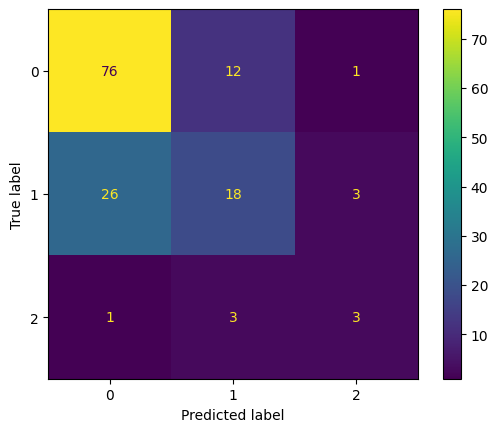

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.7622377622377622 , 0.7298430735930735 , 0.7620910163283044 , 0.7622377622377622


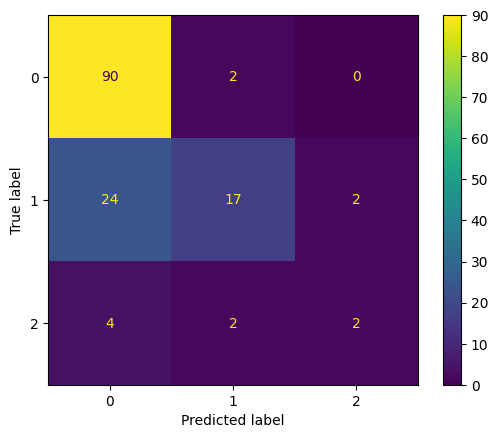

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.7412587412587412 , 0.7465426880811495 , 0.7533338754268987 , 0.7412587412587412


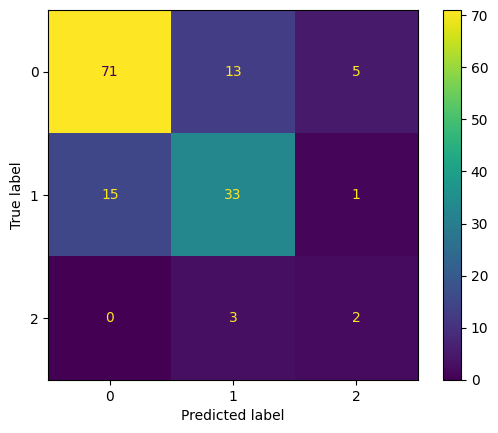

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.7132867132867133 , 0.6894731813404552 , 0.6912039212434469 , 0.7132867132867133


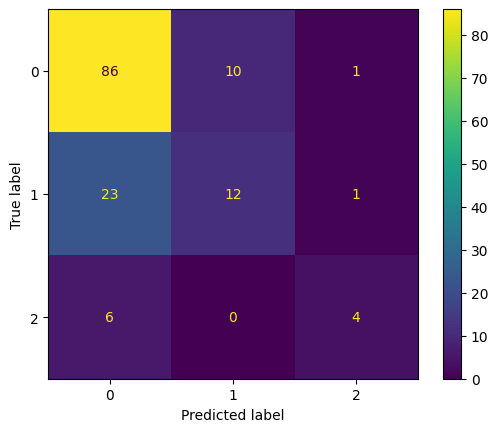

AdaBoostClassifier() , 0.6433566433566433 , 0.6291785137938984 , 0.6455602933651714 , 0.6433566433566433


C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


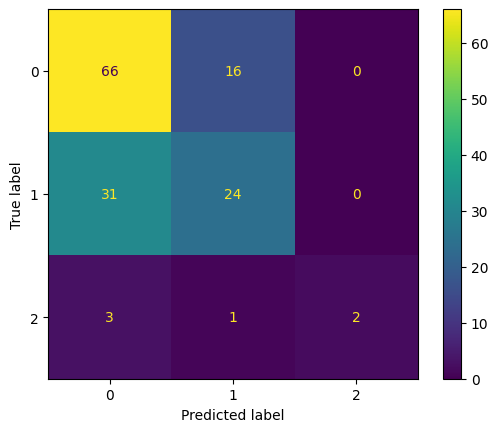

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.7412587412587412 , 0.7297465561409002 , 0.7248751248751248 , 0.7412587412587412


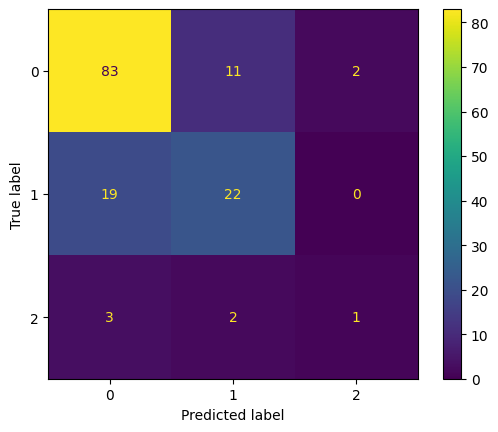

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.6573426573426573 , 0.595711571788127 , 0.6852149091603186 , 0.6573426573426573


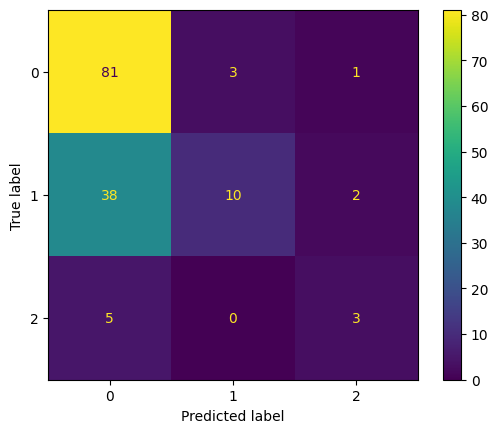

C:\Users\Kelvin Cipta\AppData\Local\Temp\ipykernel_5636\3247826837.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df=accuracy_df.append({


AdaBoostClassifier() , 0.7132867132867133 , 0.6685915144236863 , 0.727278760928459 , 0.7132867132867133


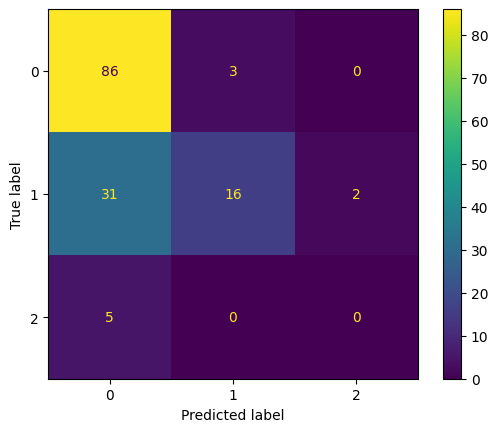

Average Accuracy Score: 0.6979020979020979 

Training Data Size:  715
Training Test Size:  20.0 %
Model used: RandomForestClassifier model. Accuracy: 0.8356643356643356
Data Saved to predicted.csv
Excecution time:  85.34152555465698


,Id,Search Keyword,URL,Datetime,Tweet,Username,View Count,Reply Count,Retweet Count,Like Count,...,Kota,Clean,Exclamation Mark,Question Mark,Upper Percentage,Positive Emoji,Neutral Emoji,Negative Emoji,Label,Training Label
0,1608941325113774080,PPN Naik,https://twitter.com/andi_hpattera/status/16089...,2022-12-30 21:41:19,"Kslo mau naik byk lg naikkan lg PPN jadi 12,5%...",andi_hpattera,8,0,0,0,...,NaN,ppn positivemoji positivemoji positive...,0,0,0.055556,3,0,0,0.0,NaN
1,1608824705276063746,PPN Naik,https://twitter.com/stephanusn/status/16088247...,2022-12-30 13:57:54,"@prastow Bayar pajak, lapor sendiri\nValidasi,...",stephanusn,391,0,0,4,...,NaN,bayar pajak lapor validasi lapor target pe...,0,0,0.026087,0,0,0,1.0,NaN
2,1608682909761949696,PPN Naik,https://twitter.com/andi_hpattera/status/16086...,2022-12-30 04:34:28,Setelah thn ini berhasil tercapai 110% yg lbh ...,andi_hpattera,12,0,0,0,...,NaN,hasil capai ppn biar bs capai te...,0,1,0.025641,0,0,0,0.0,NaN
3,1608666864628158466,PPN Naik,https://twitter.com/HestiBambang/status/160866...,2022-12-30 03:30:42,Jika Pemerintah tetapkan UMN setara KHL/PTKP R...,HestiBambang,26,0,0,0,...,NaN,perintah umn tara khl ptkp rupiah juta bln ...,0,0,0.109155,0,0,0,0.0,NaN
4,1608487033860915203,PPN Naik,https://twitter.com/marizalass/status/16084870...,2022-12-29 15:36:07,@IndiHomeJBN +ppn 11% = 327.450 ya bang? itu b...,marizalass,32,0,0,0,...,NaN,ppn ya bang biaya flat gaada tarif,0,3,0.052632,0,0,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27309,1289402360406532098,Tarif baru PPN,https://twitter.com/VIVAcoid/status/1289402360...,2020-08-01 03:27:33,"Kena PPN, Ini Tarif Baru Langganan Netflix htt...",VIVAcoid,0,0,0,0,...,NaN,kena ppn tarif langgan netflix,0,0,0.196970,0,0,0,0.0,NaN
27310,1288775814851383296,Tarif baru PPN,https://twitter.com/RadarKorupsi/status/128877...,2020-07-30 09:57:53,terlalu dibesar-2kan. lagi pula BB nya 61 jt. ...,RadarKorupsi,0,0,1,1,...,NaN,bb nya juta dg selundup harley pake pes...,0,3,0.079137,0,1,0,1.0,NaN
27311,1280992817007915008,Tarif baru PPN,https://twitter.com/hmzailanispog/status/12809...,2020-07-08 22:31:01,@Dennysiregar7 @PBIDI SE terbit hari ini. Test...,hmzailanispog,0,0,0,0,...,NaN,terbit test kit plus ppn arti rumah sa...,0,0,0.085837,0,0,0,0.0,NaN
27312,1279055985802276866,Tarif baru PPN,https://twitter.com/dewantara_adhi/status/1279...,2020-07-03 14:14:45,"@pln_123 Enak mah kalau yg 450, bisa gratis. k...",dewantara_adhi,0,0,0,0,...,NaN,enak mah gratis gede tarif dipalakin angk...,0,0,0.048860,0,0,0,0.0,NaN


In [2]:
#Predict Data
startTime=time.time()

#Load Data
clean=pd.read_csv('data/clean.csv')
labeled=pd.read_csv('data/labeled.csv') #Labeled Data

# Creating/Edit Feature to Predict
df=labeled.copy()
vect=TfidfVectorizer(max_features=750,ngram_range=(1,3))
V=vect.fit_transform(df["Clean"])
features=vect.get_feature_names_out()
tfidf_data=pd.DataFrame(V.toarray(),columns=features)
df=df.join(tfidf_data)
df["Exclamation Mark"]=[i.count("!") for i in df["Tweet"]]
df["Question Mark"]=[i.count("?") for i in df["Tweet"]]
df["Upper Percentage"]=[len(re.findall('[A-Z]',i))/len(i) for i in df["Tweet"]]
df["Positive Emoji"]=[str(i).count("positivemoji") for i in clean["Clean"]]
df["Neutral Emoji"]=[str(i).count("neutralmoji") for i in clean["Clean"]]
df["Negative Emoji"]=[str(i).count("negativemoji") for i in clean["Clean"]]
df.insert(len(df.columns)-1, "Label", df.pop("Label"))

#Select Feature and Target to Predict
train_data=df[df["Label"].notnull()].copy()
train_data=train_data.iloc[:,28:]

data_to_predict=df.copy()
data_to_predict["Label"]=None
data_to_predict=data_to_predict.iloc[:,28:]

#Direct Data Predict and Training Labled Data
predicted=df.iloc[:,0:28].join(df.iloc[:,-7:]).copy()
predicted.insert(len(predicted.columns)-1, "Label", predicted.pop("Label"))
prediction=Analyzer().predict(train_data,data_to_predict)
predicted["Training Label"]=train_data["Label"]
predicted["Label"]=prediction
predicted.to_csv('data/predicted.csv',index=False)
print("Data Saved to predicted.csv")

print("Excecution time: ",time.time()-startTime)
predicted

In [3]:
## Explore Data

# data=pd.read_csv('data/2023-02-28 19.36.57.730834 PPN Naik.csv')
# data=pd.read_csv('data/clean.csv')
# data=pd.read_csv('data/labeled.csv')
# data

accuracy_data=predicted.loc[:,["Label","Training Label"]]
accuracy_data=accuracy_data[accuracy_data["Training Label"].notnull()]
print("Accuracy Score: ",accuracy_score(accuracy_data["Training Label"],accuracy_data["Label"]))
print("Precision Score: ",precision_score(accuracy_data["Training Label"],accuracy_data["Label"],average='weighted'))
print("F1 Score: ",f1_score(accuracy_data["Training Label"],accuracy_data["Label"],average='weighted'))
print("Recall Score: ",recall_score(accuracy_data["Training Label"],accuracy_data["Label"],average='weighted'))

predicted[predicted["Training Label"].notnull()]
# cm=confusion_matrix(accuracy_data["Training Label"],accuracy_data["Label"]) 
# ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2]).plot()


Accuracy Score:  0.9986013986013986
Precision Score:  0.9986044928522804
F1 Score:  0.9986006293106247
Recall Score:  0.9986013986013986


,Id,Search Keyword,URL,Datetime,Tweet,Username,View Count,Reply Count,Retweet Count,Like Count,...,Kota,Clean,Exclamation Mark,Question Mark,Upper Percentage,Positive Emoji,Neutral Emoji,Negative Emoji,Label,Training Label
20,1607626348889264128,PPN Naik,https://twitter.com/nadalahnada13/status/16076...,2022-12-27 06:36:04,Hallo buos @IndiHome sejak oktober emang biaya...,nadalahnada13,132,2,0,0,...,NaN,hallo buos oktober emang biaya ppn nya ya ...,0,1,0.080000,0,0,0,0.0,0.0
118,1593910773436194816,PPN Naik,https://twitter.com/jyvmil/status/159391077343...,2022-11-19 10:15:16,@parcxarin Katanya rencana sebelum 2025 ppn ma...,jyvmil,0,1,0,0,...,NaN,rencana ppn negativemoji,0,0,0.016949,0,0,1,1.0,1.0
140,1589118493659889670,PPN Naik,https://twitter.com/harie_mhd/status/158911849...,2022-11-06 04:52:27,"@VIVAcoid Siap² BBM naik, cukai naik, PPn PPh,...",harie_mhd,0,0,0,0,...,NaN,bbm cukai ppn pph pajak ranmor,0,0,0.212121,0,0,0,0.0,0.0
268,1571500142473388033,PPN Naik,https://twitter.com/susiloyhu/status/157150014...,2022-09-18 14:03:25,"@dapitdong hahahaaa tak terasa sdh hancur, dar...",susiloyhu,0,0,3,3,...,NaN,hahahaaa asa hancur sektor ekonomi sehat ra...,0,10,0.030151,0,0,0,1.0,1.0
274,1571040948720902146,PPN Naik,https://twitter.com/ernrntr/status/15710409487...,2022-09-17 07:38:45,"another insight is, PPN naik 12% di 2025 (klo ...",ernrntr,0,1,0,0,...,NaN,another insight is ppn salah inget jadiii ...,0,0,0.031579,0,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27165,1525668908749160449,Tarif baru PPN,https://twitter.com/EnforceA_info/status/15256...,2022-05-15 02:46:28,PPN Kegiatan Membangun Sendiri (PPN KMS) bukan...,EnforceA_info,0,0,0,3,...,NaN,ppn giat bangun ppn kms rupa pajak pajak ...,0,0,0.115830,0,0,0,0.0,0.0
27173,1516686837368201216,Tarif baru PPN,https://twitter.com/pajakpbg/status/1516686837...,2022-04-20 07:54:55,RT @pajak4lawang: Halo #kawanPajak\nBelajar ba...,pajakpbg,0,0,0,0,...,NaN,rt halo ajar bareng yuk live instagram tangg...,0,0,0.094545,0,0,0,0.0,0.0
27238,1506520768200335362,Tarif baru PPN,https://twitter.com/kring_pajak/status/1506520...,2022-03-23 06:38:35,@Alvin26516522 sebelum dimulainya pemanfaatan ...,kring_pajak,0,1,0,0,...,NaN,manfaat bkp wujud jkp daerah pabean uta...,0,0,0.076336,0,0,0,0.0,0.0
27273,1403692859925032966,Tarif baru PPN,https://twitter.com/ImanTangankanan/status/140...,2021-06-12 12:37:11,@DitjenPajakRI Odal adil odal adil.\nGombalmuk...,ImanTangankanan,0,0,3,4,...,NaN,odal adil odal adil gombalmukio adil beli mo...,0,0,0.100962,0,0,0,1.0,1.0


In [2]:
#Cleaning Data
# startTime=time.time()
# data=clean_data()
# data=pd.read_csv("data/clean.csv")
# print("Excecution time: ",time.time()-startTime)


1 / 27314  Preprocess Complete
2 / 27314  Preprocess Complete
3 / 27314  Preprocess Complete
4 / 27314  Preprocess Complete
5 / 27314  Preprocess Complete
6 / 27314  Preprocess Complete
7 / 27314  Preprocess Complete
8 / 27314  Preprocess Complete
9 / 27314  Preprocess Complete
10 / 27314  Preprocess Complete
11 / 27314  Preprocess Complete
12 / 27314  Preprocess Complete
13 / 27314  Preprocess Complete
14 / 27314  Preprocess Complete
15 / 27314  Preprocess Complete
16 / 27314  Preprocess Complete
17 / 27314  Preprocess Complete
18 / 27314  Preprocess Complete
19 / 27314  Preprocess Complete
20 / 27314  Preprocess Complete
21 / 27314  Preprocess Complete
22 / 27314  Preprocess Complete
23 / 27314  Preprocess Complete
24 / 27314  Preprocess Complete
25 / 27314  Preprocess Complete
26 / 27314  Preprocess Complete
27 / 27314  Preprocess Complete
28 / 27314  Preprocess Complete
29 / 27314  Preprocess Complete
30 / 27314  Preprocess Complete
31 / 27314  Preprocess Complete
32 / 27314  Prepr

253 / 27314  Preprocess Complete
254 / 27314  Preprocess Complete
255 / 27314  Preprocess Complete
256 / 27314  Preprocess Complete
257 / 27314  Preprocess Complete
258 / 27314  Preprocess Complete
259 / 27314  Preprocess Complete
260 / 27314  Preprocess Complete
261 / 27314  Preprocess Complete
262 / 27314  Preprocess Complete
263 / 27314  Preprocess Complete
264 / 27314  Preprocess Complete
265 / 27314  Preprocess Complete
266 / 27314  Preprocess Complete
267 / 27314  Preprocess Complete
268 / 27314  Preprocess Complete
269 / 27314  Preprocess Complete
270 / 27314  Preprocess Complete
271 / 27314  Preprocess Complete
272 / 27314  Preprocess Complete
273 / 27314  Preprocess Complete
274 / 27314  Preprocess Complete
275 / 27314  Preprocess Complete
276 / 27314  Preprocess Complete
277 / 27314  Preprocess Complete
278 / 27314  Preprocess Complete
279 / 27314  Preprocess Complete
280 / 27314  Preprocess Complete
281 / 27314  Preprocess Complete
282 / 27314  Preprocess Complete
283 / 2731

502 / 27314  Preprocess Complete
503 / 27314  Preprocess Complete
504 / 27314  Preprocess Complete
505 / 27314  Preprocess Complete
506 / 27314  Preprocess Complete
507 / 27314  Preprocess Complete
508 / 27314  Preprocess Complete
509 / 27314  Preprocess Complete
510 / 27314  Preprocess Complete
511 / 27314  Preprocess Complete
512 / 27314  Preprocess Complete
513 / 27314  Preprocess Complete
514 / 27314  Preprocess Complete
515 / 27314  Preprocess Complete
516 / 27314  Preprocess Complete
517 / 27314  Preprocess Complete
518 / 27314  Preprocess Complete
519 / 27314  Preprocess Complete
520 / 27314  Preprocess Complete
521 / 27314  Preprocess Complete
522 / 27314  Preprocess Complete
523 / 27314  Preprocess Complete
524 / 27314  Preprocess Complete
525 / 27314  Preprocess Complete
526 / 27314  Preprocess Complete
527 / 27314  Preprocess Complete
528 / 27314  Preprocess Complete
529 / 27314  Preprocess Complete
530 / 27314  Preprocess Complete
531 / 27314  Preprocess Complete
532 / 2731

751 / 27314  Preprocess Complete
752 / 27314  Preprocess Complete
753 / 27314  Preprocess Complete
754 / 27314  Preprocess Complete
755 / 27314  Preprocess Complete
756 / 27314  Preprocess Complete
757 / 27314  Preprocess Complete
758 / 27314  Preprocess Complete
759 / 27314  Preprocess Complete
760 / 27314  Preprocess Complete
761 / 27314  Preprocess Complete
762 / 27314  Preprocess Complete
763 / 27314  Preprocess Complete
764 / 27314  Preprocess Complete
765 / 27314  Preprocess Complete
766 / 27314  Preprocess Complete
767 / 27314  Preprocess Complete
768 / 27314  Preprocess Complete
769 / 27314  Preprocess Complete
770 / 27314  Preprocess Complete
771 / 27314  Preprocess Complete
772 / 27314  Preprocess Complete
773 / 27314  Preprocess Complete
774 / 27314  Preprocess Complete
775 / 27314  Preprocess Complete
776 / 27314  Preprocess Complete
777 / 27314  Preprocess Complete
778 / 27314  Preprocess Complete
779 / 27314  Preprocess Complete
780 / 27314  Preprocess Complete
781 / 2731

1000 / 27314  Preprocess Complete
1001 / 27314  Preprocess Complete
1002 / 27314  Preprocess Complete
1003 / 27314  Preprocess Complete
1004 / 27314  Preprocess Complete
1005 / 27314  Preprocess Complete
1006 / 27314  Preprocess Complete
1007 / 27314  Preprocess Complete
1008 / 27314  Preprocess Complete
1009 / 27314  Preprocess Complete
1010 / 27314  Preprocess Complete
1011 / 27314  Preprocess Complete
1012 / 27314  Preprocess Complete
1013 / 27314  Preprocess Complete
1014 / 27314  Preprocess Complete
1015 / 27314  Preprocess Complete
1016 / 27314  Preprocess Complete
1017 / 27314  Preprocess Complete
1018 / 27314  Preprocess Complete
1019 / 27314  Preprocess Complete
1020 / 27314  Preprocess Complete
1021 / 27314  Preprocess Complete
1022 / 27314  Preprocess Complete
1023 / 27314  Preprocess Complete
1024 / 27314  Preprocess Complete
1025 / 27314  Preprocess Complete
1026 / 27314  Preprocess Complete
1027 / 27314  Preprocess Complete
1028 / 27314  Preprocess Complete
1029 / 27314  

1241 / 27314  Preprocess Complete
1242 / 27314  Preprocess Complete
1243 / 27314  Preprocess Complete
1244 / 27314  Preprocess Complete
1245 / 27314  Preprocess Complete
1246 / 27314  Preprocess Complete
1247 / 27314  Preprocess Complete
1248 / 27314  Preprocess Complete
1249 / 27314  Preprocess Complete
1250 / 27314  Preprocess Complete
1251 / 27314  Preprocess Complete
1252 / 27314  Preprocess Complete
1253 / 27314  Preprocess Complete
1254 / 27314  Preprocess Complete
1255 / 27314  Preprocess Complete
1256 / 27314  Preprocess Complete
1257 / 27314  Preprocess Complete
1258 / 27314  Preprocess Complete
1259 / 27314  Preprocess Complete
1260 / 27314  Preprocess Complete
1261 / 27314  Preprocess Complete
1262 / 27314  Preprocess Complete
1263 / 27314  Preprocess Complete
1264 / 27314  Preprocess Complete
1265 / 27314  Preprocess Complete
1266 / 27314  Preprocess Complete
1267 / 27314  Preprocess Complete
1268 / 27314  Preprocess Complete
1269 / 27314  Preprocess Complete
1270 / 27314  

1484 / 27314  Preprocess Complete
1485 / 27314  Preprocess Complete
1486 / 27314  Preprocess Complete
1487 / 27314  Preprocess Complete
1488 / 27314  Preprocess Complete
1489 / 27314  Preprocess Complete
1490 / 27314  Preprocess Complete
1491 / 27314  Preprocess Complete
1492 / 27314  Preprocess Complete
1493 / 27314  Preprocess Complete
1494 / 27314  Preprocess Complete
1495 / 27314  Preprocess Complete
1496 / 27314  Preprocess Complete
1497 / 27314  Preprocess Complete
1498 / 27314  Preprocess Complete
1499 / 27314  Preprocess Complete
1500 / 27314  Preprocess Complete
1501 / 27314  Preprocess Complete
1502 / 27314  Preprocess Complete
1503 / 27314  Preprocess Complete
1504 / 27314  Preprocess Complete
1505 / 27314  Preprocess Complete
1506 / 27314  Preprocess Complete
1507 / 27314  Preprocess Complete
1508 / 27314  Preprocess Complete
1509 / 27314  Preprocess Complete
1510 / 27314  Preprocess Complete
1511 / 27314  Preprocess Complete
1512 / 27314  Preprocess Complete
1513 / 27314  

1725 / 27314  Preprocess Complete
1726 / 27314  Preprocess Complete
1727 / 27314  Preprocess Complete
1728 / 27314  Preprocess Complete
1729 / 27314  Preprocess Complete
1730 / 27314  Preprocess Complete
1731 / 27314  Preprocess Complete
1732 / 27314  Preprocess Complete
1733 / 27314  Preprocess Complete
1734 / 27314  Preprocess Complete
1735 / 27314  Preprocess Complete
1736 / 27314  Preprocess Complete
1737 / 27314  Preprocess Complete
1738 / 27314  Preprocess Complete
1739 / 27314  Preprocess Complete
1740 / 27314  Preprocess Complete
1741 / 27314  Preprocess Complete
1742 / 27314  Preprocess Complete
1743 / 27314  Preprocess Complete
1744 / 27314  Preprocess Complete
1745 / 27314  Preprocess Complete
1746 / 27314  Preprocess Complete
1747 / 27314  Preprocess Complete
1748 / 27314  Preprocess Complete
1749 / 27314  Preprocess Complete
1750 / 27314  Preprocess Complete
1751 / 27314  Preprocess Complete
1752 / 27314  Preprocess Complete
1753 / 27314  Preprocess Complete
1754 / 27314  

1966 / 27314  Preprocess Complete
1967 / 27314  Preprocess Complete
1968 / 27314  Preprocess Complete
1969 / 27314  Preprocess Complete
1970 / 27314  Preprocess Complete
1971 / 27314  Preprocess Complete
1972 / 27314  Preprocess Complete
1973 / 27314  Preprocess Complete
1974 / 27314  Preprocess Complete
1975 / 27314  Preprocess Complete
1976 / 27314  Preprocess Complete
1977 / 27314  Preprocess Complete
1978 / 27314  Preprocess Complete
1979 / 27314  Preprocess Complete
1980 / 27314  Preprocess Complete
1981 / 27314  Preprocess Complete
1982 / 27314  Preprocess Complete
1983 / 27314  Preprocess Complete
1984 / 27314  Preprocess Complete
1985 / 27314  Preprocess Complete
1986 / 27314  Preprocess Complete
1987 / 27314  Preprocess Complete
1988 / 27314  Preprocess Complete
1989 / 27314  Preprocess Complete
1990 / 27314  Preprocess Complete
1991 / 27314  Preprocess Complete
1992 / 27314  Preprocess Complete
1993 / 27314  Preprocess Complete
1994 / 27314  Preprocess Complete
1995 / 27314  

2208 / 27314  Preprocess Complete
2209 / 27314  Preprocess Complete
2210 / 27314  Preprocess Complete
2211 / 27314  Preprocess Complete
2212 / 27314  Preprocess Complete
2213 / 27314  Preprocess Complete
2214 / 27314  Preprocess Complete
2215 / 27314  Preprocess Complete
2216 / 27314  Preprocess Complete
2217 / 27314  Preprocess Complete
2218 / 27314  Preprocess Complete
2219 / 27314  Preprocess Complete
2220 / 27314  Preprocess Complete
2221 / 27314  Preprocess Complete
2222 / 27314  Preprocess Complete
2223 / 27314  Preprocess Complete
2224 / 27314  Preprocess Complete
2225 / 27314  Preprocess Complete
2226 / 27314  Preprocess Complete
2227 / 27314  Preprocess Complete
2228 / 27314  Preprocess Complete
2229 / 27314  Preprocess Complete
2230 / 27314  Preprocess Complete
2231 / 27314  Preprocess Complete
2232 / 27314  Preprocess Complete
2233 / 27314  Preprocess Complete
2234 / 27314  Preprocess Complete
2235 / 27314  Preprocess Complete
2236 / 27314  Preprocess Complete
2237 / 27314  

2449 / 27314  Preprocess Complete
2450 / 27314  Preprocess Complete
2451 / 27314  Preprocess Complete
2452 / 27314  Preprocess Complete
2453 / 27314  Preprocess Complete
2454 / 27314  Preprocess Complete
2455 / 27314  Preprocess Complete
2456 / 27314  Preprocess Complete
2457 / 27314  Preprocess Complete
2458 / 27314  Preprocess Complete
2459 / 27314  Preprocess Complete
2460 / 27314  Preprocess Complete
2461 / 27314  Preprocess Complete
2462 / 27314  Preprocess Complete
2463 / 27314  Preprocess Complete
2464 / 27314  Preprocess Complete
2465 / 27314  Preprocess Complete
2466 / 27314  Preprocess Complete
2467 / 27314  Preprocess Complete
2468 / 27314  Preprocess Complete
2469 / 27314  Preprocess Complete
2470 / 27314  Preprocess Complete
2471 / 27314  Preprocess Complete
2472 / 27314  Preprocess Complete
2473 / 27314  Preprocess Complete
2474 / 27314  Preprocess Complete
2475 / 27314  Preprocess Complete
2476 / 27314  Preprocess Complete
2477 / 27314  Preprocess Complete
2478 / 27314  

2690 / 27314  Preprocess Complete
2691 / 27314  Preprocess Complete
2692 / 27314  Preprocess Complete
2693 / 27314  Preprocess Complete
2694 / 27314  Preprocess Complete
2695 / 27314  Preprocess Complete
2696 / 27314  Preprocess Complete
2697 / 27314  Preprocess Complete
2698 / 27314  Preprocess Complete
2699 / 27314  Preprocess Complete
2700 / 27314  Preprocess Complete
2701 / 27314  Preprocess Complete
2702 / 27314  Preprocess Complete
2703 / 27314  Preprocess Complete
2704 / 27314  Preprocess Complete
2705 / 27314  Preprocess Complete
2706 / 27314  Preprocess Complete
2707 / 27314  Preprocess Complete
2708 / 27314  Preprocess Complete
2709 / 27314  Preprocess Complete
2710 / 27314  Preprocess Complete
2711 / 27314  Preprocess Complete
2712 / 27314  Preprocess Complete
2713 / 27314  Preprocess Complete
2714 / 27314  Preprocess Complete
2715 / 27314  Preprocess Complete
2716 / 27314  Preprocess Complete
2717 / 27314  Preprocess Complete
2718 / 27314  Preprocess Complete
2719 / 27314  

2931 / 27314  Preprocess Complete
2932 / 27314  Preprocess Complete
2933 / 27314  Preprocess Complete
2934 / 27314  Preprocess Complete
2935 / 27314  Preprocess Complete
2936 / 27314  Preprocess Complete
2937 / 27314  Preprocess Complete
2938 / 27314  Preprocess Complete
2939 / 27314  Preprocess Complete
2940 / 27314  Preprocess Complete
2941 / 27314  Preprocess Complete
2942 / 27314  Preprocess Complete
2943 / 27314  Preprocess Complete
2944 / 27314  Preprocess Complete
2945 / 27314  Preprocess Complete
2946 / 27314  Preprocess Complete
2947 / 27314  Preprocess Complete
2948 / 27314  Preprocess Complete
2949 / 27314  Preprocess Complete
2950 / 27314  Preprocess Complete
2951 / 27314  Preprocess Complete
2952 / 27314  Preprocess Complete
2953 / 27314  Preprocess Complete
2954 / 27314  Preprocess Complete
2955 / 27314  Preprocess Complete
2956 / 27314  Preprocess Complete
2957 / 27314  Preprocess Complete
2958 / 27314  Preprocess Complete
2959 / 27314  Preprocess Complete
2960 / 27314  

3172 / 27314  Preprocess Complete
3173 / 27314  Preprocess Complete
3174 / 27314  Preprocess Complete
3175 / 27314  Preprocess Complete
3176 / 27314  Preprocess Complete
3177 / 27314  Preprocess Complete
3178 / 27314  Preprocess Complete
3179 / 27314  Preprocess Complete
3180 / 27314  Preprocess Complete
3181 / 27314  Preprocess Complete
3182 / 27314  Preprocess Complete
3183 / 27314  Preprocess Complete
3184 / 27314  Preprocess Complete
3185 / 27314  Preprocess Complete
3186 / 27314  Preprocess Complete
3187 / 27314  Preprocess Complete
3188 / 27314  Preprocess Complete
3189 / 27314  Preprocess Complete
3190 / 27314  Preprocess Complete
3191 / 27314  Preprocess Complete
3192 / 27314  Preprocess Complete
3193 / 27314  Preprocess Complete
3194 / 27314  Preprocess Complete
3195 / 27314  Preprocess Complete
3196 / 27314  Preprocess Complete
3197 / 27314  Preprocess Complete
3198 / 27314  Preprocess Complete
3199 / 27314  Preprocess Complete
3200 / 27314  Preprocess Complete
3201 / 27314  

3413 / 27314  Preprocess Complete
3414 / 27314  Preprocess Complete
3415 / 27314  Preprocess Complete
3416 / 27314  Preprocess Complete
3417 / 27314  Preprocess Complete
3418 / 27314  Preprocess Complete
3419 / 27314  Preprocess Complete
3420 / 27314  Preprocess Complete
3421 / 27314  Preprocess Complete
3422 / 27314  Preprocess Complete
3423 / 27314  Preprocess Complete
3424 / 27314  Preprocess Complete
3425 / 27314  Preprocess Complete
3426 / 27314  Preprocess Complete
3427 / 27314  Preprocess Complete
3428 / 27314  Preprocess Complete
3429 / 27314  Preprocess Complete
3430 / 27314  Preprocess Complete
3431 / 27314  Preprocess Complete
3432 / 27314  Preprocess Complete
3433 / 27314  Preprocess Complete
3434 / 27314  Preprocess Complete
3435 / 27314  Preprocess Complete
3436 / 27314  Preprocess Complete
3437 / 27314  Preprocess Complete
3438 / 27314  Preprocess Complete
3439 / 27314  Preprocess Complete
3440 / 27314  Preprocess Complete
3441 / 27314  Preprocess Complete
3442 / 27314  

3655 / 27314  Preprocess Complete
3656 / 27314  Preprocess Complete
3657 / 27314  Preprocess Complete
3658 / 27314  Preprocess Complete
3659 / 27314  Preprocess Complete
3660 / 27314  Preprocess Complete
3661 / 27314  Preprocess Complete
3662 / 27314  Preprocess Complete
3663 / 27314  Preprocess Complete
3664 / 27314  Preprocess Complete
3665 / 27314  Preprocess Complete
3666 / 27314  Preprocess Complete
3667 / 27314  Preprocess Complete
3668 / 27314  Preprocess Complete
3669 / 27314  Preprocess Complete
3670 / 27314  Preprocess Complete
3671 / 27314  Preprocess Complete
3672 / 27314  Preprocess Complete
3673 / 27314  Preprocess Complete
3674 / 27314  Preprocess Complete
3675 / 27314  Preprocess Complete
3676 / 27314  Preprocess Complete
3677 / 27314  Preprocess Complete
3678 / 27314  Preprocess Complete
3679 / 27314  Preprocess Complete
3680 / 27314  Preprocess Complete
3681 / 27314  Preprocess Complete
3682 / 27314  Preprocess Complete
3683 / 27314  Preprocess Complete
3684 / 27314  

3896 / 27314  Preprocess Complete
3897 / 27314  Preprocess Complete
3898 / 27314  Preprocess Complete
3899 / 27314  Preprocess Complete
3900 / 27314  Preprocess Complete
3901 / 27314  Preprocess Complete
3902 / 27314  Preprocess Complete
3903 / 27314  Preprocess Complete
3904 / 27314  Preprocess Complete
3905 / 27314  Preprocess Complete
3906 / 27314  Preprocess Complete
3907 / 27314  Preprocess Complete
3908 / 27314  Preprocess Complete
3909 / 27314  Preprocess Complete
3910 / 27314  Preprocess Complete
3911 / 27314  Preprocess Complete
3912 / 27314  Preprocess Complete
3913 / 27314  Preprocess Complete
3914 / 27314  Preprocess Complete
3915 / 27314  Preprocess Complete
3916 / 27314  Preprocess Complete
3917 / 27314  Preprocess Complete
3918 / 27314  Preprocess Complete
3919 / 27314  Preprocess Complete
3920 / 27314  Preprocess Complete
3921 / 27314  Preprocess Complete
3922 / 27314  Preprocess Complete
3923 / 27314  Preprocess Complete
3924 / 27314  Preprocess Complete
3925 / 27314  

4137 / 27314  Preprocess Complete
4138 / 27314  Preprocess Complete
4139 / 27314  Preprocess Complete
4140 / 27314  Preprocess Complete
4141 / 27314  Preprocess Complete
4142 / 27314  Preprocess Complete
4143 / 27314  Preprocess Complete
4144 / 27314  Preprocess Complete
4145 / 27314  Preprocess Complete
4146 / 27314  Preprocess Complete
4147 / 27314  Preprocess Complete
4148 / 27314  Preprocess Complete
4149 / 27314  Preprocess Complete
4150 / 27314  Preprocess Complete
4151 / 27314  Preprocess Complete
4152 / 27314  Preprocess Complete
4153 / 27314  Preprocess Complete
4154 / 27314  Preprocess Complete
4155 / 27314  Preprocess Complete
4156 / 27314  Preprocess Complete
4157 / 27314  Preprocess Complete
4158 / 27314  Preprocess Complete
4159 / 27314  Preprocess Complete
4160 / 27314  Preprocess Complete
4161 / 27314  Preprocess Complete
4162 / 27314  Preprocess Complete
4163 / 27314  Preprocess Complete
4164 / 27314  Preprocess Complete
4165 / 27314  Preprocess Complete
4166 / 27314  

4378 / 27314  Preprocess Complete
4379 / 27314  Preprocess Complete
4380 / 27314  Preprocess Complete
4381 / 27314  Preprocess Complete
4382 / 27314  Preprocess Complete
4383 / 27314  Preprocess Complete
4384 / 27314  Preprocess Complete
4385 / 27314  Preprocess Complete
4386 / 27314  Preprocess Complete
4387 / 27314  Preprocess Complete
4388 / 27314  Preprocess Complete
4389 / 27314  Preprocess Complete
4390 / 27314  Preprocess Complete
4391 / 27314  Preprocess Complete
4392 / 27314  Preprocess Complete
4393 / 27314  Preprocess Complete
4394 / 27314  Preprocess Complete
4395 / 27314  Preprocess Complete
4396 / 27314  Preprocess Complete
4397 / 27314  Preprocess Complete
4398 / 27314  Preprocess Complete
4399 / 27314  Preprocess Complete
4400 / 27314  Preprocess Complete
4401 / 27314  Preprocess Complete
4402 / 27314  Preprocess Complete
4403 / 27314  Preprocess Complete
4404 / 27314  Preprocess Complete
4405 / 27314  Preprocess Complete
4406 / 27314  Preprocess Complete
4407 / 27314  

4621 / 27314  Preprocess Complete
4622 / 27314  Preprocess Complete
4623 / 27314  Preprocess Complete
4624 / 27314  Preprocess Complete
4625 / 27314  Preprocess Complete
4626 / 27314  Preprocess Complete
4627 / 27314  Preprocess Complete
4628 / 27314  Preprocess Complete
4629 / 27314  Preprocess Complete
4630 / 27314  Preprocess Complete
4631 / 27314  Preprocess Complete
4632 / 27314  Preprocess Complete
4633 / 27314  Preprocess Complete
4634 / 27314  Preprocess Complete
4635 / 27314  Preprocess Complete
4636 / 27314  Preprocess Complete
4637 / 27314  Preprocess Complete
4638 / 27314  Preprocess Complete
4639 / 27314  Preprocess Complete
4640 / 27314  Preprocess Complete
4641 / 27314  Preprocess Complete
4642 / 27314  Preprocess Complete
4643 / 27314  Preprocess Complete
4644 / 27314  Preprocess Complete
4645 / 27314  Preprocess Complete
4646 / 27314  Preprocess Complete
4647 / 27314  Preprocess Complete
4648 / 27314  Preprocess Complete
4649 / 27314  Preprocess Complete
4650 / 27314  

4862 / 27314  Preprocess Complete
4863 / 27314  Preprocess Complete
4864 / 27314  Preprocess Complete
4865 / 27314  Preprocess Complete
4866 / 27314  Preprocess Complete
4867 / 27314  Preprocess Complete
4868 / 27314  Preprocess Complete
4869 / 27314  Preprocess Complete
4870 / 27314  Preprocess Complete
4871 / 27314  Preprocess Complete
4872 / 27314  Preprocess Complete
4873 / 27314  Preprocess Complete
4874 / 27314  Preprocess Complete
4875 / 27314  Preprocess Complete
4876 / 27314  Preprocess Complete
4877 / 27314  Preprocess Complete
4878 / 27314  Preprocess Complete
4879 / 27314  Preprocess Complete
4880 / 27314  Preprocess Complete
4881 / 27314  Preprocess Complete
4882 / 27314  Preprocess Complete
4883 / 27314  Preprocess Complete
4884 / 27314  Preprocess Complete
4885 / 27314  Preprocess Complete
4886 / 27314  Preprocess Complete
4887 / 27314  Preprocess Complete
4888 / 27314  Preprocess Complete
4889 / 27314  Preprocess Complete
4890 / 27314  Preprocess Complete
4891 / 27314  

5104 / 27314  Preprocess Complete
5105 / 27314  Preprocess Complete
5106 / 27314  Preprocess Complete
5107 / 27314  Preprocess Complete
5108 / 27314  Preprocess Complete
5109 / 27314  Preprocess Complete
5110 / 27314  Preprocess Complete
5111 / 27314  Preprocess Complete
5112 / 27314  Preprocess Complete
5113 / 27314  Preprocess Complete
5114 / 27314  Preprocess Complete
5115 / 27314  Preprocess Complete
5116 / 27314  Preprocess Complete
5117 / 27314  Preprocess Complete
5118 / 27314  Preprocess Complete
5119 / 27314  Preprocess Complete
5120 / 27314  Preprocess Complete
5121 / 27314  Preprocess Complete
5122 / 27314  Preprocess Complete
5123 / 27314  Preprocess Complete
5124 / 27314  Preprocess Complete
5125 / 27314  Preprocess Complete
5126 / 27314  Preprocess Complete
5127 / 27314  Preprocess Complete
5128 / 27314  Preprocess Complete
5129 / 27314  Preprocess Complete
5130 / 27314  Preprocess Complete
5131 / 27314  Preprocess Complete
5132 / 27314  Preprocess Complete
5133 / 27314  

5345 / 27314  Preprocess Complete
5346 / 27314  Preprocess Complete
5347 / 27314  Preprocess Complete
5348 / 27314  Preprocess Complete
5349 / 27314  Preprocess Complete
5350 / 27314  Preprocess Complete
5351 / 27314  Preprocess Complete
5352 / 27314  Preprocess Complete
5353 / 27314  Preprocess Complete
5354 / 27314  Preprocess Complete
5355 / 27314  Preprocess Complete
5356 / 27314  Preprocess Complete
5357 / 27314  Preprocess Complete
5358 / 27314  Preprocess Complete
5359 / 27314  Preprocess Complete
5360 / 27314  Preprocess Complete
5361 / 27314  Preprocess Complete
5362 / 27314  Preprocess Complete
5363 / 27314  Preprocess Complete
5364 / 27314  Preprocess Complete
5365 / 27314  Preprocess Complete
5366 / 27314  Preprocess Complete
5367 / 27314  Preprocess Complete
5368 / 27314  Preprocess Complete
5369 / 27314  Preprocess Complete
5370 / 27314  Preprocess Complete
5371 / 27314  Preprocess Complete
5372 / 27314  Preprocess Complete
5373 / 27314  Preprocess Complete
5374 / 27314  

5586 / 27314  Preprocess Complete
5587 / 27314  Preprocess Complete
5588 / 27314  Preprocess Complete
5589 / 27314  Preprocess Complete
5590 / 27314  Preprocess Complete
5591 / 27314  Preprocess Complete
5592 / 27314  Preprocess Complete
5593 / 27314  Preprocess Complete
5594 / 27314  Preprocess Complete
5595 / 27314  Preprocess Complete
5596 / 27314  Preprocess Complete
5597 / 27314  Preprocess Complete
5598 / 27314  Preprocess Complete
5599 / 27314  Preprocess Complete
5600 / 27314  Preprocess Complete
5601 / 27314  Preprocess Complete
5602 / 27314  Preprocess Complete
5603 / 27314  Preprocess Complete
5604 / 27314  Preprocess Complete
5605 / 27314  Preprocess Complete
5606 / 27314  Preprocess Complete
5607 / 27314  Preprocess Complete
5608 / 27314  Preprocess Complete
5609 / 27314  Preprocess Complete
5610 / 27314  Preprocess Complete
5611 / 27314  Preprocess Complete
5612 / 27314  Preprocess Complete
5613 / 27314  Preprocess Complete
5614 / 27314  Preprocess Complete
5615 / 27314  

5827 / 27314  Preprocess Complete
5828 / 27314  Preprocess Complete
5829 / 27314  Preprocess Complete
5830 / 27314  Preprocess Complete
5831 / 27314  Preprocess Complete
5832 / 27314  Preprocess Complete
5833 / 27314  Preprocess Complete
5834 / 27314  Preprocess Complete
5835 / 27314  Preprocess Complete
5836 / 27314  Preprocess Complete
5837 / 27314  Preprocess Complete
5838 / 27314  Preprocess Complete
5839 / 27314  Preprocess Complete
5840 / 27314  Preprocess Complete
5841 / 27314  Preprocess Complete
5842 / 27314  Preprocess Complete
5843 / 27314  Preprocess Complete
5844 / 27314  Preprocess Complete
5845 / 27314  Preprocess Complete
5846 / 27314  Preprocess Complete
5847 / 27314  Preprocess Complete
5848 / 27314  Preprocess Complete
5849 / 27314  Preprocess Complete
5850 / 27314  Preprocess Complete
5851 / 27314  Preprocess Complete
5852 / 27314  Preprocess Complete
5853 / 27314  Preprocess Complete
5854 / 27314  Preprocess Complete
5855 / 27314  Preprocess Complete
5856 / 27314  

6069 / 27314  Preprocess Complete
6070 / 27314  Preprocess Complete
6071 / 27314  Preprocess Complete
6072 / 27314  Preprocess Complete
6073 / 27314  Preprocess Complete
6074 / 27314  Preprocess Complete
6075 / 27314  Preprocess Complete
6076 / 27314  Preprocess Complete
6077 / 27314  Preprocess Complete
6078 / 27314  Preprocess Complete
6079 / 27314  Preprocess Complete
6080 / 27314  Preprocess Complete
6081 / 27314  Preprocess Complete
6082 / 27314  Preprocess Complete
6083 / 27314  Preprocess Complete
6084 / 27314  Preprocess Complete
6085 / 27314  Preprocess Complete
6086 / 27314  Preprocess Complete
6087 / 27314  Preprocess Complete
6088 / 27314  Preprocess Complete
6089 / 27314  Preprocess Complete
6090 / 27314  Preprocess Complete
6091 / 27314  Preprocess Complete
6092 / 27314  Preprocess Complete
6093 / 27314  Preprocess Complete
6094 / 27314  Preprocess Complete
6095 / 27314  Preprocess Complete
6096 / 27314  Preprocess Complete
6097 / 27314  Preprocess Complete
6098 / 27314  

6310 / 27314  Preprocess Complete
6311 / 27314  Preprocess Complete
6312 / 27314  Preprocess Complete
6313 / 27314  Preprocess Complete
6314 / 27314  Preprocess Complete
6315 / 27314  Preprocess Complete
6316 / 27314  Preprocess Complete
6317 / 27314  Preprocess Complete
6318 / 27314  Preprocess Complete
6319 / 27314  Preprocess Complete
6320 / 27314  Preprocess Complete
6321 / 27314  Preprocess Complete
6322 / 27314  Preprocess Complete
6323 / 27314  Preprocess Complete
6324 / 27314  Preprocess Complete
6325 / 27314  Preprocess Complete
6326 / 27314  Preprocess Complete
6327 / 27314  Preprocess Complete
6328 / 27314  Preprocess Complete
6329 / 27314  Preprocess Complete
6330 / 27314  Preprocess Complete
6331 / 27314  Preprocess Complete
6332 / 27314  Preprocess Complete
6333 / 27314  Preprocess Complete
6334 / 27314  Preprocess Complete
6335 / 27314  Preprocess Complete
6336 / 27314  Preprocess Complete
6337 / 27314  Preprocess Complete
6338 / 27314  Preprocess Complete
6339 / 27314  

6551 / 27314  Preprocess Complete
6552 / 27314  Preprocess Complete
6553 / 27314  Preprocess Complete
6554 / 27314  Preprocess Complete
6555 / 27314  Preprocess Complete
6556 / 27314  Preprocess Complete
6557 / 27314  Preprocess Complete
6558 / 27314  Preprocess Complete
6559 / 27314  Preprocess Complete
6560 / 27314  Preprocess Complete
6561 / 27314  Preprocess Complete
6562 / 27314  Preprocess Complete
6563 / 27314  Preprocess Complete
6564 / 27314  Preprocess Complete
6565 / 27314  Preprocess Complete
6566 / 27314  Preprocess Complete
6567 / 27314  Preprocess Complete
6568 / 27314  Preprocess Complete
6569 / 27314  Preprocess Complete
6570 / 27314  Preprocess Complete
6571 / 27314  Preprocess Complete
6572 / 27314  Preprocess Complete
6573 / 27314  Preprocess Complete
6574 / 27314  Preprocess Complete
6575 / 27314  Preprocess Complete
6576 / 27314  Preprocess Complete
6577 / 27314  Preprocess Complete
6578 / 27314  Preprocess Complete
6579 / 27314  Preprocess Complete
6580 / 27314  

6793 / 27314  Preprocess Complete
6794 / 27314  Preprocess Complete
6795 / 27314  Preprocess Complete
6796 / 27314  Preprocess Complete
6797 / 27314  Preprocess Complete
6798 / 27314  Preprocess Complete
6799 / 27314  Preprocess Complete
6800 / 27314  Preprocess Complete
6801 / 27314  Preprocess Complete
6802 / 27314  Preprocess Complete
6803 / 27314  Preprocess Complete
6804 / 27314  Preprocess Complete
6805 / 27314  Preprocess Complete
6806 / 27314  Preprocess Complete
6807 / 27314  Preprocess Complete
6808 / 27314  Preprocess Complete
6809 / 27314  Preprocess Complete
6810 / 27314  Preprocess Complete
6811 / 27314  Preprocess Complete
6812 / 27314  Preprocess Complete
6813 / 27314  Preprocess Complete
6814 / 27314  Preprocess Complete
6815 / 27314  Preprocess Complete
6816 / 27314  Preprocess Complete
6817 / 27314  Preprocess Complete
6818 / 27314  Preprocess Complete
6819 / 27314  Preprocess Complete
6820 / 27314  Preprocess Complete
6821 / 27314  Preprocess Complete
6822 / 27314  

7035 / 27314  Preprocess Complete
7036 / 27314  Preprocess Complete
7037 / 27314  Preprocess Complete
7038 / 27314  Preprocess Complete
7039 / 27314  Preprocess Complete
7040 / 27314  Preprocess Complete
7041 / 27314  Preprocess Complete
7042 / 27314  Preprocess Complete
7043 / 27314  Preprocess Complete
7044 / 27314  Preprocess Complete
7045 / 27314  Preprocess Complete
7046 / 27314  Preprocess Complete
7047 / 27314  Preprocess Complete
7048 / 27314  Preprocess Complete
7049 / 27314  Preprocess Complete
7050 / 27314  Preprocess Complete
7051 / 27314  Preprocess Complete
7052 / 27314  Preprocess Complete
7053 / 27314  Preprocess Complete
7054 / 27314  Preprocess Complete
7055 / 27314  Preprocess Complete
7056 / 27314  Preprocess Complete
7057 / 27314  Preprocess Complete
7058 / 27314  Preprocess Complete
7059 / 27314  Preprocess Complete
7060 / 27314  Preprocess Complete
7061 / 27314  Preprocess Complete
7062 / 27314  Preprocess Complete
7063 / 27314  Preprocess Complete
7064 / 27314  

7276 / 27314  Preprocess Complete
7277 / 27314  Preprocess Complete
7278 / 27314  Preprocess Complete
7279 / 27314  Preprocess Complete
7280 / 27314  Preprocess Complete
7281 / 27314  Preprocess Complete
7282 / 27314  Preprocess Complete
7283 / 27314  Preprocess Complete
7284 / 27314  Preprocess Complete
7285 / 27314  Preprocess Complete
7286 / 27314  Preprocess Complete
7287 / 27314  Preprocess Complete
7288 / 27314  Preprocess Complete
7289 / 27314  Preprocess Complete
7290 / 27314  Preprocess Complete
7291 / 27314  Preprocess Complete
7292 / 27314  Preprocess Complete
7293 / 27314  Preprocess Complete
7294 / 27314  Preprocess Complete
7295 / 27314  Preprocess Complete
7296 / 27314  Preprocess Complete
7297 / 27314  Preprocess Complete
7298 / 27314  Preprocess Complete
7299 / 27314  Preprocess Complete
7300 / 27314  Preprocess Complete
7301 / 27314  Preprocess Complete
7302 / 27314  Preprocess Complete
7303 / 27314  Preprocess Complete
7304 / 27314  Preprocess Complete
7305 / 27314  

7517 / 27314  Preprocess Complete
7518 / 27314  Preprocess Complete
7519 / 27314  Preprocess Complete
7520 / 27314  Preprocess Complete
7521 / 27314  Preprocess Complete
7522 / 27314  Preprocess Complete
7523 / 27314  Preprocess Complete
7524 / 27314  Preprocess Complete
7525 / 27314  Preprocess Complete
7526 / 27314  Preprocess Complete
7527 / 27314  Preprocess Complete
7528 / 27314  Preprocess Complete
7529 / 27314  Preprocess Complete
7530 / 27314  Preprocess Complete
7531 / 27314  Preprocess Complete
7532 / 27314  Preprocess Complete
7533 / 27314  Preprocess Complete
7534 / 27314  Preprocess Complete
7535 / 27314  Preprocess Complete
7536 / 27314  Preprocess Complete
7537 / 27314  Preprocess Complete
7538 / 27314  Preprocess Complete
7539 / 27314  Preprocess Complete
7540 / 27314  Preprocess Complete
7541 / 27314  Preprocess Complete
7542 / 27314  Preprocess Complete
7543 / 27314  Preprocess Complete
7544 / 27314  Preprocess Complete
7545 / 27314  Preprocess Complete
7546 / 27314  

7758 / 27314  Preprocess Complete
7759 / 27314  Preprocess Complete
7760 / 27314  Preprocess Complete
7761 / 27314  Preprocess Complete
7762 / 27314  Preprocess Complete
7763 / 27314  Preprocess Complete
7764 / 27314  Preprocess Complete
7765 / 27314  Preprocess Complete
7766 / 27314  Preprocess Complete
7767 / 27314  Preprocess Complete
7768 / 27314  Preprocess Complete
7769 / 27314  Preprocess Complete
7770 / 27314  Preprocess Complete
7771 / 27314  Preprocess Complete
7772 / 27314  Preprocess Complete
7773 / 27314  Preprocess Complete
7774 / 27314  Preprocess Complete
7775 / 27314  Preprocess Complete
7776 / 27314  Preprocess Complete
7777 / 27314  Preprocess Complete
7778 / 27314  Preprocess Complete
7779 / 27314  Preprocess Complete
7780 / 27314  Preprocess Complete
7781 / 27314  Preprocess Complete
7782 / 27314  Preprocess Complete
7783 / 27314  Preprocess Complete
7784 / 27314  Preprocess Complete
7785 / 27314  Preprocess Complete
7786 / 27314  Preprocess Complete
7787 / 27314  

7999 / 27314  Preprocess Complete
8000 / 27314  Preprocess Complete
8001 / 27314  Preprocess Complete
8002 / 27314  Preprocess Complete
8003 / 27314  Preprocess Complete
8004 / 27314  Preprocess Complete
8005 / 27314  Preprocess Complete
8006 / 27314  Preprocess Complete
8007 / 27314  Preprocess Complete
8008 / 27314  Preprocess Complete
8009 / 27314  Preprocess Complete
8010 / 27314  Preprocess Complete
8011 / 27314  Preprocess Complete
8012 / 27314  Preprocess Complete
8013 / 27314  Preprocess Complete
8014 / 27314  Preprocess Complete
8015 / 27314  Preprocess Complete
8016 / 27314  Preprocess Complete
8017 / 27314  Preprocess Complete
8018 / 27314  Preprocess Complete
8019 / 27314  Preprocess Complete
8020 / 27314  Preprocess Complete
8021 / 27314  Preprocess Complete
8022 / 27314  Preprocess Complete
8023 / 27314  Preprocess Complete
8024 / 27314  Preprocess Complete
8025 / 27314  Preprocess Complete
8026 / 27314  Preprocess Complete
8027 / 27314  Preprocess Complete
8028 / 27314  

8240 / 27314  Preprocess Complete
8241 / 27314  Preprocess Complete
8242 / 27314  Preprocess Complete
8243 / 27314  Preprocess Complete
8244 / 27314  Preprocess Complete
8245 / 27314  Preprocess Complete
8246 / 27314  Preprocess Complete
8247 / 27314  Preprocess Complete
8248 / 27314  Preprocess Complete
8249 / 27314  Preprocess Complete
8250 / 27314  Preprocess Complete
8251 / 27314  Preprocess Complete
8252 / 27314  Preprocess Complete
8253 / 27314  Preprocess Complete
8254 / 27314  Preprocess Complete
8255 / 27314  Preprocess Complete
8256 / 27314  Preprocess Complete
8257 / 27314  Preprocess Complete
8258 / 27314  Preprocess Complete
8259 / 27314  Preprocess Complete
8260 / 27314  Preprocess Complete
8261 / 27314  Preprocess Complete
8262 / 27314  Preprocess Complete
8263 / 27314  Preprocess Complete
8264 / 27314  Preprocess Complete
8265 / 27314  Preprocess Complete
8266 / 27314  Preprocess Complete
8267 / 27314  Preprocess Complete
8268 / 27314  Preprocess Complete
8269 / 27314  

8482 / 27314  Preprocess Complete
8483 / 27314  Preprocess Complete
8484 / 27314  Preprocess Complete
8485 / 27314  Preprocess Complete
8486 / 27314  Preprocess Complete
8487 / 27314  Preprocess Complete
8488 / 27314  Preprocess Complete
8489 / 27314  Preprocess Complete
8490 / 27314  Preprocess Complete
8491 / 27314  Preprocess Complete
8492 / 27314  Preprocess Complete
8493 / 27314  Preprocess Complete
8494 / 27314  Preprocess Complete
8495 / 27314  Preprocess Complete
8496 / 27314  Preprocess Complete
8497 / 27314  Preprocess Complete
8498 / 27314  Preprocess Complete
8499 / 27314  Preprocess Complete
8500 / 27314  Preprocess Complete
8501 / 27314  Preprocess Complete
8502 / 27314  Preprocess Complete
8503 / 27314  Preprocess Complete
8504 / 27314  Preprocess Complete
8505 / 27314  Preprocess Complete
8506 / 27314  Preprocess Complete
8507 / 27314  Preprocess Complete
8508 / 27314  Preprocess Complete
8509 / 27314  Preprocess Complete
8510 / 27314  Preprocess Complete
8511 / 27314  

8727 / 27314  Preprocess Complete
8728 / 27314  Preprocess Complete
8729 / 27314  Preprocess Complete
8730 / 27314  Preprocess Complete
8731 / 27314  Preprocess Complete
8732 / 27314  Preprocess Complete
8733 / 27314  Preprocess Complete
8734 / 27314  Preprocess Complete
8735 / 27314  Preprocess Complete
8736 / 27314  Preprocess Complete
8737 / 27314  Preprocess Complete
8738 / 27314  Preprocess Complete
8739 / 27314  Preprocess Complete
8740 / 27314  Preprocess Complete
8741 / 27314  Preprocess Complete
8742 / 27314  Preprocess Complete
8743 / 27314  Preprocess Complete
8744 / 27314  Preprocess Complete
8745 / 27314  Preprocess Complete
8746 / 27314  Preprocess Complete
8747 / 27314  Preprocess Complete
8748 / 27314  Preprocess Complete
8749 / 27314  Preprocess Complete
8750 / 27314  Preprocess Complete
8751 / 27314  Preprocess Complete
8752 / 27314  Preprocess Complete
8753 / 27314  Preprocess Complete
8754 / 27314  Preprocess Complete
8755 / 27314  Preprocess Complete
8756 / 27314  

8968 / 27314  Preprocess Complete
8969 / 27314  Preprocess Complete
8970 / 27314  Preprocess Complete
8971 / 27314  Preprocess Complete
8972 / 27314  Preprocess Complete
8973 / 27314  Preprocess Complete
8974 / 27314  Preprocess Complete
8975 / 27314  Preprocess Complete
8976 / 27314  Preprocess Complete
8977 / 27314  Preprocess Complete
8978 / 27314  Preprocess Complete
8979 / 27314  Preprocess Complete
8980 / 27314  Preprocess Complete
8981 / 27314  Preprocess Complete
8982 / 27314  Preprocess Complete
8983 / 27314  Preprocess Complete
8984 / 27314  Preprocess Complete
8985 / 27314  Preprocess Complete
8986 / 27314  Preprocess Complete
8987 / 27314  Preprocess Complete
8988 / 27314  Preprocess Complete
8989 / 27314  Preprocess Complete
8990 / 27314  Preprocess Complete
8991 / 27314  Preprocess Complete
8992 / 27314  Preprocess Complete
8993 / 27314  Preprocess Complete
8994 / 27314  Preprocess Complete
8995 / 27314  Preprocess Complete
8996 / 27314  Preprocess Complete
8997 / 27314  

9209 / 27314  Preprocess Complete
9210 / 27314  Preprocess Complete
9211 / 27314  Preprocess Complete
9212 / 27314  Preprocess Complete
9213 / 27314  Preprocess Complete
9214 / 27314  Preprocess Complete
9215 / 27314  Preprocess Complete
9216 / 27314  Preprocess Complete
9217 / 27314  Preprocess Complete
9218 / 27314  Preprocess Complete
9219 / 27314  Preprocess Complete
9220 / 27314  Preprocess Complete
9221 / 27314  Preprocess Complete
9222 / 27314  Preprocess Complete
9223 / 27314  Preprocess Complete
9224 / 27314  Preprocess Complete
9225 / 27314  Preprocess Complete
9226 / 27314  Preprocess Complete
9227 / 27314  Preprocess Complete
9228 / 27314  Preprocess Complete
9229 / 27314  Preprocess Complete
9230 / 27314  Preprocess Complete
9231 / 27314  Preprocess Complete
9232 / 27314  Preprocess Complete
9233 / 27314  Preprocess Complete
9234 / 27314  Preprocess Complete
9235 / 27314  Preprocess Complete
9236 / 27314  Preprocess Complete
9237 / 27314  Preprocess Complete
9238 / 27314  

9451 / 27314  Preprocess Complete
9452 / 27314  Preprocess Complete
9453 / 27314  Preprocess Complete
9454 / 27314  Preprocess Complete
9455 / 27314  Preprocess Complete
9456 / 27314  Preprocess Complete
9457 / 27314  Preprocess Complete
9458 / 27314  Preprocess Complete
9459 / 27314  Preprocess Complete
9460 / 27314  Preprocess Complete
9461 / 27314  Preprocess Complete
9462 / 27314  Preprocess Complete
9463 / 27314  Preprocess Complete
9464 / 27314  Preprocess Complete
9465 / 27314  Preprocess Complete
9466 / 27314  Preprocess Complete
9467 / 27314  Preprocess Complete
9468 / 27314  Preprocess Complete
9469 / 27314  Preprocess Complete
9470 / 27314  Preprocess Complete
9471 / 27314  Preprocess Complete
9472 / 27314  Preprocess Complete
9473 / 27314  Preprocess Complete
9474 / 27314  Preprocess Complete
9475 / 27314  Preprocess Complete
9476 / 27314  Preprocess Complete
9477 / 27314  Preprocess Complete
9478 / 27314  Preprocess Complete
9479 / 27314  Preprocess Complete
9480 / 27314  

9693 / 27314  Preprocess Complete
9694 / 27314  Preprocess Complete
9695 / 27314  Preprocess Complete
9696 / 27314  Preprocess Complete
9697 / 27314  Preprocess Complete
9698 / 27314  Preprocess Complete
9699 / 27314  Preprocess Complete
9700 / 27314  Preprocess Complete
9701 / 27314  Preprocess Complete
9702 / 27314  Preprocess Complete
9703 / 27314  Preprocess Complete
9704 / 27314  Preprocess Complete
9705 / 27314  Preprocess Complete
9706 / 27314  Preprocess Complete
9707 / 27314  Preprocess Complete
9708 / 27314  Preprocess Complete
9709 / 27314  Preprocess Complete
9710 / 27314  Preprocess Complete
9711 / 27314  Preprocess Complete
9712 / 27314  Preprocess Complete
9713 / 27314  Preprocess Complete
9714 / 27314  Preprocess Complete
9715 / 27314  Preprocess Complete
9716 / 27314  Preprocess Complete
9717 / 27314  Preprocess Complete
9718 / 27314  Preprocess Complete
9719 / 27314  Preprocess Complete
9720 / 27314  Preprocess Complete
9721 / 27314  Preprocess Complete
9722 / 27314  

9934 / 27314  Preprocess Complete
9935 / 27314  Preprocess Complete
9936 / 27314  Preprocess Complete
9937 / 27314  Preprocess Complete
9938 / 27314  Preprocess Complete
9939 / 27314  Preprocess Complete
9940 / 27314  Preprocess Complete
9941 / 27314  Preprocess Complete
9942 / 27314  Preprocess Complete
9943 / 27314  Preprocess Complete
9944 / 27314  Preprocess Complete
9945 / 27314  Preprocess Complete
9946 / 27314  Preprocess Complete
9947 / 27314  Preprocess Complete
9948 / 27314  Preprocess Complete
9949 / 27314  Preprocess Complete
9950 / 27314  Preprocess Complete
9951 / 27314  Preprocess Complete
9952 / 27314  Preprocess Complete
9953 / 27314  Preprocess Complete
9954 / 27314  Preprocess Complete
9955 / 27314  Preprocess Complete
9956 / 27314  Preprocess Complete
9957 / 27314  Preprocess Complete
9958 / 27314  Preprocess Complete
9959 / 27314  Preprocess Complete
9960 / 27314  Preprocess Complete
9961 / 27314  Preprocess Complete
9962 / 27314  Preprocess Complete
9963 / 27314  

10170 / 27314  Preprocess Complete
10171 / 27314  Preprocess Complete
10172 / 27314  Preprocess Complete
10173 / 27314  Preprocess Complete
10174 / 27314  Preprocess Complete
10175 / 27314  Preprocess Complete
10176 / 27314  Preprocess Complete
10177 / 27314  Preprocess Complete
10178 / 27314  Preprocess Complete
10179 / 27314  Preprocess Complete
10180 / 27314  Preprocess Complete
10181 / 27314  Preprocess Complete
10182 / 27314  Preprocess Complete
10183 / 27314  Preprocess Complete
10184 / 27314  Preprocess Complete
10185 / 27314  Preprocess Complete
10186 / 27314  Preprocess Complete
10187 / 27314  Preprocess Complete
10188 / 27314  Preprocess Complete
10189 / 27314  Preprocess Complete
10190 / 27314  Preprocess Complete
10191 / 27314  Preprocess Complete
10192 / 27314  Preprocess Complete
10193 / 27314  Preprocess Complete
10194 / 27314  Preprocess Complete
10195 / 27314  Preprocess Complete
10196 / 27314  Preprocess Complete
10197 / 27314  Preprocess Complete
10198 / 27314  Prepr

10405 / 27314  Preprocess Complete
10406 / 27314  Preprocess Complete
10407 / 27314  Preprocess Complete
10408 / 27314  Preprocess Complete
10409 / 27314  Preprocess Complete
10410 / 27314  Preprocess Complete
10411 / 27314  Preprocess Complete
10412 / 27314  Preprocess Complete
10413 / 27314  Preprocess Complete
10414 / 27314  Preprocess Complete
10415 / 27314  Preprocess Complete
10416 / 27314  Preprocess Complete
10417 / 27314  Preprocess Complete
10418 / 27314  Preprocess Complete
10419 / 27314  Preprocess Complete
10420 / 27314  Preprocess Complete
10421 / 27314  Preprocess Complete
10422 / 27314  Preprocess Complete
10423 / 27314  Preprocess Complete
10424 / 27314  Preprocess Complete
10425 / 27314  Preprocess Complete
10426 / 27314  Preprocess Complete
10427 / 27314  Preprocess Complete
10428 / 27314  Preprocess Complete
10429 / 27314  Preprocess Complete
10430 / 27314  Preprocess Complete
10431 / 27314  Preprocess Complete
10432 / 27314  Preprocess Complete
10433 / 27314  Prepr

10640 / 27314  Preprocess Complete
10641 / 27314  Preprocess Complete
10642 / 27314  Preprocess Complete
10643 / 27314  Preprocess Complete
10644 / 27314  Preprocess Complete
10645 / 27314  Preprocess Complete
10646 / 27314  Preprocess Complete
10647 / 27314  Preprocess Complete
10648 / 27314  Preprocess Complete
10649 / 27314  Preprocess Complete
10650 / 27314  Preprocess Complete
10651 / 27314  Preprocess Complete
10652 / 27314  Preprocess Complete
10653 / 27314  Preprocess Complete
10654 / 27314  Preprocess Complete
10655 / 27314  Preprocess Complete
10656 / 27314  Preprocess Complete
10657 / 27314  Preprocess Complete
10658 / 27314  Preprocess Complete
10659 / 27314  Preprocess Complete
10660 / 27314  Preprocess Complete
10661 / 27314  Preprocess Complete
10662 / 27314  Preprocess Complete
10663 / 27314  Preprocess Complete
10664 / 27314  Preprocess Complete
10665 / 27314  Preprocess Complete
10666 / 27314  Preprocess Complete
10667 / 27314  Preprocess Complete
10668 / 27314  Prepr

10875 / 27314  Preprocess Complete
10876 / 27314  Preprocess Complete
10877 / 27314  Preprocess Complete
10878 / 27314  Preprocess Complete
10879 / 27314  Preprocess Complete
10880 / 27314  Preprocess Complete
10881 / 27314  Preprocess Complete
10882 / 27314  Preprocess Complete
10883 / 27314  Preprocess Complete
10884 / 27314  Preprocess Complete
10885 / 27314  Preprocess Complete
10886 / 27314  Preprocess Complete
10887 / 27314  Preprocess Complete
10888 / 27314  Preprocess Complete
10889 / 27314  Preprocess Complete
10890 / 27314  Preprocess Complete
10891 / 27314  Preprocess Complete
10892 / 27314  Preprocess Complete
10893 / 27314  Preprocess Complete
10894 / 27314  Preprocess Complete
10895 / 27314  Preprocess Complete
10896 / 27314  Preprocess Complete
10897 / 27314  Preprocess Complete
10898 / 27314  Preprocess Complete
10899 / 27314  Preprocess Complete
10900 / 27314  Preprocess Complete
10901 / 27314  Preprocess Complete
10902 / 27314  Preprocess Complete
10903 / 27314  Prepr

11110 / 27314  Preprocess Complete
11111 / 27314  Preprocess Complete
11112 / 27314  Preprocess Complete
11113 / 27314  Preprocess Complete
11114 / 27314  Preprocess Complete
11115 / 27314  Preprocess Complete
11116 / 27314  Preprocess Complete
11117 / 27314  Preprocess Complete
11118 / 27314  Preprocess Complete
11119 / 27314  Preprocess Complete
11120 / 27314  Preprocess Complete
11121 / 27314  Preprocess Complete
11122 / 27314  Preprocess Complete
11123 / 27314  Preprocess Complete
11124 / 27314  Preprocess Complete
11125 / 27314  Preprocess Complete
11126 / 27314  Preprocess Complete
11127 / 27314  Preprocess Complete
11128 / 27314  Preprocess Complete
11129 / 27314  Preprocess Complete
11130 / 27314  Preprocess Complete
11131 / 27314  Preprocess Complete
11132 / 27314  Preprocess Complete
11133 / 27314  Preprocess Complete
11134 / 27314  Preprocess Complete
11135 / 27314  Preprocess Complete
11136 / 27314  Preprocess Complete
11137 / 27314  Preprocess Complete
11138 / 27314  Prepr

11345 / 27314  Preprocess Complete
11346 / 27314  Preprocess Complete
11347 / 27314  Preprocess Complete
11348 / 27314  Preprocess Complete
11349 / 27314  Preprocess Complete
11350 / 27314  Preprocess Complete
11351 / 27314  Preprocess Complete
11352 / 27314  Preprocess Complete
11353 / 27314  Preprocess Complete
11354 / 27314  Preprocess Complete
11355 / 27314  Preprocess Complete
11356 / 27314  Preprocess Complete
11357 / 27314  Preprocess Complete
11358 / 27314  Preprocess Complete
11359 / 27314  Preprocess Complete
11360 / 27314  Preprocess Complete
11361 / 27314  Preprocess Complete
11362 / 27314  Preprocess Complete
11363 / 27314  Preprocess Complete
11364 / 27314  Preprocess Complete
11365 / 27314  Preprocess Complete
11366 / 27314  Preprocess Complete
11367 / 27314  Preprocess Complete
11368 / 27314  Preprocess Complete
11369 / 27314  Preprocess Complete
11370 / 27314  Preprocess Complete
11371 / 27314  Preprocess Complete
11372 / 27314  Preprocess Complete
11373 / 27314  Prepr

11580 / 27314  Preprocess Complete
11581 / 27314  Preprocess Complete
11582 / 27314  Preprocess Complete
11583 / 27314  Preprocess Complete
11584 / 27314  Preprocess Complete
11585 / 27314  Preprocess Complete
11586 / 27314  Preprocess Complete
11587 / 27314  Preprocess Complete
11588 / 27314  Preprocess Complete
11589 / 27314  Preprocess Complete
11590 / 27314  Preprocess Complete
11591 / 27314  Preprocess Complete
11592 / 27314  Preprocess Complete
11593 / 27314  Preprocess Complete
11594 / 27314  Preprocess Complete
11595 / 27314  Preprocess Complete
11596 / 27314  Preprocess Complete
11597 / 27314  Preprocess Complete
11598 / 27314  Preprocess Complete
11599 / 27314  Preprocess Complete
11600 / 27314  Preprocess Complete
11601 / 27314  Preprocess Complete
11602 / 27314  Preprocess Complete
11603 / 27314  Preprocess Complete
11604 / 27314  Preprocess Complete
11605 / 27314  Preprocess Complete
11606 / 27314  Preprocess Complete
11607 / 27314  Preprocess Complete
11608 / 27314  Prepr

11815 / 27314  Preprocess Complete
11816 / 27314  Preprocess Complete
11817 / 27314  Preprocess Complete
11818 / 27314  Preprocess Complete
11819 / 27314  Preprocess Complete
11820 / 27314  Preprocess Complete
11821 / 27314  Preprocess Complete
11822 / 27314  Preprocess Complete
11823 / 27314  Preprocess Complete
11824 / 27314  Preprocess Complete
11825 / 27314  Preprocess Complete
11826 / 27314  Preprocess Complete
11827 / 27314  Preprocess Complete
11828 / 27314  Preprocess Complete
11829 / 27314  Preprocess Complete
11830 / 27314  Preprocess Complete
11831 / 27314  Preprocess Complete
11832 / 27314  Preprocess Complete
11833 / 27314  Preprocess Complete
11834 / 27314  Preprocess Complete
11835 / 27314  Preprocess Complete
11836 / 27314  Preprocess Complete
11837 / 27314  Preprocess Complete
11838 / 27314  Preprocess Complete
11839 / 27314  Preprocess Complete
11840 / 27314  Preprocess Complete
11841 / 27314  Preprocess Complete
11842 / 27314  Preprocess Complete
11843 / 27314  Prepr

12050 / 27314  Preprocess Complete
12051 / 27314  Preprocess Complete
12052 / 27314  Preprocess Complete
12053 / 27314  Preprocess Complete
12054 / 27314  Preprocess Complete
12055 / 27314  Preprocess Complete
12056 / 27314  Preprocess Complete
12057 / 27314  Preprocess Complete
12058 / 27314  Preprocess Complete
12059 / 27314  Preprocess Complete
12060 / 27314  Preprocess Complete
12061 / 27314  Preprocess Complete
12062 / 27314  Preprocess Complete
12063 / 27314  Preprocess Complete
12064 / 27314  Preprocess Complete
12065 / 27314  Preprocess Complete
12066 / 27314  Preprocess Complete
12067 / 27314  Preprocess Complete
12068 / 27314  Preprocess Complete
12069 / 27314  Preprocess Complete
12070 / 27314  Preprocess Complete
12071 / 27314  Preprocess Complete
12072 / 27314  Preprocess Complete
12073 / 27314  Preprocess Complete
12074 / 27314  Preprocess Complete
12075 / 27314  Preprocess Complete
12076 / 27314  Preprocess Complete
12077 / 27314  Preprocess Complete
12078 / 27314  Prepr

12285 / 27314  Preprocess Complete
12286 / 27314  Preprocess Complete
12287 / 27314  Preprocess Complete
12288 / 27314  Preprocess Complete
12289 / 27314  Preprocess Complete
12290 / 27314  Preprocess Complete
12291 / 27314  Preprocess Complete
12292 / 27314  Preprocess Complete
12293 / 27314  Preprocess Complete
12294 / 27314  Preprocess Complete
12295 / 27314  Preprocess Complete
12296 / 27314  Preprocess Complete
12297 / 27314  Preprocess Complete
12298 / 27314  Preprocess Complete
12299 / 27314  Preprocess Complete
12300 / 27314  Preprocess Complete
12301 / 27314  Preprocess Complete
12302 / 27314  Preprocess Complete
12303 / 27314  Preprocess Complete
12304 / 27314  Preprocess Complete
12305 / 27314  Preprocess Complete
12306 / 27314  Preprocess Complete
12307 / 27314  Preprocess Complete
12308 / 27314  Preprocess Complete
12309 / 27314  Preprocess Complete
12310 / 27314  Preprocess Complete
12311 / 27314  Preprocess Complete
12312 / 27314  Preprocess Complete
12313 / 27314  Prepr

12520 / 27314  Preprocess Complete
12521 / 27314  Preprocess Complete
12522 / 27314  Preprocess Complete
12523 / 27314  Preprocess Complete
12524 / 27314  Preprocess Complete
12525 / 27314  Preprocess Complete
12526 / 27314  Preprocess Complete
12527 / 27314  Preprocess Complete
12528 / 27314  Preprocess Complete
12529 / 27314  Preprocess Complete
12530 / 27314  Preprocess Complete
12531 / 27314  Preprocess Complete
12532 / 27314  Preprocess Complete
12533 / 27314  Preprocess Complete
12534 / 27314  Preprocess Complete
12535 / 27314  Preprocess Complete
12536 / 27314  Preprocess Complete
12537 / 27314  Preprocess Complete
12538 / 27314  Preprocess Complete
12539 / 27314  Preprocess Complete
12540 / 27314  Preprocess Complete
12541 / 27314  Preprocess Complete
12542 / 27314  Preprocess Complete
12543 / 27314  Preprocess Complete
12544 / 27314  Preprocess Complete
12545 / 27314  Preprocess Complete
12546 / 27314  Preprocess Complete
12547 / 27314  Preprocess Complete
12548 / 27314  Prepr

12755 / 27314  Preprocess Complete
12756 / 27314  Preprocess Complete
12757 / 27314  Preprocess Complete
12758 / 27314  Preprocess Complete
12759 / 27314  Preprocess Complete
12760 / 27314  Preprocess Complete
12761 / 27314  Preprocess Complete
12762 / 27314  Preprocess Complete
12763 / 27314  Preprocess Complete
12764 / 27314  Preprocess Complete
12765 / 27314  Preprocess Complete
12766 / 27314  Preprocess Complete
12767 / 27314  Preprocess Complete
12768 / 27314  Preprocess Complete
12769 / 27314  Preprocess Complete
12770 / 27314  Preprocess Complete
12771 / 27314  Preprocess Complete
12772 / 27314  Preprocess Complete
12773 / 27314  Preprocess Complete
12774 / 27314  Preprocess Complete
12775 / 27314  Preprocess Complete
12776 / 27314  Preprocess Complete
12777 / 27314  Preprocess Complete
12778 / 27314  Preprocess Complete
12779 / 27314  Preprocess Complete
12780 / 27314  Preprocess Complete
12781 / 27314  Preprocess Complete
12782 / 27314  Preprocess Complete
12783 / 27314  Prepr

12990 / 27314  Preprocess Complete
12991 / 27314  Preprocess Complete
12992 / 27314  Preprocess Complete
12993 / 27314  Preprocess Complete
12994 / 27314  Preprocess Complete
12995 / 27314  Preprocess Complete
12996 / 27314  Preprocess Complete
12997 / 27314  Preprocess Complete
12998 / 27314  Preprocess Complete
12999 / 27314  Preprocess Complete
13000 / 27314  Preprocess Complete
13001 / 27314  Preprocess Complete
13002 / 27314  Preprocess Complete
13003 / 27314  Preprocess Complete
13004 / 27314  Preprocess Complete
13005 / 27314  Preprocess Complete
13006 / 27314  Preprocess Complete
13007 / 27314  Preprocess Complete
13008 / 27314  Preprocess Complete
13009 / 27314  Preprocess Complete
13010 / 27314  Preprocess Complete
13011 / 27314  Preprocess Complete
13012 / 27314  Preprocess Complete
13013 / 27314  Preprocess Complete
13014 / 27314  Preprocess Complete
13015 / 27314  Preprocess Complete
13016 / 27314  Preprocess Complete
13017 / 27314  Preprocess Complete
13018 / 27314  Prepr

13225 / 27314  Preprocess Complete
13226 / 27314  Preprocess Complete
13227 / 27314  Preprocess Complete
13228 / 27314  Preprocess Complete
13229 / 27314  Preprocess Complete
13230 / 27314  Preprocess Complete
13231 / 27314  Preprocess Complete
13232 / 27314  Preprocess Complete
13233 / 27314  Preprocess Complete
13234 / 27314  Preprocess Complete
13235 / 27314  Preprocess Complete
13236 / 27314  Preprocess Complete
13237 / 27314  Preprocess Complete
13238 / 27314  Preprocess Complete
13239 / 27314  Preprocess Complete
13240 / 27314  Preprocess Complete
13241 / 27314  Preprocess Complete
13242 / 27314  Preprocess Complete
13243 / 27314  Preprocess Complete
13244 / 27314  Preprocess Complete
13245 / 27314  Preprocess Complete
13246 / 27314  Preprocess Complete
13247 / 27314  Preprocess Complete
13248 / 27314  Preprocess Complete
13249 / 27314  Preprocess Complete
13250 / 27314  Preprocess Complete
13251 / 27314  Preprocess Complete
13252 / 27314  Preprocess Complete
13253 / 27314  Prepr

13460 / 27314  Preprocess Complete
13461 / 27314  Preprocess Complete
13462 / 27314  Preprocess Complete
13463 / 27314  Preprocess Complete
13464 / 27314  Preprocess Complete
13465 / 27314  Preprocess Complete
13466 / 27314  Preprocess Complete
13467 / 27314  Preprocess Complete
13468 / 27314  Preprocess Complete
13469 / 27314  Preprocess Complete
13470 / 27314  Preprocess Complete
13471 / 27314  Preprocess Complete
13472 / 27314  Preprocess Complete
13473 / 27314  Preprocess Complete
13474 / 27314  Preprocess Complete
13475 / 27314  Preprocess Complete
13476 / 27314  Preprocess Complete
13477 / 27314  Preprocess Complete
13478 / 27314  Preprocess Complete
13479 / 27314  Preprocess Complete
13480 / 27314  Preprocess Complete
13481 / 27314  Preprocess Complete
13482 / 27314  Preprocess Complete
13483 / 27314  Preprocess Complete
13484 / 27314  Preprocess Complete
13485 / 27314  Preprocess Complete
13486 / 27314  Preprocess Complete
13487 / 27314  Preprocess Complete
13488 / 27314  Prepr

13696 / 27314  Preprocess Complete
13697 / 27314  Preprocess Complete
13698 / 27314  Preprocess Complete
13699 / 27314  Preprocess Complete
13700 / 27314  Preprocess Complete
13701 / 27314  Preprocess Complete
13702 / 27314  Preprocess Complete
13703 / 27314  Preprocess Complete
13704 / 27314  Preprocess Complete
13705 / 27314  Preprocess Complete
13706 / 27314  Preprocess Complete
13707 / 27314  Preprocess Complete
13708 / 27314  Preprocess Complete
13709 / 27314  Preprocess Complete
13710 / 27314  Preprocess Complete
13711 / 27314  Preprocess Complete
13712 / 27314  Preprocess Complete
13713 / 27314  Preprocess Complete
13714 / 27314  Preprocess Complete
13715 / 27314  Preprocess Complete
13716 / 27314  Preprocess Complete
13717 / 27314  Preprocess Complete
13718 / 27314  Preprocess Complete
13719 / 27314  Preprocess Complete
13720 / 27314  Preprocess Complete
13721 / 27314  Preprocess Complete
13722 / 27314  Preprocess Complete
13723 / 27314  Preprocess Complete
13724 / 27314  Prepr

13931 / 27314  Preprocess Complete
13932 / 27314  Preprocess Complete
13933 / 27314  Preprocess Complete
13934 / 27314  Preprocess Complete
13935 / 27314  Preprocess Complete
13936 / 27314  Preprocess Complete
13937 / 27314  Preprocess Complete
13938 / 27314  Preprocess Complete
13939 / 27314  Preprocess Complete
13940 / 27314  Preprocess Complete
13941 / 27314  Preprocess Complete
13942 / 27314  Preprocess Complete
13943 / 27314  Preprocess Complete
13944 / 27314  Preprocess Complete
13945 / 27314  Preprocess Complete
13946 / 27314  Preprocess Complete
13947 / 27314  Preprocess Complete
13948 / 27314  Preprocess Complete
13949 / 27314  Preprocess Complete
13950 / 27314  Preprocess Complete
13951 / 27314  Preprocess Complete
13952 / 27314  Preprocess Complete
13953 / 27314  Preprocess Complete
13954 / 27314  Preprocess Complete
13955 / 27314  Preprocess Complete
13956 / 27314  Preprocess Complete
13957 / 27314  Preprocess Complete
13958 / 27314  Preprocess Complete
13959 / 27314  Prepr

14166 / 27314  Preprocess Complete
14167 / 27314  Preprocess Complete
14168 / 27314  Preprocess Complete
14169 / 27314  Preprocess Complete
14170 / 27314  Preprocess Complete
14171 / 27314  Preprocess Complete
14172 / 27314  Preprocess Complete
14173 / 27314  Preprocess Complete
14174 / 27314  Preprocess Complete
14175 / 27314  Preprocess Complete
14176 / 27314  Preprocess Complete
14177 / 27314  Preprocess Complete
14178 / 27314  Preprocess Complete
14179 / 27314  Preprocess Complete
14180 / 27314  Preprocess Complete
14181 / 27314  Preprocess Complete
14182 / 27314  Preprocess Complete
14183 / 27314  Preprocess Complete
14184 / 27314  Preprocess Complete
14185 / 27314  Preprocess Complete
14186 / 27314  Preprocess Complete
14187 / 27314  Preprocess Complete
14188 / 27314  Preprocess Complete
14189 / 27314  Preprocess Complete
14190 / 27314  Preprocess Complete
14191 / 27314  Preprocess Complete
14192 / 27314  Preprocess Complete
14193 / 27314  Preprocess Complete
14194 / 27314  Prepr

14401 / 27314  Preprocess Complete
14402 / 27314  Preprocess Complete
14403 / 27314  Preprocess Complete
14404 / 27314  Preprocess Complete
14405 / 27314  Preprocess Complete
14406 / 27314  Preprocess Complete
14407 / 27314  Preprocess Complete
14408 / 27314  Preprocess Complete
14409 / 27314  Preprocess Complete
14410 / 27314  Preprocess Complete
14411 / 27314  Preprocess Complete
14412 / 27314  Preprocess Complete
14413 / 27314  Preprocess Complete
14414 / 27314  Preprocess Complete
14415 / 27314  Preprocess Complete
14416 / 27314  Preprocess Complete
14417 / 27314  Preprocess Complete
14418 / 27314  Preprocess Complete
14419 / 27314  Preprocess Complete
14420 / 27314  Preprocess Complete
14421 / 27314  Preprocess Complete
14422 / 27314  Preprocess Complete
14423 / 27314  Preprocess Complete
14424 / 27314  Preprocess Complete
14425 / 27314  Preprocess Complete
14426 / 27314  Preprocess Complete
14427 / 27314  Preprocess Complete
14428 / 27314  Preprocess Complete
14429 / 27314  Prepr

14636 / 27314  Preprocess Complete
14637 / 27314  Preprocess Complete
14638 / 27314  Preprocess Complete
14639 / 27314  Preprocess Complete
14640 / 27314  Preprocess Complete
14641 / 27314  Preprocess Complete
14642 / 27314  Preprocess Complete
14643 / 27314  Preprocess Complete
14644 / 27314  Preprocess Complete
14645 / 27314  Preprocess Complete
14646 / 27314  Preprocess Complete
14647 / 27314  Preprocess Complete
14648 / 27314  Preprocess Complete
14649 / 27314  Preprocess Complete
14650 / 27314  Preprocess Complete
14651 / 27314  Preprocess Complete
14652 / 27314  Preprocess Complete
14653 / 27314  Preprocess Complete
14654 / 27314  Preprocess Complete
14655 / 27314  Preprocess Complete
14656 / 27314  Preprocess Complete
14657 / 27314  Preprocess Complete
14658 / 27314  Preprocess Complete
14659 / 27314  Preprocess Complete
14660 / 27314  Preprocess Complete
14661 / 27314  Preprocess Complete
14662 / 27314  Preprocess Complete
14663 / 27314  Preprocess Complete
14664 / 27314  Prepr

14871 / 27314  Preprocess Complete
14872 / 27314  Preprocess Complete
14873 / 27314  Preprocess Complete
14874 / 27314  Preprocess Complete
14875 / 27314  Preprocess Complete
14876 / 27314  Preprocess Complete
14877 / 27314  Preprocess Complete
14878 / 27314  Preprocess Complete
14879 / 27314  Preprocess Complete
14880 / 27314  Preprocess Complete
14881 / 27314  Preprocess Complete
14882 / 27314  Preprocess Complete
14883 / 27314  Preprocess Complete
14884 / 27314  Preprocess Complete
14885 / 27314  Preprocess Complete
14886 / 27314  Preprocess Complete
14887 / 27314  Preprocess Complete
14888 / 27314  Preprocess Complete
14889 / 27314  Preprocess Complete
14890 / 27314  Preprocess Complete
14891 / 27314  Preprocess Complete
14892 / 27314  Preprocess Complete
14893 / 27314  Preprocess Complete
14894 / 27314  Preprocess Complete
14895 / 27314  Preprocess Complete
14896 / 27314  Preprocess Complete
14897 / 27314  Preprocess Complete
14898 / 27314  Preprocess Complete
14899 / 27314  Prepr

15106 / 27314  Preprocess Complete
15107 / 27314  Preprocess Complete
15108 / 27314  Preprocess Complete
15109 / 27314  Preprocess Complete
15110 / 27314  Preprocess Complete
15111 / 27314  Preprocess Complete
15112 / 27314  Preprocess Complete
15113 / 27314  Preprocess Complete
15114 / 27314  Preprocess Complete
15115 / 27314  Preprocess Complete
15116 / 27314  Preprocess Complete
15117 / 27314  Preprocess Complete
15118 / 27314  Preprocess Complete
15119 / 27314  Preprocess Complete
15120 / 27314  Preprocess Complete
15121 / 27314  Preprocess Complete
15122 / 27314  Preprocess Complete
15123 / 27314  Preprocess Complete
15124 / 27314  Preprocess Complete
15125 / 27314  Preprocess Complete
15126 / 27314  Preprocess Complete
15127 / 27314  Preprocess Complete
15128 / 27314  Preprocess Complete
15129 / 27314  Preprocess Complete
15130 / 27314  Preprocess Complete
15131 / 27314  Preprocess Complete
15132 / 27314  Preprocess Complete
15133 / 27314  Preprocess Complete
15134 / 27314  Prepr

15341 / 27314  Preprocess Complete
15342 / 27314  Preprocess Complete
15343 / 27314  Preprocess Complete
15344 / 27314  Preprocess Complete
15345 / 27314  Preprocess Complete
15346 / 27314  Preprocess Complete
15347 / 27314  Preprocess Complete
15348 / 27314  Preprocess Complete
15349 / 27314  Preprocess Complete
15350 / 27314  Preprocess Complete
15351 / 27314  Preprocess Complete
15352 / 27314  Preprocess Complete
15353 / 27314  Preprocess Complete
15354 / 27314  Preprocess Complete
15355 / 27314  Preprocess Complete
15356 / 27314  Preprocess Complete
15357 / 27314  Preprocess Complete
15358 / 27314  Preprocess Complete
15359 / 27314  Preprocess Complete
15360 / 27314  Preprocess Complete
15361 / 27314  Preprocess Complete
15362 / 27314  Preprocess Complete
15363 / 27314  Preprocess Complete
15364 / 27314  Preprocess Complete
15365 / 27314  Preprocess Complete
15366 / 27314  Preprocess Complete
15367 / 27314  Preprocess Complete
15368 / 27314  Preprocess Complete
15369 / 27314  Prepr

15576 / 27314  Preprocess Complete
15577 / 27314  Preprocess Complete
15578 / 27314  Preprocess Complete
15579 / 27314  Preprocess Complete
15580 / 27314  Preprocess Complete
15581 / 27314  Preprocess Complete
15582 / 27314  Preprocess Complete
15583 / 27314  Preprocess Complete
15584 / 27314  Preprocess Complete
15585 / 27314  Preprocess Complete
15586 / 27314  Preprocess Complete
15587 / 27314  Preprocess Complete
15588 / 27314  Preprocess Complete
15589 / 27314  Preprocess Complete
15590 / 27314  Preprocess Complete
15591 / 27314  Preprocess Complete
15592 / 27314  Preprocess Complete
15593 / 27314  Preprocess Complete
15594 / 27314  Preprocess Complete
15595 / 27314  Preprocess Complete
15596 / 27314  Preprocess Complete
15597 / 27314  Preprocess Complete
15598 / 27314  Preprocess Complete
15599 / 27314  Preprocess Complete
15600 / 27314  Preprocess Complete
15601 / 27314  Preprocess Complete
15602 / 27314  Preprocess Complete
15603 / 27314  Preprocess Complete
15604 / 27314  Prepr

15811 / 27314  Preprocess Complete
15812 / 27314  Preprocess Complete
15813 / 27314  Preprocess Complete
15814 / 27314  Preprocess Complete
15815 / 27314  Preprocess Complete
15816 / 27314  Preprocess Complete
15817 / 27314  Preprocess Complete
15818 / 27314  Preprocess Complete
15819 / 27314  Preprocess Complete
15820 / 27314  Preprocess Complete
15821 / 27314  Preprocess Complete
15822 / 27314  Preprocess Complete
15823 / 27314  Preprocess Complete
15824 / 27314  Preprocess Complete
15825 / 27314  Preprocess Complete
15826 / 27314  Preprocess Complete
15827 / 27314  Preprocess Complete
15828 / 27314  Preprocess Complete
15829 / 27314  Preprocess Complete
15830 / 27314  Preprocess Complete
15831 / 27314  Preprocess Complete
15832 / 27314  Preprocess Complete
15833 / 27314  Preprocess Complete
15834 / 27314  Preprocess Complete
15835 / 27314  Preprocess Complete
15836 / 27314  Preprocess Complete
15837 / 27314  Preprocess Complete
15838 / 27314  Preprocess Complete
15839 / 27314  Prepr

16046 / 27314  Preprocess Complete
16047 / 27314  Preprocess Complete
16048 / 27314  Preprocess Complete
16049 / 27314  Preprocess Complete
16050 / 27314  Preprocess Complete
16051 / 27314  Preprocess Complete
16052 / 27314  Preprocess Complete
16053 / 27314  Preprocess Complete
16054 / 27314  Preprocess Complete
16055 / 27314  Preprocess Complete
16056 / 27314  Preprocess Complete
16057 / 27314  Preprocess Complete
16058 / 27314  Preprocess Complete
16059 / 27314  Preprocess Complete
16060 / 27314  Preprocess Complete
16061 / 27314  Preprocess Complete
16062 / 27314  Preprocess Complete
16063 / 27314  Preprocess Complete
16064 / 27314  Preprocess Complete
16065 / 27314  Preprocess Complete
16066 / 27314  Preprocess Complete
16067 / 27314  Preprocess Complete
16068 / 27314  Preprocess Complete
16069 / 27314  Preprocess Complete
16070 / 27314  Preprocess Complete
16071 / 27314  Preprocess Complete
16072 / 27314  Preprocess Complete
16073 / 27314  Preprocess Complete
16074 / 27314  Prepr

16281 / 27314  Preprocess Complete
16282 / 27314  Preprocess Complete
16283 / 27314  Preprocess Complete
16284 / 27314  Preprocess Complete
16285 / 27314  Preprocess Complete
16286 / 27314  Preprocess Complete
16287 / 27314  Preprocess Complete
16288 / 27314  Preprocess Complete
16289 / 27314  Preprocess Complete
16290 / 27314  Preprocess Complete
16291 / 27314  Preprocess Complete
16292 / 27314  Preprocess Complete
16293 / 27314  Preprocess Complete
16294 / 27314  Preprocess Complete
16295 / 27314  Preprocess Complete
16296 / 27314  Preprocess Complete
16297 / 27314  Preprocess Complete
16298 / 27314  Preprocess Complete
16299 / 27314  Preprocess Complete
16300 / 27314  Preprocess Complete
16301 / 27314  Preprocess Complete
16302 / 27314  Preprocess Complete
16303 / 27314  Preprocess Complete
16304 / 27314  Preprocess Complete
16305 / 27314  Preprocess Complete
16306 / 27314  Preprocess Complete
16307 / 27314  Preprocess Complete
16308 / 27314  Preprocess Complete
16309 / 27314  Prepr

16516 / 27314  Preprocess Complete
16517 / 27314  Preprocess Complete
16518 / 27314  Preprocess Complete
16519 / 27314  Preprocess Complete
16520 / 27314  Preprocess Complete
16521 / 27314  Preprocess Complete
16522 / 27314  Preprocess Complete
16523 / 27314  Preprocess Complete
16524 / 27314  Preprocess Complete
16525 / 27314  Preprocess Complete
16526 / 27314  Preprocess Complete
16527 / 27314  Preprocess Complete
16528 / 27314  Preprocess Complete
16529 / 27314  Preprocess Complete
16530 / 27314  Preprocess Complete
16531 / 27314  Preprocess Complete
16532 / 27314  Preprocess Complete
16533 / 27314  Preprocess Complete
16534 / 27314  Preprocess Complete
16535 / 27314  Preprocess Complete
16536 / 27314  Preprocess Complete
16537 / 27314  Preprocess Complete
16538 / 27314  Preprocess Complete
16539 / 27314  Preprocess Complete
16540 / 27314  Preprocess Complete
16541 / 27314  Preprocess Complete
16542 / 27314  Preprocess Complete
16543 / 27314  Preprocess Complete
16544 / 27314  Prepr

16751 / 27314  Preprocess Complete
16752 / 27314  Preprocess Complete
16753 / 27314  Preprocess Complete
16754 / 27314  Preprocess Complete
16755 / 27314  Preprocess Complete
16756 / 27314  Preprocess Complete
16757 / 27314  Preprocess Complete
16758 / 27314  Preprocess Complete
16759 / 27314  Preprocess Complete
16760 / 27314  Preprocess Complete
16761 / 27314  Preprocess Complete
16762 / 27314  Preprocess Complete
16763 / 27314  Preprocess Complete
16764 / 27314  Preprocess Complete
16765 / 27314  Preprocess Complete
16766 / 27314  Preprocess Complete
16767 / 27314  Preprocess Complete
16768 / 27314  Preprocess Complete
16769 / 27314  Preprocess Complete
16770 / 27314  Preprocess Complete
16771 / 27314  Preprocess Complete
16772 / 27314  Preprocess Complete
16773 / 27314  Preprocess Complete
16774 / 27314  Preprocess Complete
16775 / 27314  Preprocess Complete
16776 / 27314  Preprocess Complete
16777 / 27314  Preprocess Complete
16778 / 27314  Preprocess Complete
16779 / 27314  Prepr

16987 / 27314  Preprocess Complete
16988 / 27314  Preprocess Complete
16989 / 27314  Preprocess Complete
16990 / 27314  Preprocess Complete
16991 / 27314  Preprocess Complete
16992 / 27314  Preprocess Complete
16993 / 27314  Preprocess Complete
16994 / 27314  Preprocess Complete
16995 / 27314  Preprocess Complete
16996 / 27314  Preprocess Complete
16997 / 27314  Preprocess Complete
16998 / 27314  Preprocess Complete
16999 / 27314  Preprocess Complete
17000 / 27314  Preprocess Complete
17001 / 27314  Preprocess Complete
17002 / 27314  Preprocess Complete
17003 / 27314  Preprocess Complete
17004 / 27314  Preprocess Complete
17005 / 27314  Preprocess Complete
17006 / 27314  Preprocess Complete
17007 / 27314  Preprocess Complete
17008 / 27314  Preprocess Complete
17009 / 27314  Preprocess Complete
17010 / 27314  Preprocess Complete
17011 / 27314  Preprocess Complete
17012 / 27314  Preprocess Complete
17013 / 27314  Preprocess Complete
17014 / 27314  Preprocess Complete
17015 / 27314  Prepr

17222 / 27314  Preprocess Complete
17223 / 27314  Preprocess Complete
17224 / 27314  Preprocess Complete
17225 / 27314  Preprocess Complete
17226 / 27314  Preprocess Complete
17227 / 27314  Preprocess Complete
17228 / 27314  Preprocess Complete
17229 / 27314  Preprocess Complete
17230 / 27314  Preprocess Complete
17231 / 27314  Preprocess Complete
17232 / 27314  Preprocess Complete
17233 / 27314  Preprocess Complete
17234 / 27314  Preprocess Complete
17235 / 27314  Preprocess Complete
17236 / 27314  Preprocess Complete
17237 / 27314  Preprocess Complete
17238 / 27314  Preprocess Complete
17239 / 27314  Preprocess Complete
17240 / 27314  Preprocess Complete
17241 / 27314  Preprocess Complete
17242 / 27314  Preprocess Complete
17243 / 27314  Preprocess Complete
17244 / 27314  Preprocess Complete
17245 / 27314  Preprocess Complete
17246 / 27314  Preprocess Complete
17247 / 27314  Preprocess Complete
17248 / 27314  Preprocess Complete
17249 / 27314  Preprocess Complete
17250 / 27314  Prepr

17457 / 27314  Preprocess Complete
17458 / 27314  Preprocess Complete
17459 / 27314  Preprocess Complete
17460 / 27314  Preprocess Complete
17461 / 27314  Preprocess Complete
17462 / 27314  Preprocess Complete
17463 / 27314  Preprocess Complete
17464 / 27314  Preprocess Complete
17465 / 27314  Preprocess Complete
17466 / 27314  Preprocess Complete
17467 / 27314  Preprocess Complete
17468 / 27314  Preprocess Complete
17469 / 27314  Preprocess Complete
17470 / 27314  Preprocess Complete
17471 / 27314  Preprocess Complete
17472 / 27314  Preprocess Complete
17473 / 27314  Preprocess Complete
17474 / 27314  Preprocess Complete
17475 / 27314  Preprocess Complete
17476 / 27314  Preprocess Complete
17477 / 27314  Preprocess Complete
17478 / 27314  Preprocess Complete
17479 / 27314  Preprocess Complete
17480 / 27314  Preprocess Complete
17481 / 27314  Preprocess Complete
17482 / 27314  Preprocess Complete
17483 / 27314  Preprocess Complete
17484 / 27314  Preprocess Complete
17485 / 27314  Prepr

17692 / 27314  Preprocess Complete
17693 / 27314  Preprocess Complete
17694 / 27314  Preprocess Complete
17695 / 27314  Preprocess Complete
17696 / 27314  Preprocess Complete
17697 / 27314  Preprocess Complete
17698 / 27314  Preprocess Complete
17699 / 27314  Preprocess Complete
17700 / 27314  Preprocess Complete
17701 / 27314  Preprocess Complete
17702 / 27314  Preprocess Complete
17703 / 27314  Preprocess Complete
17704 / 27314  Preprocess Complete
17705 / 27314  Preprocess Complete
17706 / 27314  Preprocess Complete
17707 / 27314  Preprocess Complete
17708 / 27314  Preprocess Complete
17709 / 27314  Preprocess Complete
17710 / 27314  Preprocess Complete
17711 / 27314  Preprocess Complete
17712 / 27314  Preprocess Complete
17713 / 27314  Preprocess Complete
17714 / 27314  Preprocess Complete
17715 / 27314  Preprocess Complete
17716 / 27314  Preprocess Complete
17717 / 27314  Preprocess Complete
17718 / 27314  Preprocess Complete
17719 / 27314  Preprocess Complete
17720 / 27314  Prepr

17927 / 27314  Preprocess Complete
17928 / 27314  Preprocess Complete
17929 / 27314  Preprocess Complete
17930 / 27314  Preprocess Complete
17931 / 27314  Preprocess Complete
17932 / 27314  Preprocess Complete
17933 / 27314  Preprocess Complete
17934 / 27314  Preprocess Complete
17935 / 27314  Preprocess Complete
17936 / 27314  Preprocess Complete
17937 / 27314  Preprocess Complete
17938 / 27314  Preprocess Complete
17939 / 27314  Preprocess Complete
17940 / 27314  Preprocess Complete
17941 / 27314  Preprocess Complete
17942 / 27314  Preprocess Complete
17943 / 27314  Preprocess Complete
17944 / 27314  Preprocess Complete
17945 / 27314  Preprocess Complete
17946 / 27314  Preprocess Complete
17947 / 27314  Preprocess Complete
17948 / 27314  Preprocess Complete
17949 / 27314  Preprocess Complete
17950 / 27314  Preprocess Complete
17951 / 27314  Preprocess Complete
17952 / 27314  Preprocess Complete
17953 / 27314  Preprocess Complete
17954 / 27314  Preprocess Complete
17955 / 27314  Prepr

18162 / 27314  Preprocess Complete
18163 / 27314  Preprocess Complete
18164 / 27314  Preprocess Complete
18165 / 27314  Preprocess Complete
18166 / 27314  Preprocess Complete
18167 / 27314  Preprocess Complete
18168 / 27314  Preprocess Complete
18169 / 27314  Preprocess Complete
18170 / 27314  Preprocess Complete
18171 / 27314  Preprocess Complete
18172 / 27314  Preprocess Complete
18173 / 27314  Preprocess Complete
18174 / 27314  Preprocess Complete
18175 / 27314  Preprocess Complete
18176 / 27314  Preprocess Complete
18177 / 27314  Preprocess Complete
18178 / 27314  Preprocess Complete
18179 / 27314  Preprocess Complete
18180 / 27314  Preprocess Complete
18181 / 27314  Preprocess Complete
18182 / 27314  Preprocess Complete
18183 / 27314  Preprocess Complete
18184 / 27314  Preprocess Complete
18185 / 27314  Preprocess Complete
18186 / 27314  Preprocess Complete
18187 / 27314  Preprocess Complete
18188 / 27314  Preprocess Complete
18189 / 27314  Preprocess Complete
18190 / 27314  Prepr

18397 / 27314  Preprocess Complete
18398 / 27314  Preprocess Complete
18399 / 27314  Preprocess Complete
18400 / 27314  Preprocess Complete
18401 / 27314  Preprocess Complete
18402 / 27314  Preprocess Complete
18403 / 27314  Preprocess Complete
18404 / 27314  Preprocess Complete
18405 / 27314  Preprocess Complete
18406 / 27314  Preprocess Complete
18407 / 27314  Preprocess Complete
18408 / 27314  Preprocess Complete
18409 / 27314  Preprocess Complete
18410 / 27314  Preprocess Complete
18411 / 27314  Preprocess Complete
18412 / 27314  Preprocess Complete
18413 / 27314  Preprocess Complete
18414 / 27314  Preprocess Complete
18415 / 27314  Preprocess Complete
18416 / 27314  Preprocess Complete
18417 / 27314  Preprocess Complete
18418 / 27314  Preprocess Complete
18419 / 27314  Preprocess Complete
18420 / 27314  Preprocess Complete
18421 / 27314  Preprocess Complete
18422 / 27314  Preprocess Complete
18423 / 27314  Preprocess Complete
18424 / 27314  Preprocess Complete
18425 / 27314  Prepr

18632 / 27314  Preprocess Complete
18633 / 27314  Preprocess Complete
18634 / 27314  Preprocess Complete
18635 / 27314  Preprocess Complete
18636 / 27314  Preprocess Complete
18637 / 27314  Preprocess Complete
18638 / 27314  Preprocess Complete
18639 / 27314  Preprocess Complete
18640 / 27314  Preprocess Complete
18641 / 27314  Preprocess Complete
18642 / 27314  Preprocess Complete
18643 / 27314  Preprocess Complete
18644 / 27314  Preprocess Complete
18645 / 27314  Preprocess Complete
18646 / 27314  Preprocess Complete
18647 / 27314  Preprocess Complete
18648 / 27314  Preprocess Complete
18649 / 27314  Preprocess Complete
18650 / 27314  Preprocess Complete
18651 / 27314  Preprocess Complete
18652 / 27314  Preprocess Complete
18653 / 27314  Preprocess Complete
18654 / 27314  Preprocess Complete
18655 / 27314  Preprocess Complete
18656 / 27314  Preprocess Complete
18657 / 27314  Preprocess Complete
18658 / 27314  Preprocess Complete
18659 / 27314  Preprocess Complete
18660 / 27314  Prepr

18867 / 27314  Preprocess Complete
18868 / 27314  Preprocess Complete
18869 / 27314  Preprocess Complete
18870 / 27314  Preprocess Complete
18871 / 27314  Preprocess Complete
18872 / 27314  Preprocess Complete
18873 / 27314  Preprocess Complete
18874 / 27314  Preprocess Complete
18875 / 27314  Preprocess Complete
18876 / 27314  Preprocess Complete
18877 / 27314  Preprocess Complete
18878 / 27314  Preprocess Complete
18879 / 27314  Preprocess Complete
18880 / 27314  Preprocess Complete
18881 / 27314  Preprocess Complete
18882 / 27314  Preprocess Complete
18883 / 27314  Preprocess Complete
18884 / 27314  Preprocess Complete
18885 / 27314  Preprocess Complete
18886 / 27314  Preprocess Complete
18887 / 27314  Preprocess Complete
18888 / 27314  Preprocess Complete
18889 / 27314  Preprocess Complete
18890 / 27314  Preprocess Complete
18891 / 27314  Preprocess Complete
18892 / 27314  Preprocess Complete
18893 / 27314  Preprocess Complete
18894 / 27314  Preprocess Complete
18895 / 27314  Prepr

19102 / 27314  Preprocess Complete
19103 / 27314  Preprocess Complete
19104 / 27314  Preprocess Complete
19105 / 27314  Preprocess Complete
19106 / 27314  Preprocess Complete
19107 / 27314  Preprocess Complete
19108 / 27314  Preprocess Complete
19109 / 27314  Preprocess Complete
19110 / 27314  Preprocess Complete
19111 / 27314  Preprocess Complete
19112 / 27314  Preprocess Complete
19113 / 27314  Preprocess Complete
19114 / 27314  Preprocess Complete
19115 / 27314  Preprocess Complete
19116 / 27314  Preprocess Complete
19117 / 27314  Preprocess Complete
19118 / 27314  Preprocess Complete
19119 / 27314  Preprocess Complete
19120 / 27314  Preprocess Complete
19121 / 27314  Preprocess Complete
19122 / 27314  Preprocess Complete
19123 / 27314  Preprocess Complete
19124 / 27314  Preprocess Complete
19125 / 27314  Preprocess Complete
19126 / 27314  Preprocess Complete
19127 / 27314  Preprocess Complete
19128 / 27314  Preprocess Complete
19129 / 27314  Preprocess Complete
19130 / 27314  Prepr

19337 / 27314  Preprocess Complete
19338 / 27314  Preprocess Complete
19339 / 27314  Preprocess Complete
19340 / 27314  Preprocess Complete
19341 / 27314  Preprocess Complete
19342 / 27314  Preprocess Complete
19343 / 27314  Preprocess Complete
19344 / 27314  Preprocess Complete
19345 / 27314  Preprocess Complete
19346 / 27314  Preprocess Complete
19347 / 27314  Preprocess Complete
19348 / 27314  Preprocess Complete
19349 / 27314  Preprocess Complete
19350 / 27314  Preprocess Complete
19351 / 27314  Preprocess Complete
19352 / 27314  Preprocess Complete
19353 / 27314  Preprocess Complete
19354 / 27314  Preprocess Complete
19355 / 27314  Preprocess Complete
19356 / 27314  Preprocess Complete
19357 / 27314  Preprocess Complete
19358 / 27314  Preprocess Complete
19359 / 27314  Preprocess Complete
19360 / 27314  Preprocess Complete
19361 / 27314  Preprocess Complete
19362 / 27314  Preprocess Complete
19363 / 27314  Preprocess Complete
19364 / 27314  Preprocess Complete
19365 / 27314  Prepr

19572 / 27314  Preprocess Complete
19573 / 27314  Preprocess Complete
19574 / 27314  Preprocess Complete
19575 / 27314  Preprocess Complete
19576 / 27314  Preprocess Complete
19577 / 27314  Preprocess Complete
19578 / 27314  Preprocess Complete
19579 / 27314  Preprocess Complete
19580 / 27314  Preprocess Complete
19581 / 27314  Preprocess Complete
19582 / 27314  Preprocess Complete
19583 / 27314  Preprocess Complete
19584 / 27314  Preprocess Complete
19585 / 27314  Preprocess Complete
19586 / 27314  Preprocess Complete
19587 / 27314  Preprocess Complete
19588 / 27314  Preprocess Complete
19589 / 27314  Preprocess Complete
19590 / 27314  Preprocess Complete
19591 / 27314  Preprocess Complete
19592 / 27314  Preprocess Complete
19593 / 27314  Preprocess Complete
19594 / 27314  Preprocess Complete
19595 / 27314  Preprocess Complete
19596 / 27314  Preprocess Complete
19597 / 27314  Preprocess Complete
19598 / 27314  Preprocess Complete
19599 / 27314  Preprocess Complete
19600 / 27314  Prepr

19807 / 27314  Preprocess Complete
19808 / 27314  Preprocess Complete
19809 / 27314  Preprocess Complete
19810 / 27314  Preprocess Complete
19811 / 27314  Preprocess Complete
19812 / 27314  Preprocess Complete
19813 / 27314  Preprocess Complete
19814 / 27314  Preprocess Complete
19815 / 27314  Preprocess Complete
19816 / 27314  Preprocess Complete
19817 / 27314  Preprocess Complete
19818 / 27314  Preprocess Complete
19819 / 27314  Preprocess Complete
19820 / 27314  Preprocess Complete
19821 / 27314  Preprocess Complete
19822 / 27314  Preprocess Complete
19823 / 27314  Preprocess Complete
19824 / 27314  Preprocess Complete
19825 / 27314  Preprocess Complete
19826 / 27314  Preprocess Complete
19827 / 27314  Preprocess Complete
19828 / 27314  Preprocess Complete
19829 / 27314  Preprocess Complete
19830 / 27314  Preprocess Complete
19831 / 27314  Preprocess Complete
19832 / 27314  Preprocess Complete
19833 / 27314  Preprocess Complete
19834 / 27314  Preprocess Complete
19835 / 27314  Prepr

20042 / 27314  Preprocess Complete
20043 / 27314  Preprocess Complete
20044 / 27314  Preprocess Complete
20045 / 27314  Preprocess Complete
20046 / 27314  Preprocess Complete
20047 / 27314  Preprocess Complete
20048 / 27314  Preprocess Complete
20049 / 27314  Preprocess Complete
20050 / 27314  Preprocess Complete
20051 / 27314  Preprocess Complete
20052 / 27314  Preprocess Complete
20053 / 27314  Preprocess Complete
20054 / 27314  Preprocess Complete
20055 / 27314  Preprocess Complete
20056 / 27314  Preprocess Complete
20057 / 27314  Preprocess Complete
20058 / 27314  Preprocess Complete
20059 / 27314  Preprocess Complete
20060 / 27314  Preprocess Complete
20061 / 27314  Preprocess Complete
20062 / 27314  Preprocess Complete
20063 / 27314  Preprocess Complete
20064 / 27314  Preprocess Complete
20065 / 27314  Preprocess Complete
20066 / 27314  Preprocess Complete
20067 / 27314  Preprocess Complete
20068 / 27314  Preprocess Complete
20069 / 27314  Preprocess Complete
20070 / 27314  Prepr

20279 / 27314  Preprocess Complete
20280 / 27314  Preprocess Complete
20281 / 27314  Preprocess Complete
20282 / 27314  Preprocess Complete
20283 / 27314  Preprocess Complete
20284 / 27314  Preprocess Complete
20285 / 27314  Preprocess Complete
20286 / 27314  Preprocess Complete
20287 / 27314  Preprocess Complete
20288 / 27314  Preprocess Complete
20289 / 27314  Preprocess Complete
20290 / 27314  Preprocess Complete
20291 / 27314  Preprocess Complete
20292 / 27314  Preprocess Complete
20293 / 27314  Preprocess Complete
20294 / 27314  Preprocess Complete
20295 / 27314  Preprocess Complete
20296 / 27314  Preprocess Complete
20297 / 27314  Preprocess Complete
20298 / 27314  Preprocess Complete
20299 / 27314  Preprocess Complete
20300 / 27314  Preprocess Complete
20301 / 27314  Preprocess Complete
20302 / 27314  Preprocess Complete
20303 / 27314  Preprocess Complete
20304 / 27314  Preprocess Complete
20305 / 27314  Preprocess Complete
20306 / 27314  Preprocess Complete
20307 / 27314  Prepr

20514 / 27314  Preprocess Complete
20515 / 27314  Preprocess Complete
20516 / 27314  Preprocess Complete
20517 / 27314  Preprocess Complete
20518 / 27314  Preprocess Complete
20519 / 27314  Preprocess Complete
20520 / 27314  Preprocess Complete
20521 / 27314  Preprocess Complete
20522 / 27314  Preprocess Complete
20523 / 27314  Preprocess Complete
20524 / 27314  Preprocess Complete
20525 / 27314  Preprocess Complete
20526 / 27314  Preprocess Complete
20527 / 27314  Preprocess Complete
20528 / 27314  Preprocess Complete
20529 / 27314  Preprocess Complete
20530 / 27314  Preprocess Complete
20531 / 27314  Preprocess Complete
20532 / 27314  Preprocess Complete
20533 / 27314  Preprocess Complete
20534 / 27314  Preprocess Complete
20535 / 27314  Preprocess Complete
20536 / 27314  Preprocess Complete
20537 / 27314  Preprocess Complete
20538 / 27314  Preprocess Complete
20539 / 27314  Preprocess Complete
20540 / 27314  Preprocess Complete
20541 / 27314  Preprocess Complete
20542 / 27314  Prepr

20750 / 27314  Preprocess Complete
20751 / 27314  Preprocess Complete
20752 / 27314  Preprocess Complete
20753 / 27314  Preprocess Complete
20754 / 27314  Preprocess Complete
20755 / 27314  Preprocess Complete
20756 / 27314  Preprocess Complete
20757 / 27314  Preprocess Complete
20758 / 27314  Preprocess Complete
20759 / 27314  Preprocess Complete
20760 / 27314  Preprocess Complete
20761 / 27314  Preprocess Complete
20762 / 27314  Preprocess Complete
20763 / 27314  Preprocess Complete
20764 / 27314  Preprocess Complete
20765 / 27314  Preprocess Complete
20766 / 27314  Preprocess Complete
20767 / 27314  Preprocess Complete
20768 / 27314  Preprocess Complete
20769 / 27314  Preprocess Complete
20770 / 27314  Preprocess Complete
20771 / 27314  Preprocess Complete
20772 / 27314  Preprocess Complete
20773 / 27314  Preprocess Complete
20774 / 27314  Preprocess Complete
20775 / 27314  Preprocess Complete
20776 / 27314  Preprocess Complete
20777 / 27314  Preprocess Complete
20778 / 27314  Prepr

20985 / 27314  Preprocess Complete
20986 / 27314  Preprocess Complete
20987 / 27314  Preprocess Complete
20988 / 27314  Preprocess Complete
20989 / 27314  Preprocess Complete
20990 / 27314  Preprocess Complete
20991 / 27314  Preprocess Complete
20992 / 27314  Preprocess Complete
20993 / 27314  Preprocess Complete
20994 / 27314  Preprocess Complete
20995 / 27314  Preprocess Complete
20996 / 27314  Preprocess Complete
20997 / 27314  Preprocess Complete
20998 / 27314  Preprocess Complete
20999 / 27314  Preprocess Complete
21000 / 27314  Preprocess Complete
21001 / 27314  Preprocess Complete
21002 / 27314  Preprocess Complete
21003 / 27314  Preprocess Complete
21004 / 27314  Preprocess Complete
21005 / 27314  Preprocess Complete
21006 / 27314  Preprocess Complete
21007 / 27314  Preprocess Complete
21008 / 27314  Preprocess Complete
21009 / 27314  Preprocess Complete
21010 / 27314  Preprocess Complete
21011 / 27314  Preprocess Complete
21012 / 27314  Preprocess Complete
21013 / 27314  Prepr

21221 / 27314  Preprocess Complete
21222 / 27314  Preprocess Complete
21223 / 27314  Preprocess Complete
21224 / 27314  Preprocess Complete
21225 / 27314  Preprocess Complete
21226 / 27314  Preprocess Complete
21227 / 27314  Preprocess Complete
21228 / 27314  Preprocess Complete
21229 / 27314  Preprocess Complete
21230 / 27314  Preprocess Complete
21231 / 27314  Preprocess Complete
21232 / 27314  Preprocess Complete
21233 / 27314  Preprocess Complete
21234 / 27314  Preprocess Complete
21235 / 27314  Preprocess Complete
21236 / 27314  Preprocess Complete
21237 / 27314  Preprocess Complete
21238 / 27314  Preprocess Complete
21239 / 27314  Preprocess Complete
21240 / 27314  Preprocess Complete
21241 / 27314  Preprocess Complete
21242 / 27314  Preprocess Complete
21243 / 27314  Preprocess Complete
21244 / 27314  Preprocess Complete
21245 / 27314  Preprocess Complete
21246 / 27314  Preprocess Complete
21247 / 27314  Preprocess Complete
21248 / 27314  Preprocess Complete
21249 / 27314  Prepr

21457 / 27314  Preprocess Complete
21458 / 27314  Preprocess Complete
21459 / 27314  Preprocess Complete
21460 / 27314  Preprocess Complete
21461 / 27314  Preprocess Complete
21462 / 27314  Preprocess Complete
21463 / 27314  Preprocess Complete
21464 / 27314  Preprocess Complete
21465 / 27314  Preprocess Complete
21466 / 27314  Preprocess Complete
21467 / 27314  Preprocess Complete
21468 / 27314  Preprocess Complete
21469 / 27314  Preprocess Complete
21470 / 27314  Preprocess Complete
21471 / 27314  Preprocess Complete
21472 / 27314  Preprocess Complete
21473 / 27314  Preprocess Complete
21474 / 27314  Preprocess Complete
21475 / 27314  Preprocess Complete
21476 / 27314  Preprocess Complete
21477 / 27314  Preprocess Complete
21478 / 27314  Preprocess Complete
21479 / 27314  Preprocess Complete
21480 / 27314  Preprocess Complete
21481 / 27314  Preprocess Complete
21482 / 27314  Preprocess Complete
21483 / 27314  Preprocess Complete
21484 / 27314  Preprocess Complete
21485 / 27314  Prepr

21692 / 27314  Preprocess Complete
21693 / 27314  Preprocess Complete
21694 / 27314  Preprocess Complete
21695 / 27314  Preprocess Complete
21696 / 27314  Preprocess Complete
21697 / 27314  Preprocess Complete
21698 / 27314  Preprocess Complete
21699 / 27314  Preprocess Complete
21700 / 27314  Preprocess Complete
21701 / 27314  Preprocess Complete
21702 / 27314  Preprocess Complete
21703 / 27314  Preprocess Complete
21704 / 27314  Preprocess Complete
21705 / 27314  Preprocess Complete
21706 / 27314  Preprocess Complete
21707 / 27314  Preprocess Complete
21708 / 27314  Preprocess Complete
21709 / 27314  Preprocess Complete
21710 / 27314  Preprocess Complete
21711 / 27314  Preprocess Complete
21712 / 27314  Preprocess Complete
21713 / 27314  Preprocess Complete
21714 / 27314  Preprocess Complete
21715 / 27314  Preprocess Complete
21716 / 27314  Preprocess Complete
21717 / 27314  Preprocess Complete
21718 / 27314  Preprocess Complete
21719 / 27314  Preprocess Complete
21720 / 27314  Prepr

21928 / 27314  Preprocess Complete
21929 / 27314  Preprocess Complete
21930 / 27314  Preprocess Complete
21931 / 27314  Preprocess Complete
21932 / 27314  Preprocess Complete
21933 / 27314  Preprocess Complete
21934 / 27314  Preprocess Complete
21935 / 27314  Preprocess Complete
21936 / 27314  Preprocess Complete
21937 / 27314  Preprocess Complete
21938 / 27314  Preprocess Complete
21939 / 27314  Preprocess Complete
21940 / 27314  Preprocess Complete
21941 / 27314  Preprocess Complete
21942 / 27314  Preprocess Complete
21943 / 27314  Preprocess Complete
21944 / 27314  Preprocess Complete
21945 / 27314  Preprocess Complete
21946 / 27314  Preprocess Complete
21947 / 27314  Preprocess Complete
21948 / 27314  Preprocess Complete
21949 / 27314  Preprocess Complete
21950 / 27314  Preprocess Complete
21951 / 27314  Preprocess Complete
21952 / 27314  Preprocess Complete
21953 / 27314  Preprocess Complete
21954 / 27314  Preprocess Complete
21955 / 27314  Preprocess Complete
21956 / 27314  Prepr

22163 / 27314  Preprocess Complete
22164 / 27314  Preprocess Complete
22165 / 27314  Preprocess Complete
22166 / 27314  Preprocess Complete
22167 / 27314  Preprocess Complete
22168 / 27314  Preprocess Complete
22169 / 27314  Preprocess Complete
22170 / 27314  Preprocess Complete
22171 / 27314  Preprocess Complete
22172 / 27314  Preprocess Complete
22173 / 27314  Preprocess Complete
22174 / 27314  Preprocess Complete
22175 / 27314  Preprocess Complete
22176 / 27314  Preprocess Complete
22177 / 27314  Preprocess Complete
22178 / 27314  Preprocess Complete
22179 / 27314  Preprocess Complete
22180 / 27314  Preprocess Complete
22181 / 27314  Preprocess Complete
22182 / 27314  Preprocess Complete
22183 / 27314  Preprocess Complete
22184 / 27314  Preprocess Complete
22185 / 27314  Preprocess Complete
22186 / 27314  Preprocess Complete
22187 / 27314  Preprocess Complete
22188 / 27314  Preprocess Complete
22189 / 27314  Preprocess Complete
22190 / 27314  Preprocess Complete
22191 / 27314  Prepr

22398 / 27314  Preprocess Complete
22399 / 27314  Preprocess Complete
22400 / 27314  Preprocess Complete
22401 / 27314  Preprocess Complete
22402 / 27314  Preprocess Complete
22403 / 27314  Preprocess Complete
22404 / 27314  Preprocess Complete
22405 / 27314  Preprocess Complete
22406 / 27314  Preprocess Complete
22407 / 27314  Preprocess Complete
22408 / 27314  Preprocess Complete
22409 / 27314  Preprocess Complete
22410 / 27314  Preprocess Complete
22411 / 27314  Preprocess Complete
22412 / 27314  Preprocess Complete
22413 / 27314  Preprocess Complete
22414 / 27314  Preprocess Complete
22415 / 27314  Preprocess Complete
22416 / 27314  Preprocess Complete
22417 / 27314  Preprocess Complete
22418 / 27314  Preprocess Complete
22419 / 27314  Preprocess Complete
22420 / 27314  Preprocess Complete
22421 / 27314  Preprocess Complete
22422 / 27314  Preprocess Complete
22423 / 27314  Preprocess Complete
22424 / 27314  Preprocess Complete
22425 / 27314  Preprocess Complete
22426 / 27314  Prepr

22633 / 27314  Preprocess Complete
22634 / 27314  Preprocess Complete
22635 / 27314  Preprocess Complete
22636 / 27314  Preprocess Complete
22637 / 27314  Preprocess Complete
22638 / 27314  Preprocess Complete
22639 / 27314  Preprocess Complete
22640 / 27314  Preprocess Complete
22641 / 27314  Preprocess Complete
22642 / 27314  Preprocess Complete
22643 / 27314  Preprocess Complete
22644 / 27314  Preprocess Complete
22645 / 27314  Preprocess Complete
22646 / 27314  Preprocess Complete
22647 / 27314  Preprocess Complete
22648 / 27314  Preprocess Complete
22649 / 27314  Preprocess Complete
22650 / 27314  Preprocess Complete
22651 / 27314  Preprocess Complete
22652 / 27314  Preprocess Complete
22653 / 27314  Preprocess Complete
22654 / 27314  Preprocess Complete
22655 / 27314  Preprocess Complete
22656 / 27314  Preprocess Complete
22657 / 27314  Preprocess Complete
22658 / 27314  Preprocess Complete
22659 / 27314  Preprocess Complete
22660 / 27314  Preprocess Complete
22661 / 27314  Prepr

22868 / 27314  Preprocess Complete
22869 / 27314  Preprocess Complete
22870 / 27314  Preprocess Complete
22871 / 27314  Preprocess Complete
22872 / 27314  Preprocess Complete
22873 / 27314  Preprocess Complete
22874 / 27314  Preprocess Complete
22875 / 27314  Preprocess Complete
22876 / 27314  Preprocess Complete
22877 / 27314  Preprocess Complete
22878 / 27314  Preprocess Complete
22879 / 27314  Preprocess Complete
22880 / 27314  Preprocess Complete
22881 / 27314  Preprocess Complete
22882 / 27314  Preprocess Complete
22883 / 27314  Preprocess Complete
22884 / 27314  Preprocess Complete
22885 / 27314  Preprocess Complete
22886 / 27314  Preprocess Complete
22887 / 27314  Preprocess Complete
22888 / 27314  Preprocess Complete
22889 / 27314  Preprocess Complete
22890 / 27314  Preprocess Complete
22891 / 27314  Preprocess Complete
22892 / 27314  Preprocess Complete
22893 / 27314  Preprocess Complete
22894 / 27314  Preprocess Complete
22895 / 27314  Preprocess Complete
22896 / 27314  Prepr

23104 / 27314  Preprocess Complete
23105 / 27314  Preprocess Complete
23106 / 27314  Preprocess Complete
23107 / 27314  Preprocess Complete
23108 / 27314  Preprocess Complete
23109 / 27314  Preprocess Complete
23110 / 27314  Preprocess Complete
23111 / 27314  Preprocess Complete
23112 / 27314  Preprocess Complete
23113 / 27314  Preprocess Complete
23114 / 27314  Preprocess Complete
23115 / 27314  Preprocess Complete
23116 / 27314  Preprocess Complete
23117 / 27314  Preprocess Complete
23118 / 27314  Preprocess Complete
23119 / 27314  Preprocess Complete
23120 / 27314  Preprocess Complete
23121 / 27314  Preprocess Complete
23122 / 27314  Preprocess Complete
23123 / 27314  Preprocess Complete
23124 / 27314  Preprocess Complete
23125 / 27314  Preprocess Complete
23126 / 27314  Preprocess Complete
23127 / 27314  Preprocess Complete
23128 / 27314  Preprocess Complete
23129 / 27314  Preprocess Complete
23130 / 27314  Preprocess Complete
23131 / 27314  Preprocess Complete
23132 / 27314  Prepr

23339 / 27314  Preprocess Complete
23340 / 27314  Preprocess Complete
23341 / 27314  Preprocess Complete
23342 / 27314  Preprocess Complete
23343 / 27314  Preprocess Complete
23344 / 27314  Preprocess Complete
23345 / 27314  Preprocess Complete
23346 / 27314  Preprocess Complete
23347 / 27314  Preprocess Complete
23348 / 27314  Preprocess Complete
23349 / 27314  Preprocess Complete
23350 / 27314  Preprocess Complete
23351 / 27314  Preprocess Complete
23352 / 27314  Preprocess Complete
23353 / 27314  Preprocess Complete
23354 / 27314  Preprocess Complete
23355 / 27314  Preprocess Complete
23356 / 27314  Preprocess Complete
23357 / 27314  Preprocess Complete
23358 / 27314  Preprocess Complete
23359 / 27314  Preprocess Complete
23360 / 27314  Preprocess Complete
23361 / 27314  Preprocess Complete
23362 / 27314  Preprocess Complete
23363 / 27314  Preprocess Complete
23364 / 27314  Preprocess Complete
23365 / 27314  Preprocess Complete
23366 / 27314  Preprocess Complete
23367 / 27314  Prepr

23574 / 27314  Preprocess Complete
23575 / 27314  Preprocess Complete
23576 / 27314  Preprocess Complete
23577 / 27314  Preprocess Complete
23578 / 27314  Preprocess Complete
23579 / 27314  Preprocess Complete
23580 / 27314  Preprocess Complete
23581 / 27314  Preprocess Complete
23582 / 27314  Preprocess Complete
23583 / 27314  Preprocess Complete
23584 / 27314  Preprocess Complete
23585 / 27314  Preprocess Complete
23586 / 27314  Preprocess Complete
23587 / 27314  Preprocess Complete
23588 / 27314  Preprocess Complete
23589 / 27314  Preprocess Complete
23590 / 27314  Preprocess Complete
23591 / 27314  Preprocess Complete
23592 / 27314  Preprocess Complete
23593 / 27314  Preprocess Complete
23594 / 27314  Preprocess Complete
23595 / 27314  Preprocess Complete
23596 / 27314  Preprocess Complete
23597 / 27314  Preprocess Complete
23598 / 27314  Preprocess Complete
23599 / 27314  Preprocess Complete
23600 / 27314  Preprocess Complete
23601 / 27314  Preprocess Complete
23602 / 27314  Prepr

23809 / 27314  Preprocess Complete
23810 / 27314  Preprocess Complete
23811 / 27314  Preprocess Complete
23812 / 27314  Preprocess Complete
23813 / 27314  Preprocess Complete
23814 / 27314  Preprocess Complete
23815 / 27314  Preprocess Complete
23816 / 27314  Preprocess Complete
23817 / 27314  Preprocess Complete
23818 / 27314  Preprocess Complete
23819 / 27314  Preprocess Complete
23820 / 27314  Preprocess Complete
23821 / 27314  Preprocess Complete
23822 / 27314  Preprocess Complete
23823 / 27314  Preprocess Complete
23824 / 27314  Preprocess Complete
23825 / 27314  Preprocess Complete
23826 / 27314  Preprocess Complete
23827 / 27314  Preprocess Complete
23828 / 27314  Preprocess Complete
23829 / 27314  Preprocess Complete
23830 / 27314  Preprocess Complete
23831 / 27314  Preprocess Complete
23832 / 27314  Preprocess Complete
23833 / 27314  Preprocess Complete
23834 / 27314  Preprocess Complete
23835 / 27314  Preprocess Complete
23836 / 27314  Preprocess Complete
23837 / 27314  Prepr

24044 / 27314  Preprocess Complete
24045 / 27314  Preprocess Complete
24046 / 27314  Preprocess Complete
24047 / 27314  Preprocess Complete
24048 / 27314  Preprocess Complete
24049 / 27314  Preprocess Complete
24050 / 27314  Preprocess Complete
24051 / 27314  Preprocess Complete
24052 / 27314  Preprocess Complete
24053 / 27314  Preprocess Complete
24054 / 27314  Preprocess Complete
24055 / 27314  Preprocess Complete
24056 / 27314  Preprocess Complete
24057 / 27314  Preprocess Complete
24058 / 27314  Preprocess Complete
24059 / 27314  Preprocess Complete
24060 / 27314  Preprocess Complete
24061 / 27314  Preprocess Complete
24062 / 27314  Preprocess Complete
24063 / 27314  Preprocess Complete
24064 / 27314  Preprocess Complete
24065 / 27314  Preprocess Complete
24066 / 27314  Preprocess Complete
24067 / 27314  Preprocess Complete
24068 / 27314  Preprocess Complete
24069 / 27314  Preprocess Complete
24070 / 27314  Preprocess Complete
24071 / 27314  Preprocess Complete
24072 / 27314  Prepr

24279 / 27314  Preprocess Complete
24280 / 27314  Preprocess Complete
24281 / 27314  Preprocess Complete
24282 / 27314  Preprocess Complete
24283 / 27314  Preprocess Complete
24284 / 27314  Preprocess Complete
24285 / 27314  Preprocess Complete
24286 / 27314  Preprocess Complete
24287 / 27314  Preprocess Complete
24288 / 27314  Preprocess Complete
24289 / 27314  Preprocess Complete
24290 / 27314  Preprocess Complete
24291 / 27314  Preprocess Complete
24292 / 27314  Preprocess Complete
24293 / 27314  Preprocess Complete
24294 / 27314  Preprocess Complete
24295 / 27314  Preprocess Complete
24296 / 27314  Preprocess Complete
24297 / 27314  Preprocess Complete
24298 / 27314  Preprocess Complete
24299 / 27314  Preprocess Complete
24300 / 27314  Preprocess Complete
24301 / 27314  Preprocess Complete
24302 / 27314  Preprocess Complete
24303 / 27314  Preprocess Complete
24304 / 27314  Preprocess Complete
24305 / 27314  Preprocess Complete
24306 / 27314  Preprocess Complete
24307 / 27314  Prepr

24514 / 27314  Preprocess Complete
24515 / 27314  Preprocess Complete
24516 / 27314  Preprocess Complete
24517 / 27314  Preprocess Complete
24518 / 27314  Preprocess Complete
24519 / 27314  Preprocess Complete
24520 / 27314  Preprocess Complete
24521 / 27314  Preprocess Complete
24522 / 27314  Preprocess Complete
24523 / 27314  Preprocess Complete
24524 / 27314  Preprocess Complete
24525 / 27314  Preprocess Complete
24526 / 27314  Preprocess Complete
24527 / 27314  Preprocess Complete
24528 / 27314  Preprocess Complete
24529 / 27314  Preprocess Complete
24530 / 27314  Preprocess Complete
24531 / 27314  Preprocess Complete
24532 / 27314  Preprocess Complete
24533 / 27314  Preprocess Complete
24534 / 27314  Preprocess Complete
24535 / 27314  Preprocess Complete
24536 / 27314  Preprocess Complete
24537 / 27314  Preprocess Complete
24538 / 27314  Preprocess Complete
24539 / 27314  Preprocess Complete
24540 / 27314  Preprocess Complete
24541 / 27314  Preprocess Complete
24542 / 27314  Prepr

24749 / 27314  Preprocess Complete
24750 / 27314  Preprocess Complete
24751 / 27314  Preprocess Complete
24752 / 27314  Preprocess Complete
24753 / 27314  Preprocess Complete
24754 / 27314  Preprocess Complete
24755 / 27314  Preprocess Complete
24756 / 27314  Preprocess Complete
24757 / 27314  Preprocess Complete
24758 / 27314  Preprocess Complete
24759 / 27314  Preprocess Complete
24760 / 27314  Preprocess Complete
24761 / 27314  Preprocess Complete
24762 / 27314  Preprocess Complete
24763 / 27314  Preprocess Complete
24764 / 27314  Preprocess Complete
24765 / 27314  Preprocess Complete
24766 / 27314  Preprocess Complete
24767 / 27314  Preprocess Complete
24768 / 27314  Preprocess Complete
24769 / 27314  Preprocess Complete
24770 / 27314  Preprocess Complete
24771 / 27314  Preprocess Complete
24772 / 27314  Preprocess Complete
24773 / 27314  Preprocess Complete
24774 / 27314  Preprocess Complete
24775 / 27314  Preprocess Complete
24776 / 27314  Preprocess Complete
24777 / 27314  Prepr

24984 / 27314  Preprocess Complete
24985 / 27314  Preprocess Complete
24986 / 27314  Preprocess Complete
24987 / 27314  Preprocess Complete
24988 / 27314  Preprocess Complete
24989 / 27314  Preprocess Complete
24990 / 27314  Preprocess Complete
24991 / 27314  Preprocess Complete
24992 / 27314  Preprocess Complete
24993 / 27314  Preprocess Complete
24994 / 27314  Preprocess Complete
24995 / 27314  Preprocess Complete
24996 / 27314  Preprocess Complete
24997 / 27314  Preprocess Complete
24998 / 27314  Preprocess Complete
24999 / 27314  Preprocess Complete
25000 / 27314  Preprocess Complete
25001 / 27314  Preprocess Complete
25002 / 27314  Preprocess Complete
25003 / 27314  Preprocess Complete
25004 / 27314  Preprocess Complete
25005 / 27314  Preprocess Complete
25006 / 27314  Preprocess Complete
25007 / 27314  Preprocess Complete
25008 / 27314  Preprocess Complete
25009 / 27314  Preprocess Complete
25010 / 27314  Preprocess Complete
25011 / 27314  Preprocess Complete
25012 / 27314  Prepr

25220 / 27314  Preprocess Complete
25221 / 27314  Preprocess Complete
25222 / 27314  Preprocess Complete
25223 / 27314  Preprocess Complete
25224 / 27314  Preprocess Complete
25225 / 27314  Preprocess Complete
25226 / 27314  Preprocess Complete
25227 / 27314  Preprocess Complete
25228 / 27314  Preprocess Complete
25229 / 27314  Preprocess Complete
25230 / 27314  Preprocess Complete
25231 / 27314  Preprocess Complete
25232 / 27314  Preprocess Complete
25233 / 27314  Preprocess Complete
25234 / 27314  Preprocess Complete
25235 / 27314  Preprocess Complete
25236 / 27314  Preprocess Complete
25237 / 27314  Preprocess Complete
25238 / 27314  Preprocess Complete
25239 / 27314  Preprocess Complete
25240 / 27314  Preprocess Complete
25241 / 27314  Preprocess Complete
25242 / 27314  Preprocess Complete
25243 / 27314  Preprocess Complete
25244 / 27314  Preprocess Complete
25245 / 27314  Preprocess Complete
25246 / 27314  Preprocess Complete
25247 / 27314  Preprocess Complete
25248 / 27314  Prepr

25455 / 27314  Preprocess Complete
25456 / 27314  Preprocess Complete
25457 / 27314  Preprocess Complete
25458 / 27314  Preprocess Complete
25459 / 27314  Preprocess Complete
25460 / 27314  Preprocess Complete
25461 / 27314  Preprocess Complete
25462 / 27314  Preprocess Complete
25463 / 27314  Preprocess Complete
25464 / 27314  Preprocess Complete
25465 / 27314  Preprocess Complete
25466 / 27314  Preprocess Complete
25467 / 27314  Preprocess Complete
25468 / 27314  Preprocess Complete
25469 / 27314  Preprocess Complete
25470 / 27314  Preprocess Complete
25471 / 27314  Preprocess Complete
25472 / 27314  Preprocess Complete
25473 / 27314  Preprocess Complete
25474 / 27314  Preprocess Complete
25475 / 27314  Preprocess Complete
25476 / 27314  Preprocess Complete
25477 / 27314  Preprocess Complete
25478 / 27314  Preprocess Complete
25479 / 27314  Preprocess Complete
25480 / 27314  Preprocess Complete
25481 / 27314  Preprocess Complete
25482 / 27314  Preprocess Complete
25483 / 27314  Prepr

25690 / 27314  Preprocess Complete
25691 / 27314  Preprocess Complete
25692 / 27314  Preprocess Complete
25693 / 27314  Preprocess Complete
25694 / 27314  Preprocess Complete
25695 / 27314  Preprocess Complete
25696 / 27314  Preprocess Complete
25697 / 27314  Preprocess Complete
25698 / 27314  Preprocess Complete
25699 / 27314  Preprocess Complete
25700 / 27314  Preprocess Complete
25701 / 27314  Preprocess Complete
25702 / 27314  Preprocess Complete
25703 / 27314  Preprocess Complete
25704 / 27314  Preprocess Complete
25705 / 27314  Preprocess Complete
25706 / 27314  Preprocess Complete
25707 / 27314  Preprocess Complete
25708 / 27314  Preprocess Complete
25709 / 27314  Preprocess Complete
25710 / 27314  Preprocess Complete
25711 / 27314  Preprocess Complete
25712 / 27314  Preprocess Complete
25713 / 27314  Preprocess Complete
25714 / 27314  Preprocess Complete
25715 / 27314  Preprocess Complete
25716 / 27314  Preprocess Complete
25717 / 27314  Preprocess Complete
25718 / 27314  Prepr

25925 / 27314  Preprocess Complete
25926 / 27314  Preprocess Complete
25927 / 27314  Preprocess Complete
25928 / 27314  Preprocess Complete
25929 / 27314  Preprocess Complete
25930 / 27314  Preprocess Complete
25931 / 27314  Preprocess Complete
25932 / 27314  Preprocess Complete
25933 / 27314  Preprocess Complete
25934 / 27314  Preprocess Complete
25935 / 27314  Preprocess Complete
25936 / 27314  Preprocess Complete
25937 / 27314  Preprocess Complete
25938 / 27314  Preprocess Complete
25939 / 27314  Preprocess Complete
25940 / 27314  Preprocess Complete
25941 / 27314  Preprocess Complete
25942 / 27314  Preprocess Complete
25943 / 27314  Preprocess Complete
25944 / 27314  Preprocess Complete
25945 / 27314  Preprocess Complete
25946 / 27314  Preprocess Complete
25947 / 27314  Preprocess Complete
25948 / 27314  Preprocess Complete
25949 / 27314  Preprocess Complete
25950 / 27314  Preprocess Complete
25951 / 27314  Preprocess Complete
25952 / 27314  Preprocess Complete
25953 / 27314  Prepr

26160 / 27314  Preprocess Complete
26161 / 27314  Preprocess Complete
26162 / 27314  Preprocess Complete
26163 / 27314  Preprocess Complete
26164 / 27314  Preprocess Complete
26165 / 27314  Preprocess Complete
26166 / 27314  Preprocess Complete
26167 / 27314  Preprocess Complete
26168 / 27314  Preprocess Complete
26169 / 27314  Preprocess Complete
26170 / 27314  Preprocess Complete
26171 / 27314  Preprocess Complete
26172 / 27314  Preprocess Complete
26173 / 27314  Preprocess Complete
26174 / 27314  Preprocess Complete
26175 / 27314  Preprocess Complete
26176 / 27314  Preprocess Complete
26177 / 27314  Preprocess Complete
26178 / 27314  Preprocess Complete
26179 / 27314  Preprocess Complete
26180 / 27314  Preprocess Complete
26181 / 27314  Preprocess Complete
26182 / 27314  Preprocess Complete
26183 / 27314  Preprocess Complete
26184 / 27314  Preprocess Complete
26185 / 27314  Preprocess Complete
26186 / 27314  Preprocess Complete
26187 / 27314  Preprocess Complete
26188 / 27314  Prepr

26395 / 27314  Preprocess Complete
26396 / 27314  Preprocess Complete
26397 / 27314  Preprocess Complete
26398 / 27314  Preprocess Complete
26399 / 27314  Preprocess Complete
26400 / 27314  Preprocess Complete
26401 / 27314  Preprocess Complete
26402 / 27314  Preprocess Complete
26403 / 27314  Preprocess Complete
26404 / 27314  Preprocess Complete
26405 / 27314  Preprocess Complete
26406 / 27314  Preprocess Complete
26407 / 27314  Preprocess Complete
26408 / 27314  Preprocess Complete
26409 / 27314  Preprocess Complete
26410 / 27314  Preprocess Complete
26411 / 27314  Preprocess Complete
26412 / 27314  Preprocess Complete
26413 / 27314  Preprocess Complete
26414 / 27314  Preprocess Complete
26415 / 27314  Preprocess Complete
26416 / 27314  Preprocess Complete
26417 / 27314  Preprocess Complete
26418 / 27314  Preprocess Complete
26419 / 27314  Preprocess Complete
26420 / 27314  Preprocess Complete
26421 / 27314  Preprocess Complete
26422 / 27314  Preprocess Complete
26423 / 27314  Prepr

26630 / 27314  Preprocess Complete
26631 / 27314  Preprocess Complete
26632 / 27314  Preprocess Complete
26633 / 27314  Preprocess Complete
26634 / 27314  Preprocess Complete
26635 / 27314  Preprocess Complete
26636 / 27314  Preprocess Complete
26637 / 27314  Preprocess Complete
26638 / 27314  Preprocess Complete
26639 / 27314  Preprocess Complete
26640 / 27314  Preprocess Complete
26641 / 27314  Preprocess Complete
26642 / 27314  Preprocess Complete
26643 / 27314  Preprocess Complete
26644 / 27314  Preprocess Complete
26645 / 27314  Preprocess Complete
26646 / 27314  Preprocess Complete
26647 / 27314  Preprocess Complete
26648 / 27314  Preprocess Complete
26649 / 27314  Preprocess Complete
26650 / 27314  Preprocess Complete
26651 / 27314  Preprocess Complete
26652 / 27314  Preprocess Complete
26653 / 27314  Preprocess Complete
26654 / 27314  Preprocess Complete
26655 / 27314  Preprocess Complete
26656 / 27314  Preprocess Complete
26657 / 27314  Preprocess Complete
26658 / 27314  Prepr

26865 / 27314  Preprocess Complete
26866 / 27314  Preprocess Complete
26867 / 27314  Preprocess Complete
26868 / 27314  Preprocess Complete
26869 / 27314  Preprocess Complete
26870 / 27314  Preprocess Complete
26871 / 27314  Preprocess Complete
26872 / 27314  Preprocess Complete
26873 / 27314  Preprocess Complete
26874 / 27314  Preprocess Complete
26875 / 27314  Preprocess Complete
26876 / 27314  Preprocess Complete
26877 / 27314  Preprocess Complete
26878 / 27314  Preprocess Complete
26879 / 27314  Preprocess Complete
26880 / 27314  Preprocess Complete
26881 / 27314  Preprocess Complete
26882 / 27314  Preprocess Complete
26883 / 27314  Preprocess Complete
26884 / 27314  Preprocess Complete
26885 / 27314  Preprocess Complete
26886 / 27314  Preprocess Complete
26887 / 27314  Preprocess Complete
26888 / 27314  Preprocess Complete
26889 / 27314  Preprocess Complete
26890 / 27314  Preprocess Complete
26891 / 27314  Preprocess Complete
26892 / 27314  Preprocess Complete
26893 / 27314  Prepr

27100 / 27314  Preprocess Complete
27101 / 27314  Preprocess Complete
27102 / 27314  Preprocess Complete
27103 / 27314  Preprocess Complete
27104 / 27314  Preprocess Complete
27105 / 27314  Preprocess Complete
27106 / 27314  Preprocess Complete
27107 / 27314  Preprocess Complete
27108 / 27314  Preprocess Complete
27109 / 27314  Preprocess Complete
27110 / 27314  Preprocess Complete
27111 / 27314  Preprocess Complete
27112 / 27314  Preprocess Complete
27113 / 27314  Preprocess Complete
27114 / 27314  Preprocess Complete
27115 / 27314  Preprocess Complete
27116 / 27314  Preprocess Complete
27117 / 27314  Preprocess Complete
27118 / 27314  Preprocess Complete
27119 / 27314  Preprocess Complete
27120 / 27314  Preprocess Complete
27121 / 27314  Preprocess Complete
27122 / 27314  Preprocess Complete
27123 / 27314  Preprocess Complete
27124 / 27314  Preprocess Complete
27125 / 27314  Preprocess Complete
27126 / 27314  Preprocess Complete
27127 / 27314  Preprocess Complete
27128 / 27314  Prepr